### Packages

In [ ]:
# cd /project/3022057.01/IFA
# module load anaconda3
# source activate IFAenv
# jupyter notebook --no-browser --ip=* --port=8888 --NotebookApp.token=''

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.signal import sawtooth
from scipy.linalg import svdvals
from sklearn.decomposition import FastICA, PCA
from sklearn.manifold import MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.covariance import LedoitWolf
from sklearn.linear_model import LogisticRegression, LinearRegression, MultiTaskLasso, Lasso, LassoCV, ElasticNet, MultiTaskLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from nilearn import plotting as nplot
from nilearn import image as nimg
from nilearn import datasets, plotting
from nilearn.regions import connected_label_regions
from nilearn import input_data
from nilearn import image as nimg
from nilearn.connectome import ConnectivityMeasure
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.tangentspace import tangent_space, untangent_space, log_map_riemann, unupper
from pyriemann.utils.distance import distance_riemann
from pyriemann.utils.base import logm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import torch

### Options

In [2]:
Tangent_Class = False
Tangent_CSP = False
riem_filters = True
all_subs = True
concatenate_spatial_bases = True
# Pyriemannian Mean https://github.com/pyRiemann/pyRiemann/blob/master/pyriemann/utils/mean.py#L633 Metric for mean estimation, can be: "ale", "alm", "euclid", "harmonic", "identity", "kullback_sym", "logdet", "logeuclid", "riemann", "wasserstein", or a callable function.
# https://link.springer.com/article/10.1007/s12021-020-09473-9 <---- best descriptions/plots
# Geometric means in a novel vector space structure on symmetric positive-definite matrices <https://epubs.siam.org/doi/abs/10.1137/050637996?journalCode=sjmael>`_
metric = "logeuclid"

### Memory and Processor Usage/Limits Checks

In [ ]:
# https://www.kernel.org/doc/Documentation/cgroup-v1/memory.txt
#Open terminal for job
# srun --jobid=68974 --overlap --pty /bin/bash 

# #SLURM RAM
# !cgget -r memory.limit_in_bytes /slurm/uid_$SLURM_JOB_UID/job_$SLURM_JOB_ID

# #SLURM VM
# !cgget -r memory.memsw.limit_in_bytes /slurm/uid_$SLURM_JOB_UID/job_$SLURM_JOB_ID

# #SLURM USAGE
# !cgget -r memory.memsw.usage_in_bytes /slurm/uid_$SLURM_JOB_UID/job_$SLURM_JOB_ID

#TORQUE Virtual Memory
!cgget -r memory.memsw.limit_in_bytes /torque/$PBS_JOBID

#TORQUE RAM
!cgget -r memory.limit_in_bytes /torque/$PBS_JOBID

#TORQUE USAGE
!cgget -r memory.memsw.usage_in_bytes /torque/$PBS_JOBID


In [ ]:
print(int(os.environ['PBS_NP']))

### MELODIC Model Order Converted

In [ ]:
from scipy.special import loggamma

def iFeta(eta, d1, d2):
    # Calculate Survival Function (Probability an eigenvalue from a random guassian matrix is > some value (defined by bounds))
    # Multiplying the survival function by d1  scales these probabilities to estimate how many of these eigenvalues are greater than a given value
    res = d1 * (1.0 - Feta(eta, d1 / d2))
    plt.scatter(eta,res)
    plt.show()

    result = np.zeros(d1)
    # Finds value of eigenvalue in each quartile
    for k in range(d1):
        idx = np.max(np.where(res >= (k + 1)))
        result[k] = eta[idx]
    plt.scatter(range(0,d1),result)
    plt.show()
    return result

def Feta(eta, y, sig2=1.0):
    # https://ieeexplore.ieee.org/abstract/document/847792/authors#authors
    # Calculate bounds of marchenk-pastuur/wishart
    bm = sig2 * (1.0 - np.sqrt(y)) ** 2
    bp = sig2 * (1.0 + np.sqrt(y)) ** 2
    result = np.zeros_like(eta)
    # Calculate PDF Wishart/Marchenko Pastuur
    teta = np.arange(bm, bp, 0.001)
    feta = ((2 * np.pi * y * teta) ** (-1)) * np.sqrt((teta - bm) * (bp - teta))
    plt.scatter(teta,feta)
    plt.show()
    tmp = (np.outer(teta, np.ones(eta.shape[0])) / eta) < 1
    # Calculate PDF (Probability an eigenvalue from a random guassian matrix is < some value (defined by bounds))
    result = np.sum((0.001 * np.outer(feta, np.ones(eta.shape[0]))) * tmp, axis=0)
    plt.scatter(eta,result)
    plt.show()

    return result

def adj_eigspec(eigenvalues, n):
    # eigenspectrum assumed to be sorted
    # Calculate CircleLaw using Feta function
    CircleLaw = iFeta(np.arange(0.001, 4.00, 0.001), eigenvalues.shape[0], n)
    
    # Adjust eigenvalues by CircleLaw
    AdjEV = eigenvalues * CircleLaw**-1
    
    # Normalize AdjEV to the range [0, 1]
    # AdjEV = (AdjEV - np.min(AdjEV)) / (np.max(AdjEV) - np.min(AdjEV))
    
    return AdjEV

def ppca_est_laplace(eigenvalues, N):
    """
    Estimate the dimensionality of the data using Laplace's method.

    Parameters:
    eigenvalues (numpy.ndarray): The eigenvalues of the covariance matrix. Assumed in descendening order
    N (int): The number of data points.

    Returns:
    int: The estimated dimensionality.
    """
    d = len(eigenvalues)
    log_lambda = np.log(eigenvalues)
    
    # TODO should I consider or remove the last value
    k = np.arange(1, d+1)
    m = d * k - 0.5 * k * (k + 1)
    
    l_prob_U = -k*np.log(2) + np.cumsum(loggamma((d-k+1)/2) - ((d-k+1)/2)*np.log(np.pi))


    l_lam = (-N/2)*np.cumsum(log_lambda)
    
    l_nu = np.zeros(d)
    # TODO make more efficient and parallelize
    # nu_numerator = (np.cumsum(k[::-1]) - k[::-1])[::-1]
    # l_nu[:-1] = np.log(nu_numerator[:-1]/(d-k[:-1]))
    for i in range(0,d-1):
        l_nu[i] = np.log(np.mean(eigenvalues[i:]))
    temp_l_nu = np.copy(l_nu)
    l_nu = ((-N*(d-k))/2)*l_nu

    l_pi_term = ((m+k)/2)*np.log(2*np.pi)

    # TODO Can parallelize this as well by building upper triangular matrices but not as necessary since we are not in python
    # TODO Why did Christian drop the N term and use 0.5 instead of -.5
    # TODO Make more efficient and don't initialize with zeors
    l_Az  = np.zeros(d)
    for i in range(0,d):
        li = eigenvalues[i]
        lj_hat = temp_l_nu[i]
        Az_k = 0
        for j in range(i+1,d):
            lj = eigenvalues[j]
            inv_term = (lj_hat**-1 - li**-1)
            inv_term = np.log(inv_term) if inv_term > 0 else 0
            l_term = li-lj
            l_term = np.log(l_term) if l_term > 0 else 0
            Az_k += inv_term + l_term + np.log(N)
        l_Az[i] = Az_k
    l_Az = -0.5*l_Az

    l_N_term = (-(k)/2)*np.log(N)
    
    l_lap = (l_prob_U + l_lam + l_nu + l_pi_term + l_Az + l_N_term)
    # l_lap = (l_lam + l_nu + l_N_term)
    
    plt.figure()
    plt.scatter(range(0,d), l_nu, label='l_nu')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), temp_l_nu, label='average log noise')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), l_pi_term, label='l_pi_term')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), l_Az, label='l_Az')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), log_lambda, label='log eigs')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), l_lam, label='l_lam')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d), l_N_term, label='l_N_term')
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(range(0,d),l_lap, label='l_lap', marker='x')
    plt.legend()
    plt.show()


    estimated_dim = np.argmax(l_lap) + 1
    return estimated_dim

def run_pca_and_estimate_components(X):
    # Run PCA
    n_samples, n_features = X.shape
    X_standardized = (X - np.mean(X, axis=0))
    U,s,Vh = np.linalg.svd(X_standardized, full_matrices=False)
    eigenvalues = (s**2)/n_samples
    # Adjust eigenvalues
    adjusted_eigenvalues = adj_eigspec(eigenvalues, n_samples)

    # # Estimate number of components using Laplace method
    estimated_components = ppca_est_laplace(adjusted_eigenvalues, n_samples)

    # # Rebuild X using the adjusted eigenvalues
    # adjusted_s = np.sqrt(adjusted_eigenvalues*n_samples)
    # X_rebuilt = U@np.diag(adjusted_s)@Vh

    # # Standardize the rebuilt X
    # X_rebuilt_standardized = (X_rebuilt - np.mean(X_rebuilt, axis=0))


    # # Run PCA with n_components="mle"
    # pca = PCA(n_components="mle")
    # pca.fit(X_rebuilt_standardized)
    # estimated_components = pca.n_components_
    # adjusted_eigs = pca.explained_variance_
    
    # Create scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', label='Eigenvalues')
    plt.plot(range(1, len(adjusted_eigenvalues) + 1), adjusted_eigenvalues, 'o-', label='Eigenvalues')
    plt.axvline(x=estimated_components, color='r', linestyle='--', label=f'Estimated Components: {estimated_components}')
    plt.title('Scree Plot with Laplace Score')
    plt.xlabel('Component Number')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.show()

    return U[:, :estimated_components]

### MELODIC Model Order Selection Direct Call Matlab

In [3]:
import matlab.engine

def call_pca_dim(Data=None,eigs=None,N=None):
   # Start MATLAB engine
    eng = matlab.engine.start_matlab()
    
    # Add the path to the MATLAB function
    eng.addpath("/project/3022057.01/IFA/melodic", nargout=0)
    
    if Data is not None:
      # Call the MATLAB function
      prob = eng.pca_dim(matlab.double(Data))
      eig_vectors = np.array(prob['E'])
    else:
      prob = eng.pca_dim_eigs(matlab.double(eigs),matlab.double(N))

    # Extract and convert each variable
    lap = np.array(prob['lap']).flatten().reshape(-1, 1)
    bic = np.array(prob['bic']).flatten().reshape(-1, 1)
    rrn = np.array(prob['rrn']).flatten().reshape(-1, 1)
    AIC = np.array(prob['AIC']).flatten().reshape(-1, 1)
    MDL = np.array(prob['MDL']).flatten().reshape(-1, 1)
    eig = np.array(prob['eig']).flatten()
    orig_eig = np.array(prob['orig_eig']).flatten()
    leig = np.array(prob['leig']).flatten()

    # Stop MATLAB engine
    eng.eval('clearvars', nargout=0)
    eng.quit()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(np.arange(len(eig)),eig,label="Adjusted Eigenspectrum")
    plt.scatter(np.arange(len(orig_eig)),orig_eig,label="Eigenspectrum")
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.title('Scree Plot')
    plt.show()


    # Use SimpleImputer to handle any missing values
    imputer = SimpleImputer(strategy='mean')
    lap = imputer.fit_transform(lap)
    bic = imputer.fit_transform(bic)
    rrn = imputer.fit_transform(rrn)
    AIC = imputer.fit_transform(AIC)
    MDL = imputer.fit_transform(MDL)
    
    # Use StandardScaler to standardize the data
    scaler = StandardScaler()
    lap_std = scaler.fit_transform(lap)
    bic_std = scaler.fit_transform(bic)
    rrn_std = scaler.fit_transform(rrn)
    AIC_std = scaler.fit_transform(AIC)
    MDL_std = scaler.fit_transform(MDL)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(np.arange(len(lap_std)), lap_std, label='Laplacian')
    plt.scatter(np.arange(len(bic_std)), bic_std, label='BIC')
    plt.scatter(np.arange(len(rrn_std)), rrn_std, label='RRN')
    plt.scatter(np.arange(len(AIC_std)), AIC_std, label='AIC')
    plt.scatter(np.arange(len(MDL_std)), MDL_std, label='MDL')
    
    plt.xlabel('Index')
    plt.ylabel('Standardized Value')
    plt.legend()
    plt.title('Scatter Plot of Standardized Eigenvalues and Model Order Selection Values')
    plt.show()
   
    return np.argmax(rrn_std)+1


### Load Atlas & Create Mask

Number of Labels in Mask:  208


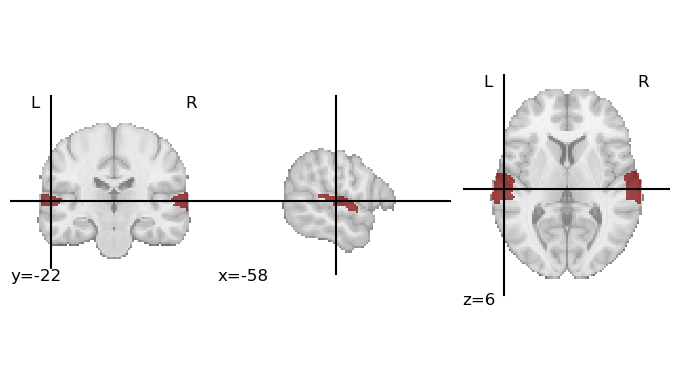

In [4]:
# Parcellation and Atlas References:
    # https://dartbrains.org/content/Parcellations.html#summary-of-differences-between-parcellations
    # https://nipy.org/nibabel/nibabel_images.html
    # https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html
    # https://nilearn.github.io/dev/modules/generated/nilearn.regions.Parcellations.html
    # https://dartbrains.org/content/Parcellations.html#nilearn
    # https://carpentries-incubator.github.io/SDC-BIDS-fMRI/aio/index.html

def create_mask(dir='../resources/rois/', n_rois=200, yeo_networks=17, resolution_mm=1):
    """
    Create a brain mask using the Schaefer atlas or a provided directory.
    
    Parameters:
    dir (str): Directory to fetch or load atlas data from.
    n_rois (int): Number of regions of interest.
    yeo_networks (int): Number of Yeo networks.
    resolution_mm (int): Resolution in millimeters.

    Returns:
    tuple: NiftiLabelsMasker object, atlas image, and region labels.
    """
    if dir == '../resources/rois/':
        parcel_dir = dir
        schaefer = datasets.fetch_atlas_schaefer_2018(n_rois, yeo_networks, resolution_mm, data_dir=parcel_dir)
        atlas_schaefer = schaefer['maps']
        atlas = connected_label_regions(atlas_schaefer)
    else:
        atlas = dir

    masker = input_data.NiftiLabelsMasker(labels_img=atlas, standardize=True)
    atlas_img = nimg.load_img(atlas)
    region_labels = np.unique(atlas_img.get_fdata())
    region_labels = np.setdiff1d(region_labels, [0])  # Remove the background label (0)

    return masker, atlas, region_labels

def view_labels(atlas, roi='a == 1'):
    """
    View the labels of the atlas for a specified region of interest (ROI).
    
    Parameters:
    atlas (Nifti1Image): Atlas image.
    roi (str): Mathematical expression to specify the ROI.

    """
    roi_mask = nimg.math_img(roi, a=atlas)
    nplot.plot_roi(roi_mask, cmap='jet')

fine_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_fine_208parcels.nii.gz"
# course_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_coarse_79parcels.nii.gz"  # Uncomment this, comment above, and change below for course ICP
mask, atlas, region_labels = create_mask(fine_ICP)
print("Number of Labels in Mask: ", len(region_labels))
view_labels(atlas)

### DONT RUN (Unless Subjects Are Not Parcellated) Load and Parcellate Subjects (REVIST INCOMPLETE)

In [ ]:
def load(n=0, folder1=0, folder2=-1):
    """
    Load data for a specified number of subjects and fMRI tasks.

    Parameters:
    n (int): Number of subjects to load (default is 0).
    folder1 (int): Index of the first fMRI task folder (default is 0).
    folder2 (int): Index of the second fMRI task folder, if any (default is -1).

    Returns:
    list: A list of tuples containing paths to the subject data files.
    """
    # Min and max number of subjects
    if n < 0:
        n = 0
    elif n > 1113:
        n = 1113

    # Define the directory where the data is stored
    base_directory = "/project_cephfs/3022017.01/S1200"
    subdirectory = "MNINonLinear/Results"
    
    # Define the list of folders for rfMRI and tfMRI
    folders = [
        "rfMRI_REST1_LR", "rfMRI_REST1_RL", "rfMRI_REST2_LR", "rfMRI_REST2_RL",
        "tfMRI_EMOTION_LR", "tfMRI_EMOTION_RL", "tfMRI_GAMBLING_LR", "tfMRI_GAMBLING_RL",
        "tfMRI_LANGUAGE_LR", "tfMRI_LANGUAGE_RL", "tfMRI_MOTOR_LR", "tfMRI_MOTOR_RL",
        "tfMRI_RELATIONAL_LR", "tfMRI_RELATIONAL_RL", "tfMRI_SOCIAL_LR", "tfMRI_SOCIAL_RL",
        "tfMRI_WM_LR", "tfMRI_WM_RL"
    ]
    
    # Randomly select n subjects without repetition
    selected_subjects = set()
    subjects = os.listdir(base_directory)
    while len(selected_subjects) < n:
        subject = random.choice(subjects)
        subject_data1 = os.path.join(base_directory, subject, subdirectory, folders[folder1], folders[folder1] + ".nii.gz")

        # Check if the file exists before adding the subject
        if os.path.exists(subject_data1):
            if folder2 >= 0:
                subject_data2 = os.path.join(base_directory, subject, subdirectory, folders[folder2], folders[folder2] + ".nii.gz")
                # Check if the second file exists before adding it
                if os.path.exists(subject_data2):
                    selected_subjects.add((subject_data1, subject_data2))
            else:
                selected_subjects.add((subject_data1,))

    return [list(sub) for sub in selected_subjects]

def parcellate(sub_data, masker, region_labels, verbose=False):
    """
    Parcellate fMRI data into regions of interest.

    Parameters:
    sub_data (Nifti1Image): The fMRI data to be parcellated.
    masker: The masker object used for parcellation.
    region_labels (list): List of region labels for the parcellation.
    verbose (bool): If True, print additional information (default is False).

    Returns:
    np.ndarray: The parcellated fMRI data.
    """
    # Create parcellated data
    parcellated = masker.fit_transform(sub_data)
    num_labels = len(region_labels)
    
    # Number of timepoints
    num_timepoints = sub_data.shape[3]
    # Create an array of zeros that has the correct size
    final_signal = np.zeros((num_timepoints, num_labels))

    # Get regions that are kept
    regions_kept = np.array(masker.labels_, dtype='int')

    # Fill columns matching labels with signal values
    final_signal[:, regions_kept-1] = parcellated
    if verbose:
        print("Number of atlas labels: ", num_labels)
        print("Number of parcellated labels: ", len(masker.labels_))
        print("Missing labels: ", set(region_labels) - set(np.unique(masker.labels_)))
    return final_signal

def parcellate_all(allsubs, mask, region_labels, save=False, verbose=False, location=''):
    """
    Parcellate data for all subjects and tasks, and optionally save the results.

    Parameters:
    allsubs (list): List of subject data paths.
    mask: The masker object used for parcellation.
    region_labels (list): List of region labels for the parcellation.
    save (bool): If True, save the parcellated data (default is False).
    verbose (bool): If True, print additional information (default is False).
    location (str): The directory location to save the parcellated data (default is '').

    Returns:
    list: List of parcellated data arrays for all subjects and tasks.
    """
    main_output_directory = os.path.normpath(r"/project/3022057.01/")

    alldata = []
    for sub in allsubs:
        for task in sub:
            if verbose:
                print(task)
            sub_data = nimg.load_img(task)
            parcellated = parcellate(sub_data, mask, region_labels, verbose=verbose)
            alldata.append(parcellated)
            if save:
                subdir = task[task.find("S1200") + len("S1200"):].split("/")[1]
                taskdir = task[task.find("Results") + len("Results"):].split("/")[1]
                sub_output_directory = os.path.join(main_output_directory, location, subdir)
                os.makedirs(sub_output_directory, exist_ok=True)
                output_filename = os.path.join(sub_output_directory, f"{taskdir}_parcellated.npy")
                if verbose:
                    print(output_filename)
                np.save(output_filename, parcellated)
    return alldata

n = 200
folder1 = 8
folder2 = 16

allsubs = load(n, folder1, folder2)
print(allsubs)
alldata = parcellate_all(allsubs, mask, region_labels, save=True, verbose=True, location="icp_parcellated_subs")

### Load and or Simulate Data (REVIST INCOMPLETE)

TODO Time Series Checks and Paths Hardcoded

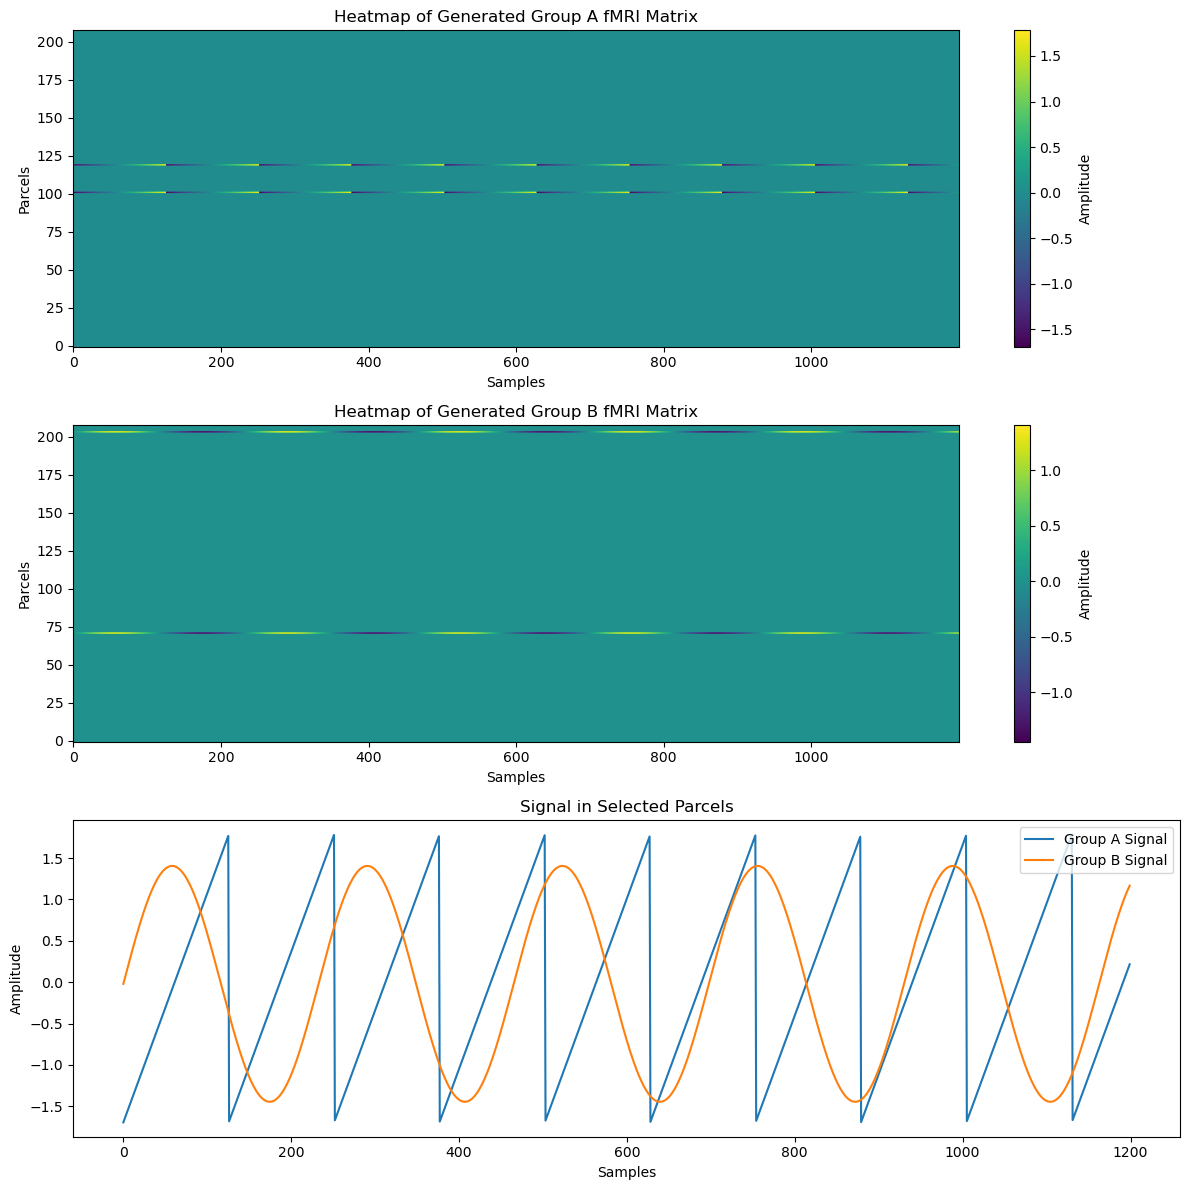

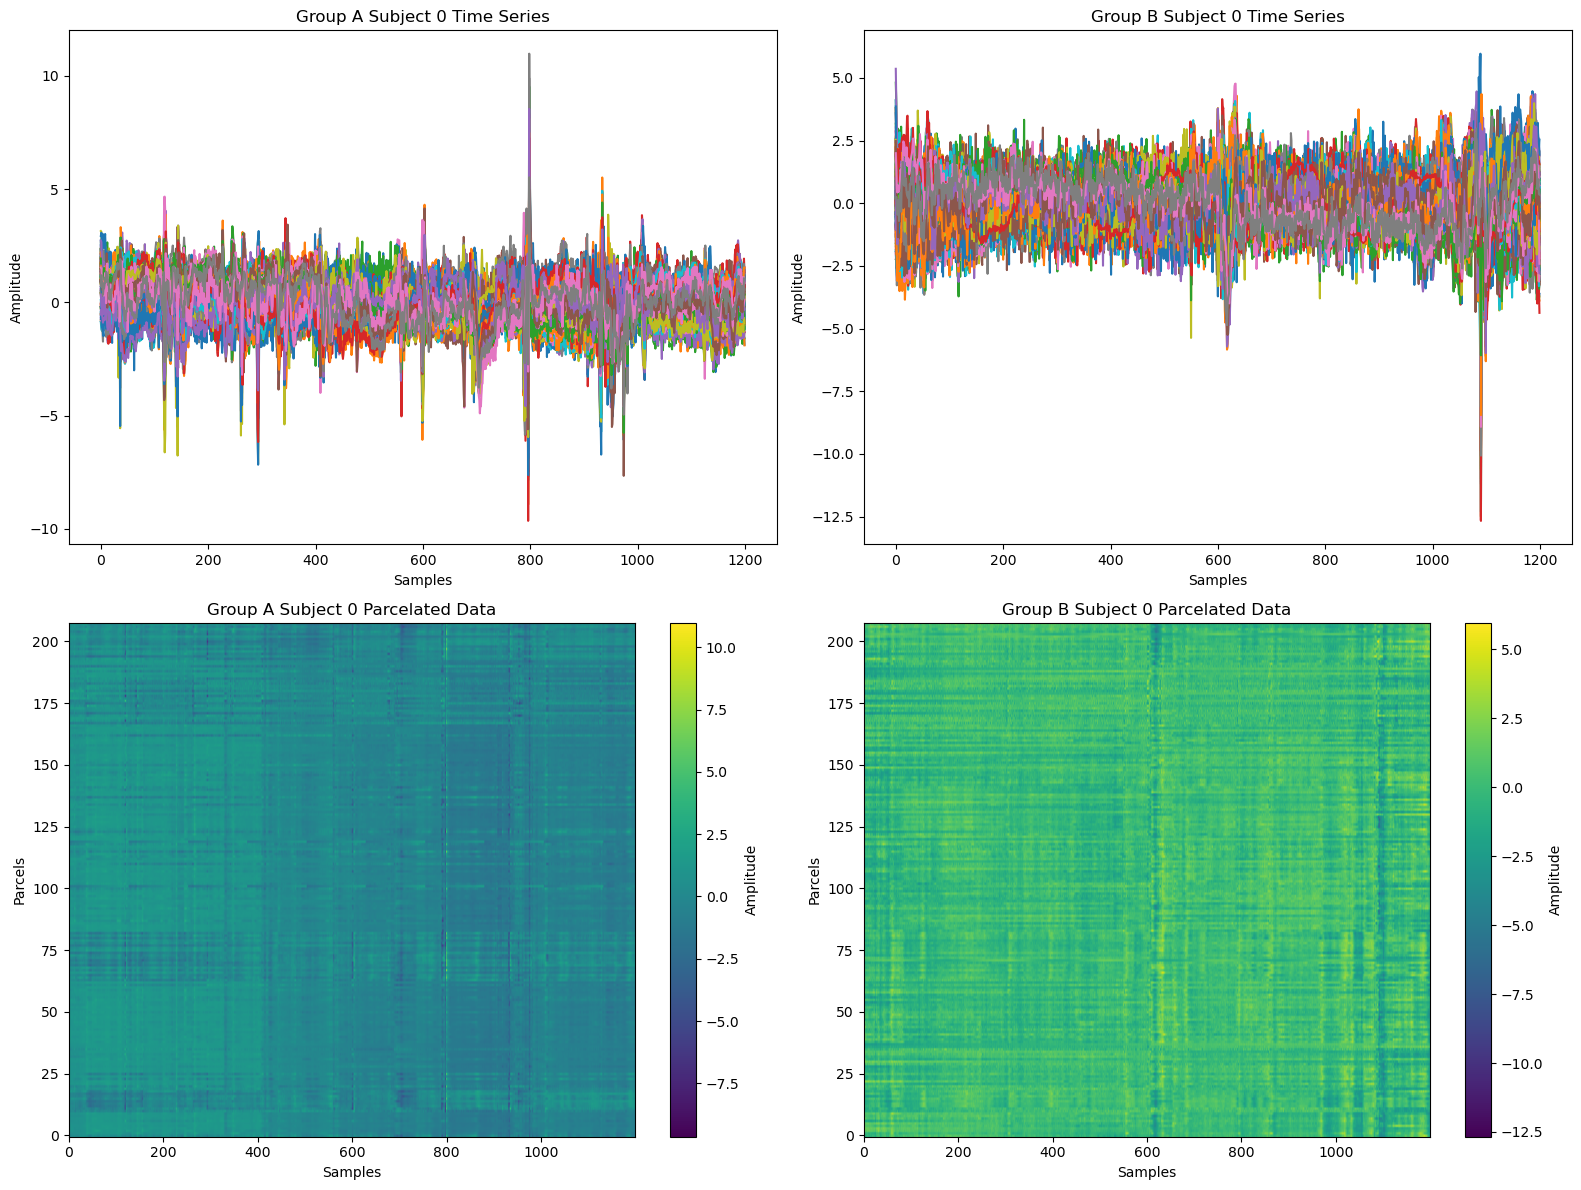

In [5]:
def create_signal(samples, parcels, sig_freqA=0.03, sig_freqB=0.05, spatial_ratio=0.1, signal_type="saw", visualize=False):
    """
    Create and add signal to a random subset of parcels.

    Parameters:
    samples (int): Number of samples.
    parcels (int): Number of parcels.
    sig_freqA (float): Frequency of the signal for group A.
    sig_freqB (float): Frequency of the signal for group B.
    spatial_ratio (float): Ratio of parcels to add the signal.
    signal_type (str): Type of the signal, 'saw' or 'sin'.
    visualize (bool): Whether to visualize the signals and heatmaps.

    Returns:
    tuple: groupA_signal, groupB_signal, groupA_parcels, groupB_parcels
    """
    
    num_parcels_with_signal = int(spatial_ratio * parcels)
    groupA_parcels = np.random.choice(parcels, size=num_parcels_with_signal, replace=False)
    groupB_parcels = np.random.choice(np.setdiff1d(np.arange(parcels), groupA_parcels), size=num_parcels_with_signal, replace=False)

    x = np.linspace(0, samples, num=samples)
    if signal_type == "sin":
        groupA_signal = np.sin(sig_freqA * x)
        groupB_signal = sawtooth(sig_freqB * x)
    else:
        groupA_signal = sawtooth(sig_freqA * x)
        groupB_signal = np.sin(sig_freqB * x)

    groupA_signal = (groupA_signal - np.mean(groupA_signal)) / np.std(groupA_signal)
    groupB_signal = (groupB_signal - np.mean(groupB_signal)) / np.std(groupB_signal)

    parcelsA = np.zeros((samples, parcels))
    parcelsB = np.zeros((samples, parcels))

    parcelsA[:, groupA_parcels] += np.reshape(groupA_signal, (-1, 1))
    parcelsB[:, groupB_parcels] += np.reshape(groupB_signal, (-1, 1))

    if visualize:
        plt.figure(figsize=(12, 12))
        plt.subplot(3, 1, 1)
        plt.imshow(parcelsA.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.title('Heatmap of Generated Group A fMRI Matrix')
        plt.xlabel('Samples')
        plt.ylabel('Parcels')
        
        plt.subplot(3, 1, 2)
        plt.imshow(parcelsB.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.title('Heatmap of Generated Group B fMRI Matrix')
        plt.xlabel('Samples')
        plt.ylabel('Parcels')

        plt.subplot(3, 1, 3)
        plt.plot(groupA_signal, label="Group A Signal")
        plt.plot(groupB_signal, label="Group B Signal")
        plt.title('Signal in Selected Parcels')
        plt.legend()
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()

    return groupA_signal, groupB_signal, groupA_parcels, groupB_parcels

def simulate_data(allsubs_data, sig_freqA=0.03, sig_freqB=0.5, spatial_ratio=0.01, sub_ratio=0.5, original_level=0.5, simulateA=True, simulateB=True):
    """
    Simulate data by adding signals to a subset of subjects.

    Parameters:
    allsubs_data (numpy.ndarray): Array of all subjects' data.
    sig_freqA (float): Frequency of the signal for group A.
    sig_freqB (float): Frequency of the signal for group B.
    spatial_ratio (float): Ratio of parcels to add the signal.
    sub_ratio (float): Ratio of subjects to add the signal.
    original_level (float): Weight of the original signal.
    simulateA (bool): Whether to simulate data for group A.
    simulateB (bool): Whether to simulate data for group B.

    Returns:
    tuple: groupA_data, groupB_data, groupA_parcels, groupB_parcels
    """
    
    samples = allsubs_data[0].shape[0]
    parcels = allsubs_data[0].shape[1]
    groupA_signal, groupB_signal, groupA_parcels, groupB_parcels = create_signal(samples, parcels, sig_freqA=sig_freqA, sig_freqB=sig_freqB, spatial_ratio=spatial_ratio, signal_type="saw", visualize=True)

    nsubjects = len(allsubs_data)
    nsubjects_semi_simulated = int(nsubjects * sub_ratio)

    selected_subjects = np.random.choice(nsubjects, size=nsubjects_semi_simulated, replace=False)
    unselected_subjects = np.setdiff1d(np.arange(nsubjects), selected_subjects)

    groupA_data = allsubs_data[selected_subjects, :, :].copy()
    groupB_data = allsubs_data[unselected_subjects, :, :].copy()
    
    if simulateA:
        for i, subject in enumerate(groupA_data):
            for parcel in groupA_parcels:
                subjectA_signal = (subject[:, parcel] - np.mean(subject[:, parcel])) / np.std(subject[:, parcel])
                groupA_data[i, :, parcel] = np.sqrt(original_level) * subjectA_signal + np.sqrt(1 - original_level) * groupA_signal

    if simulateB:
        for i, subject in enumerate(groupB_data):
            for parcel in groupB_parcels:
                subjectB_signal = (subject[:, parcel] - np.mean(subject[:, parcel])) / np.std(subject[:, parcel])
                groupB_data[i, :, parcel] = np.sqrt(original_level) * subjectB_signal + np.sqrt(1 - original_level) * groupB_signal

    return groupA_data, groupB_data, groupA_parcels, groupB_parcels

def visualize_semi_simulated_subject(groupA_data, groupB_data):
    """
    Visualize the semi-simulated subjects' data.

    Parameters:
    groupA_data (numpy.ndarray): Simulated data for group A.
    groupB_data (numpy.ndarray): Simulated data for group B.
    """
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

    axes[0, 0].plot(groupA_data[0, :, :])
    axes[0, 0].set_title('Group A Subject 0 Time Series')
    axes[0, 0].set_xlabel('Samples')
    axes[0, 0].set_ylabel('Amplitude')

    axes[0, 1].plot(groupB_data[0, :, :])
    axes[0, 1].set_title('Group B Subject 0 Time Series')
    axes[0, 1].set_xlabel('Samples')
    axes[0, 1].set_ylabel('Amplitude')

    img = axes[1, 0].imshow(groupA_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 0])
    cbar.set_label('Amplitude')
    axes[1, 0].set_title('Group A Subject 0 Parcelated Data')
    axes[1, 0].set_xlabel('Samples')
    axes[1, 0].set_ylabel('Parcels')
    
    img = axes[1, 1].imshow(groupB_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 1])
    cbar.set_label('Amplitude')
    axes[1, 1].set_title('Group B Subject 0 Parcelated Data')
    axes[1, 1].set_xlabel('Samples')
    axes[1, 1].set_ylabel('Parcels')

    plt.tight_layout()
    plt.show()



subjects_path = r'/project/3022057.01/icp_parcellated_subs'
groupA_data = []
groupB_data = []
groupA_type = "REST"
groupB_type = "MOTOR"
simulate = True
n_subs = 200

if simulate:
    allsubs_data = []
    for subdir, dirs, files in os.walk(subjects_path):
        for file in files:
            if groupA_type in file:
                sub_data = np.load(os.path.join(subdir,file))
                if sub_data.shape[0] == 1200:
                    allsubs_data.append(sub_data)
    allsubs_data = np.array(allsubs_data)
    groupA_data, groupB_data, groupA_parcels, groupB_parcels = simulate_data(allsubs_data, sig_freqA=.05,sig_freqB=.027, spatial_ratio=.01, sub_ratio=.5, original_level=.1, simulateA=True, simulateB=True)
else:
    for subdir, dirs, files in os.walk(subjects_path):
        for file in files:
            if len(groupA_data) >= n_subs and len(groupB_data) >= n_subs:
                break
            if groupA_type in file and len(groupA_data) < n_subs:
                sub_data = np.load(os.path.join(subdir,file))
            # if sub_data.shape[0] == 1200:
                groupA_data.append(sub_data)
            elif (groupB_type in file) and len(groupB_data) < n_subs:
                groupB_data.append(np.load(os.path.join(subdir,file)))

groupA_data = np.array(groupA_data)
groupB_data = np.array(groupB_data)

visualize_semi_simulated_subject(groupA_data, groupB_data)

### Standardize and Demean Subjects (REVIST INCOMPLETE)

TODO Need to decide whether to demean on the subject level, group level, or across spatial dimensions. Will change for application/branch of pipeline

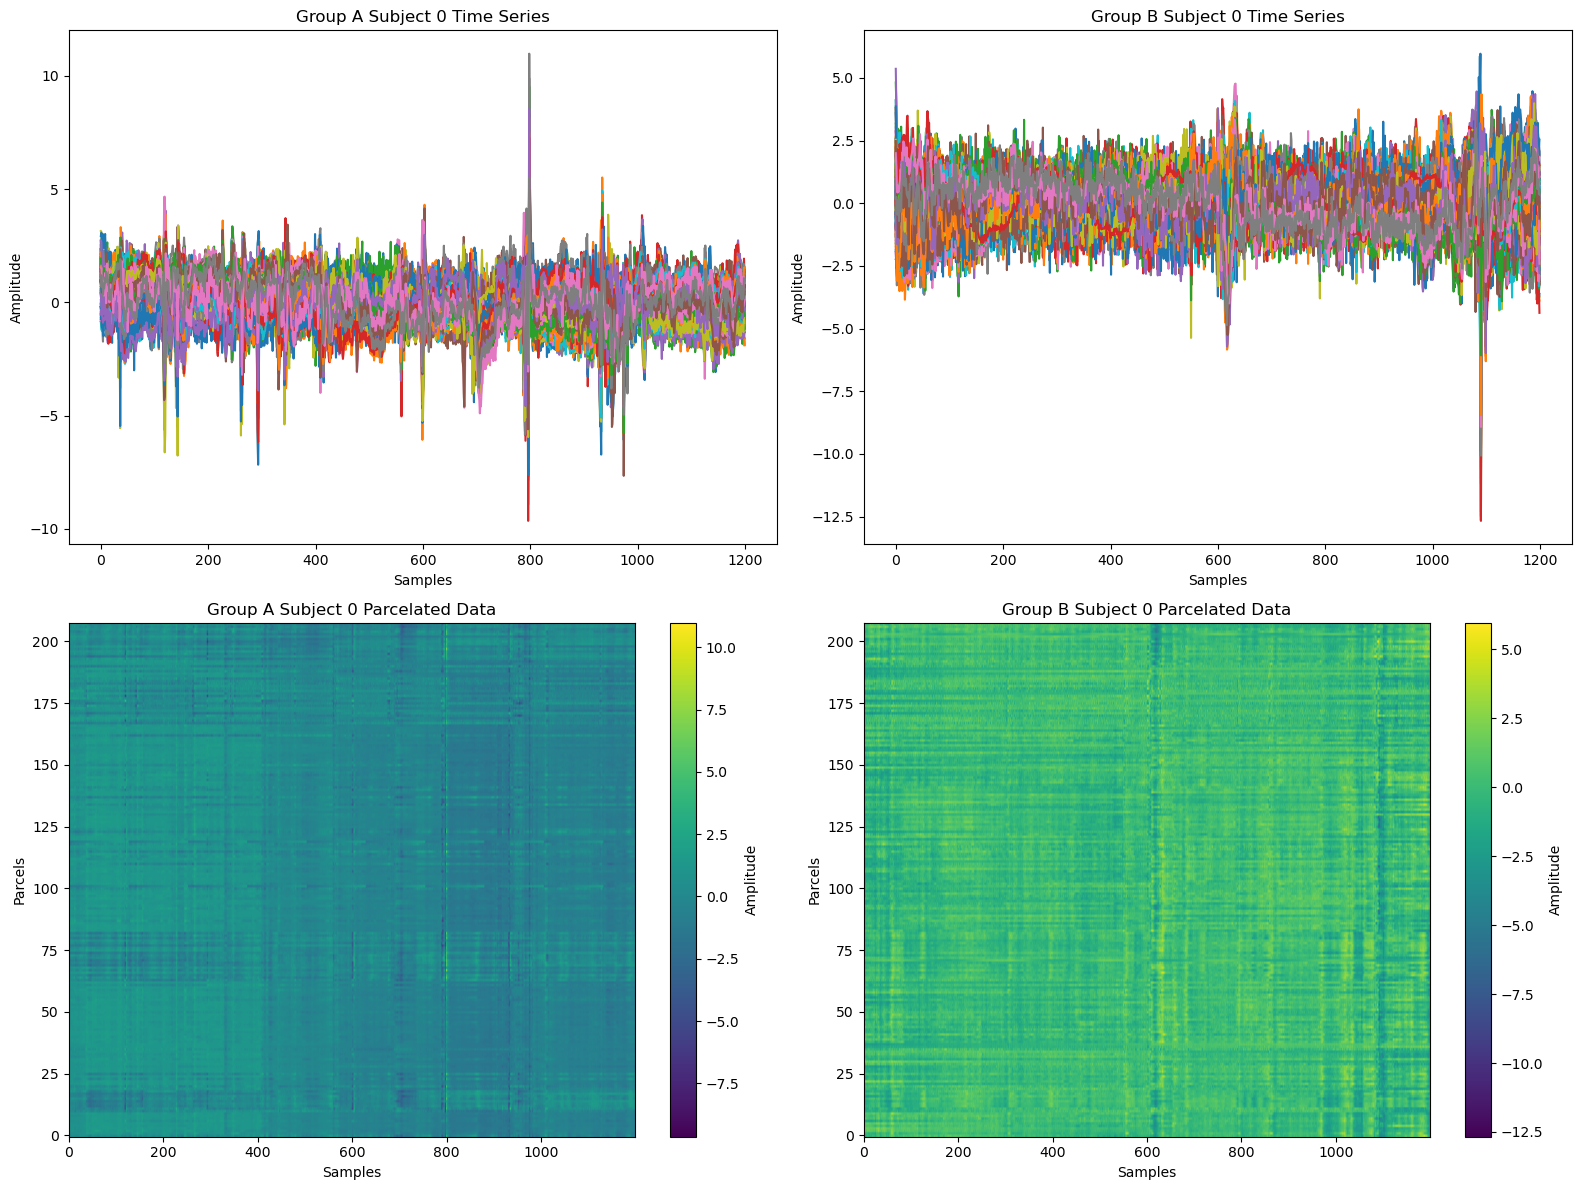

In [6]:
def standardize_demean_individual(group):
    n_subjects, n_timepoints, n_features = group.shape
    preprocessed_group = np.zeros_like(group)

    for i in range(n_subjects):
        subject = group[i]
        
        # Handle NaNs by imputing with the mean of the column
        imputer = SimpleImputer(strategy='mean')
        subject_imputed = imputer.fit_transform(subject)
        
        # Standardize (demean and scale to unit variance) each subject individually
        scaler = StandardScaler()
        standardized_subject = scaler.fit_transform(subject_imputed)
        
        preprocessed_group[i] = standardized_subject

    return preprocessed_group

# Assuming groupA_data and groupB_data are defined
preprocessed_GroupA = standardize_demean_individual(groupA_data)
preprocessed_GroupB = standardize_demean_individual(groupB_data)
# Assuming visualize_semi_simulated_subject is defined
visualize_semi_simulated_subject(preprocessed_GroupA, preprocessed_GroupB)

### Create Covariance Matrices (REVIST INCOMPLETE)

TODO Partial Covariances?
lwf towards group averages?

In [7]:
# https://pyriemann.readthedocs.io/en/latest/auto_examples/signal/plot_covariance_estimation.html
cov_est = Covariances(estimator='lwf')

# Compute the covariance matrices for preprocessed_GroupA and preprocessed_GroupB
groupA_covs = cov_est.transform(np.transpose(preprocessed_GroupA, (0, 2, 1)))
groupB_covs = cov_est.transform(np.transpose(preprocessed_GroupB, (0, 2, 1)))

### MIGP/Group Reductions

1. Should I demean at the group level after MIGP?
2. When to include MIGP
3. Have to weight groups contributions correctly

In [8]:
from scipy.linalg import svd
# TODO Reread MIGP to compare differences 
def incremental_pca_update(W, new_data, m):
    combined_data = np.vstack((W, new_data))
    U, S, Vt = svd(combined_data, full_matrices=False)
    return np.dot(((np.diag(S[:m])**2)/((combined_data.shape[0]))), Vt[:m, :])

def MIGP(group1, m, batch_size, group2=None):
    # Initialize W with the first batch of subjects from group A
    initial_data = group1[:batch_size].reshape(-1, group1.shape[2])
    U, S, Vt = svd(initial_data, full_matrices=False)
    W = np.dot(((np.diag(S[:m])**2)/((initial_data.shape[0]))), Vt[:m, :])
    
    # Process the remaining subjects in batches
    for i in range(batch_size, group1.shape[0], batch_size):
        batch_end = min(i + batch_size, group1.shape[0])
        new_data = group1[i:batch_end].reshape(-1, group1.shape[2])
        W = incremental_pca_update(W, new_data, m)
    
    if group2 is not None:
        # Process the remaining subjects in batches
        for i in range(batch_size, group2.shape[0], batch_size):
            batch_end = min(i + batch_size, group2.shape[0])
            new_data = group2[i:batch_end].reshape(-1, group2.shape[2])
            W = incremental_pca_update(W, new_data, m)
    
    W -= np.mean(W, axis=1, keepdims=True)

    return W

def svd_reduction(subjects_concat, n=0):
    if n==0:
        num_columns = subjects_concat.shape[1]
    else:
        num_columns = n
        
    U,_,_ = np.linalg.svd(subjects_concat,full_matrices=False)
    reduced_subjects = U[:,:num_columns].T@subjects_concat

    return reduced_subjects

if all_subs:
    subs_data = np.array(np.vstack((preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2]), preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2]))))
    subs_data_A = preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2])
    subs_data_B = preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2])
else:
    subs_data = MIGP(preprocessed_GroupA,150,1,preprocessed_GroupB)
    subs_data_A = MIGP(preprocessed_GroupA,150,1)
    subs_data_B = MIGP(preprocessed_GroupB,150,1)

### FKT/SPADE/CSP/GEVD/FDA (REVIST INCOMPLETE)

1. Using Full data for projections to calculate spade cost

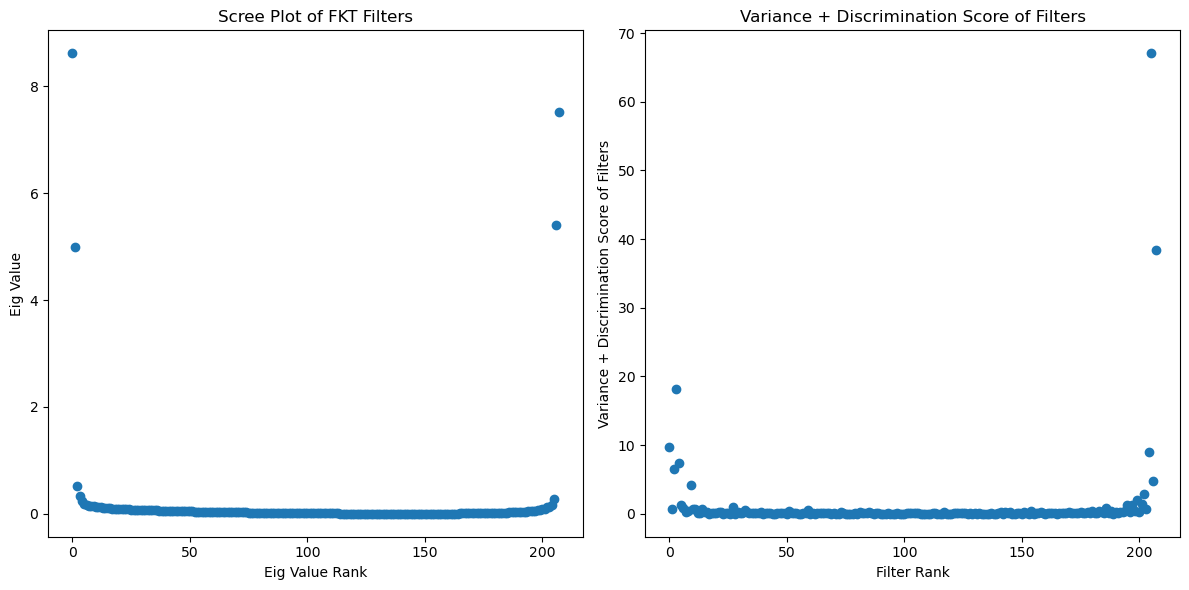

In [9]:
def SPADE_Cost(GroupA,GroupB,filters):
    # groupA = preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2])
    # groupB = preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2])
    return np.var(GroupA@np.linalg.pinv(filters.T), axis=0,ddof=1) - np.var(GroupB@np.linalg.pinv(filters.T), axis=0,ddof=1)
    # return np.var(GroupA@filters, axis=0) - np.var(GroupB@filters, axis=0)
    

def FKT(groupA_cov_matrices, groupB_cov_matrices, GroupA, GroupB, mean="riemann", average=True, visualize=True, gamma=0.0):
    if average:
        groupA_cov = mean_covariance(groupA_cov_matrices, metric=mean)
        groupB_cov = mean_covariance(groupB_cov_matrices, metric=mean)    
        eigs, filters = eigh(groupA_cov, groupA_cov + groupB_cov + gamma*np.identity(groupB_cov.shape[0]),eigvals_only=False)
    else:
        eigs, filters = eigh(groupA_cov_matrices, groupA_cov_matrices + groupB_cov_matrices,eigvals_only=False)
  
    fkt_riem_eigs = np.abs(np.log(eigs/(1-eigs)))**2
    SPADE_eigs = np.abs(SPADE_Cost(GroupA,GroupB,filters))

    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        axs[0].scatter(range(0,fkt_riem_eigs.shape[0]),fkt_riem_eigs)
        axs[0].set_title('Scree Plot of FKT Filters')
        axs[0].set_xlabel('Eig Value Rank')
        axs[0].set_ylabel('Eig Value')

        axs[1].scatter(range(0,filters.shape[1]),SPADE_eigs)
        axs[1].set_title('Variance + Discrimination Score of Filters')
        axs[1].set_xlabel('Filter Rank')
        axs[1].set_ylabel('Variance + Discrimination Score of Filters')

        plt.tight_layout()
        plt.show()
        
    return SPADE_eigs, filters, fkt_riem_eigs

def tangent_CSP(group1_covs, group2_covs, GroupA, GroupB, mean="riemann", average=True, visualize=False, k=1):    
    all_covs = np.concatenate((group1_covs, group2_covs))
    Frechet_Mean = mean_covariance(all_covs, metric='riemann')
    tangent_projected_1 = tangent_space(group1_covs, Frechet_Mean, metric="riemann")
    tangent_projected_2 = tangent_space(group2_covs, Frechet_Mean, metric="riemann")

    # Initialize the Covariances estimator
    cov_estimator = Covariances(estimator='lwf')
    tangent_projected_mean = np.mean(np.concatenate((tangent_projected_1, tangent_projected_2)),axis=0,keepdims=True)  
    
    tangent_1_mean = np.mean(tangent_projected_1,axis=0,keepdims=True) - tangent_projected_mean
    tangent_2_mean = np.mean(tangent_projected_2,axis=0,keepdims=True) - tangent_projected_mean
    tangent_between_scatter = tangent_1_mean.T@tangent_1_mean + tangent_2_mean.T@tangent_2_mean
    
    # Estimate the covariance matrices
    cov_tangent_projected_1 = cov_estimator.transform(np.transpose(tangent_projected_1[np.newaxis,:,:],(0,2,1)))[0]
    cov_tangent_projected_2 = cov_estimator.transform(np.transpose(tangent_projected_2[np.newaxis,:,:],(0,2,1)))[0]
    

    # Convert to PyTorch tensors and move to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(("cuda" if torch.cuda.is_available() else "cpu"))
    cov_tangent_projected_1 = torch.tensor(cov_tangent_projected_1, dtype=torch.float32, device=device)
    cov_tangent_projected_2 = torch.tensor(cov_tangent_projected_2, dtype=torch.float32, device=device) 
    tangent_between_scatter = torch.tensor(tangent_between_scatter, dtype=torch.float32, device=device)
    
    # For filtersA
    _, eigvecs = torch.lobpcg(tangent_between_scatter, B=cov_tangent_projected_1 + cov_tangent_projected_2 + 0.0 * torch.eye(cov_tangent_projected_1.shape[0], device=cov_tangent_projected_1.device), k=k, largest=True)
    eigvecs_array = eigvecs.clone().cpu().numpy()
    filters = untangent_space(eigvecs_array.T, Frechet_Mean)
    SPADE_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent = FKT(filters[0,:,:], Frechet_Mean, GroupA, GroupB, mean=mean, average=False, visualize=visualize, gamma=0.0)

    return SPADE_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent

def tangent_classifier(GroupA, GroupB, group1_covs=None, group2_covs=None, Frechet_Mean=None, tangent_projected_1=None, tangent_projected_2=None, TSVM=False, TLDA=True, tangent_calc=True,visualize=False):
    if tangent_calc:
        all_covs = np.concatenate((group1_covs, group2_covs))
        Frechet_Mean = mean_covariance(all_covs, metric='riemann')
        tangent_projected_1 = tangent_space(group1_covs, Frechet_Mean, metric="riemann")
        tangent_projected_2 = tangent_space(group2_covs, Frechet_Mean, metric="riemann")
    # Create labels for each group
    labels_1 = np.zeros(len(tangent_projected_1))  # Labels for group 1
    labels_2 = np.ones(len(tangent_projected_2))   # Labels for group 2

    # Combine data and labels
    # Samples (e.g 198) x Features (e.g. 21736)
    data = np.concatenate((tangent_projected_1, tangent_projected_2))
    # Samples (e.g. 198)
    labels = np.concatenate((labels_1, labels_2))
    # print(data.shape,labels.shape)
    if TSVM:
        # Create SVM classifier (adjust kernel and parameters as needed)
        clf = SVC(kernel='linear')  
        # Train the classifier
        clf.fit(data, labels)
        filters_SVM = untangent_space(clf.coef_, Frechet_Mean)
        SPADE_eigs_tangent_SVM, fkt_filters_tangent_SVM, fkt_riem_eigs_tangent_SVM = FKT(filters_SVM[0,:,:], Frechet_Mean, GroupA, GroupB, mean='riemann', average=False, visualize=visualize, gamma=0.0)
        return SPADE_eigs_tangent_SVM, fkt_filters_tangent_SVM, fkt_riem_eigs_tangent_SVM

    if TLDA:
        # Create LDA classifier
        lda = LDA()
        # Train the classifier
        lda.fit(data, labels)
        # Get the coefficients from LDA
        filters_LDA = untangent_space(lda.coef_, Frechet_Mean)
        SPADE_eigs_tangent_LDA, fkt_filters_tangent_LDA, fkt_riem_eigs_tangent_LDA = FKT(filters_LDA[0,:,:], Frechet_Mean, GroupA, GroupB, mean='riemann', average=False, visualize=visualize, gamma=0.0)
        return SPADE_eigs_tangent_LDA, fkt_filters_tangent_LDA, fkt_riem_eigs_tangent_LDA

if Tangent_Class:
    SPADE_eigs, fkt_filters, fkt_riem_eigs = tangent_classifier(subs_data_A,subs_data_B, group1_covs=groupA_covs, group2_covs=groupB_covs, TSVM=True, TLDA=False,tangent_calc=True,visualize=True)
elif Tangent_CSP:
    SPADE_eigs, fkt_filters, fkt_riem_eigs = tangent_CSP(groupA_covs, groupB_covs,subs_data_A,subs_data_B, mean="riemann", average=True, visualize=True, k=1)
else:
    SPADE_eigs, fkt_filters, fkt_riem_eigs = FKT(groupA_covs, groupB_covs,subs_data_A,subs_data_B, mean=metric, average=True, visualize=True, gamma=0.0)

### Create Null Distribution via Permutation Testing (REVIST INCOMPLETE)

1. Using Full data for projections to calculate spade cost

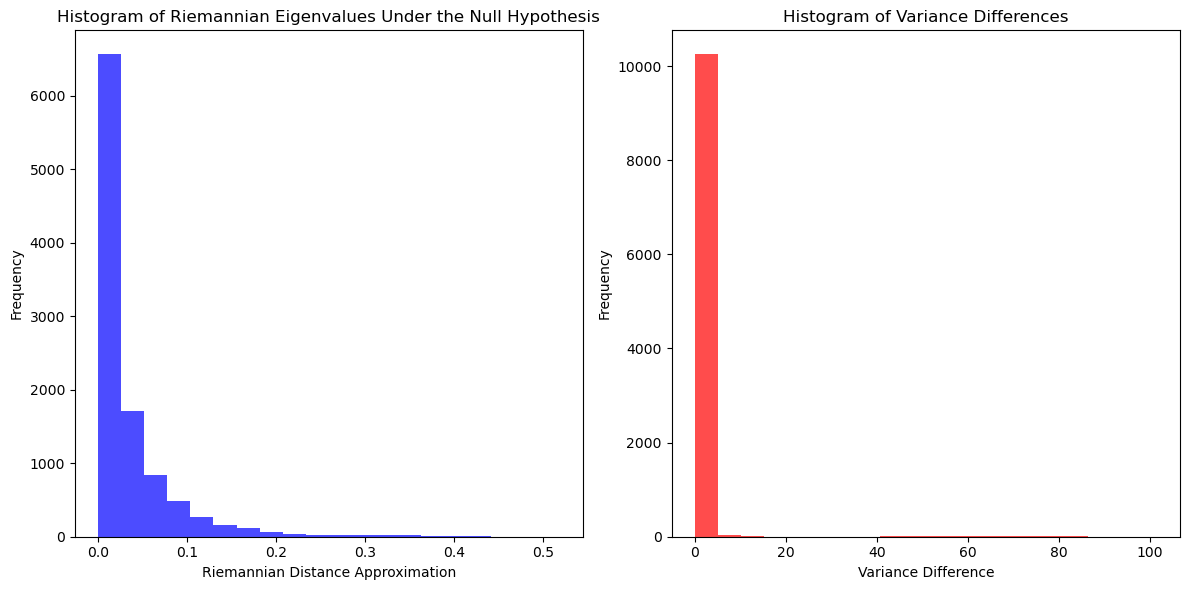

In [10]:
from concurrent.futures import ProcessPoolExecutor
def single_run_fkt(data, n_classA, GroupA, GroupB, filters_func,metric="riemann"):
    # Shuffle the combined data locally
    np.random.shuffle(data)
    new_classA = data[:n_classA]
    new_classB = data[n_classA:]
    del data
    # Calculate filters using the permuted data
    var_discrim_distances, _, riem_distances = filters_func(new_classA, new_classB, GroupA, GroupB, mean=metric, average=True, visualize=False)
    
    return riem_distances, var_discrim_distances

def single_run_tangent(data, n_classA,Frechet_Mean, GroupA, GroupB, filters_func):
    # Shuffle the combined data locally
    np.random.shuffle(data)
    new_classA = data[:n_classA,:]
    new_classB = data[n_classA:,:]
    
    # Calculate filters using the permuted data
    var_discrim_distances, _, riem_distances = filters_func(GroupA, GroupB,  group1_covs=None, group2_covs=None, Frechet_Mean=Frechet_Mean, tangent_projected_1=new_classA, tangent_projected_2=new_classB, TSVM=True, TLDA=False, tangent_calc=False,visualize=False)
    
    return riem_distances, var_discrim_distances

def simulate_FKT(GroupA, GroupB, groupA_covs, groupB_covs, filters_func, n_simulations=10,metric=metric):
    riem_distances = []
    var_discrim_distances = []
    with ProcessPoolExecutor(max_workers=int(os.environ['PBS_NP'])) as executor:
        if filters_func is FKT:
            n_classA = groupA_covs.shape[0]
            combined_data = np.vstack([groupA_covs, groupB_covs])
            futures = [executor.submit(single_run_fkt, combined_data.copy(), n_classA, GroupA, GroupB, filters_func,metric=metric) for _ in range(n_simulations)]
        elif filters_func is tangent_classifier:
            all_covs = np.concatenate((groupA_covs, groupB_covs))
            Frechet_Mean = mean_covariance(all_covs, metric='riemann')
            tangent_projected_1 = tangent_space(groupA_covs, Frechet_Mean, metric="riemann")
            tangent_projected_2 = tangent_space(groupB_covs, Frechet_Mean, metric="riemann")
            n_classA = tangent_projected_1.shape[0]
            combined_data = np.vstack([tangent_projected_1, tangent_projected_2])
            futures = [executor.submit(single_run_tangent, combined_data.copy(), n_classA, Frechet_Mean, GroupA, GroupB, filters_func) for _ in range(n_simulations)]

        for future in futures:
            perm_result, alt_result = future.result()
            riem_distances.extend(perm_result)
            var_discrim_distances.extend(alt_result)
    
    # Visualize the results for permuted distances
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(riem_distances, bins=20, color='blue', alpha=0.7)
    plt.title('Histogram of Riemannian Eigenvalues Under the Null Hypothesis')
    plt.xlabel('Riemannian Distance Approximation')
    plt.ylabel('Frequency')

    # Visualize the results for alternate distances
    plt.subplot(1, 2, 2)
    plt.hist(var_discrim_distances, bins=20, color='red', alpha=0.7)
    plt.title('Histogram of Variance Differences')
    plt.xlabel('Variance Difference')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return riem_distances, var_discrim_distances

if Tangent_Class:
    riem_distances, var_discrim_distances = simulate_FKT(subs_data_A, subs_data_B, groupA_covs, groupB_covs, tangent_classifier,n_simulations=10)
else:
    riem_distances, var_discrim_distances = simulate_FKT(subs_data_A, subs_data_B, groupA_covs, groupB_covs, FKT,n_simulations=50,metric=metric)

### Select FKT Components (REVIST INCOMPLETE)

1. Should QR Decomposition be used? (Should I orthonormalize the filters)
2. Is this the right way to calculate the eigenvalues?
3. Is model order selection valid?
4. Using Full data for projections to calculate spade cost

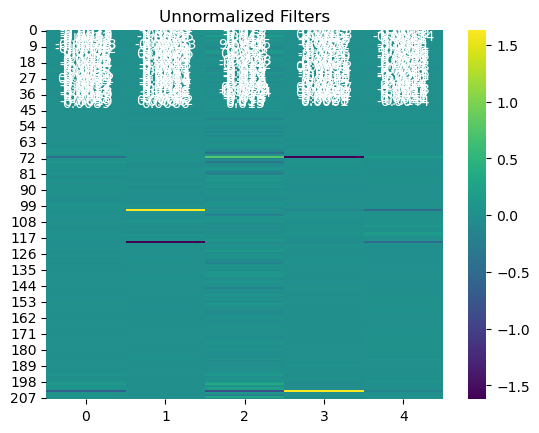

Orthonormalize Discriminant Filters


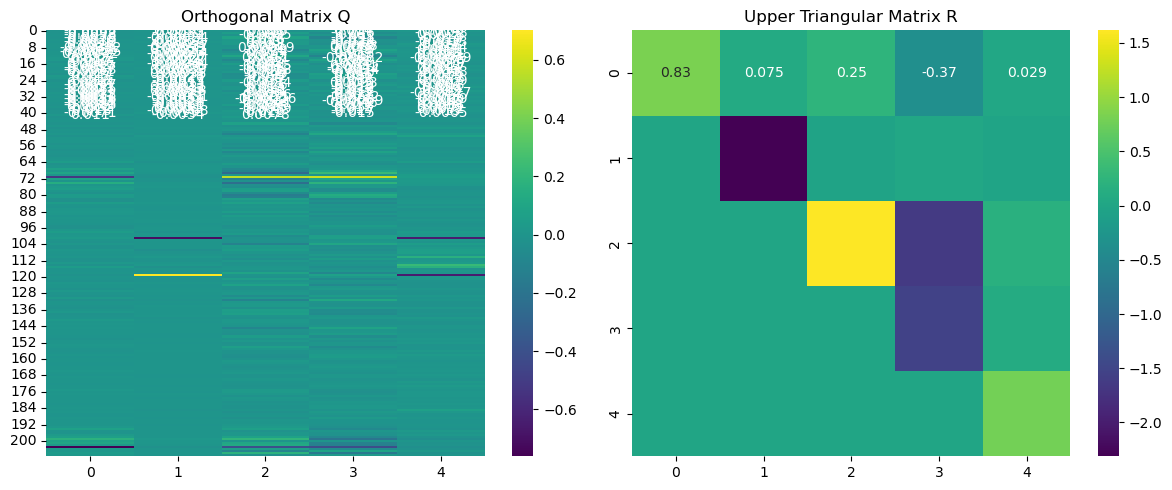

Select Group A Variance Explaining Discriminant Filters


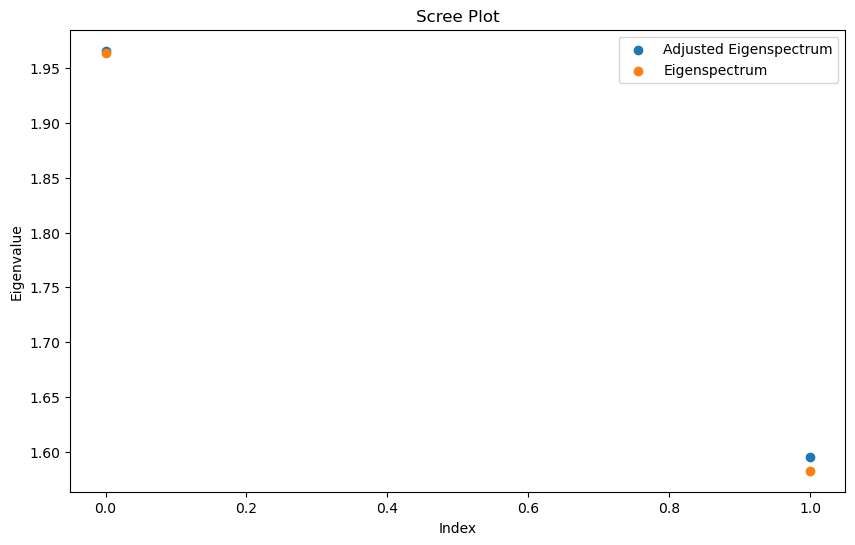

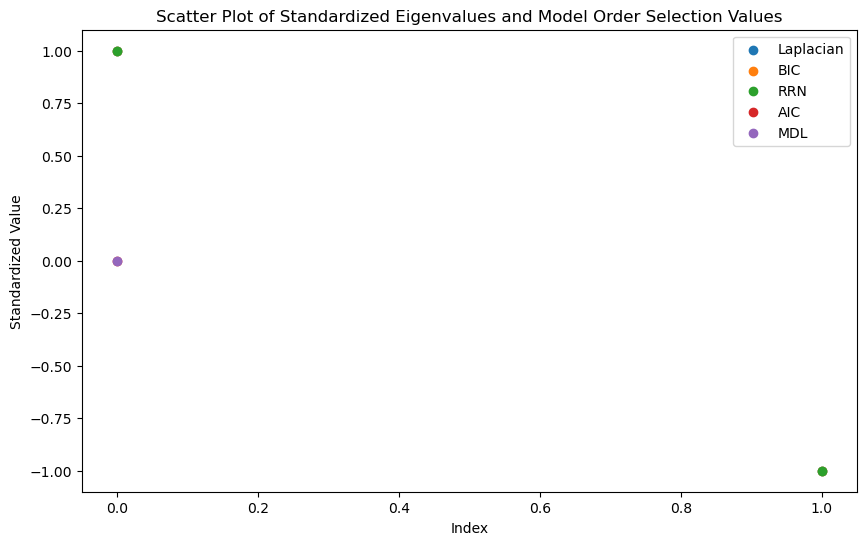

Select Group B Variance Explaining Discriminant Filters


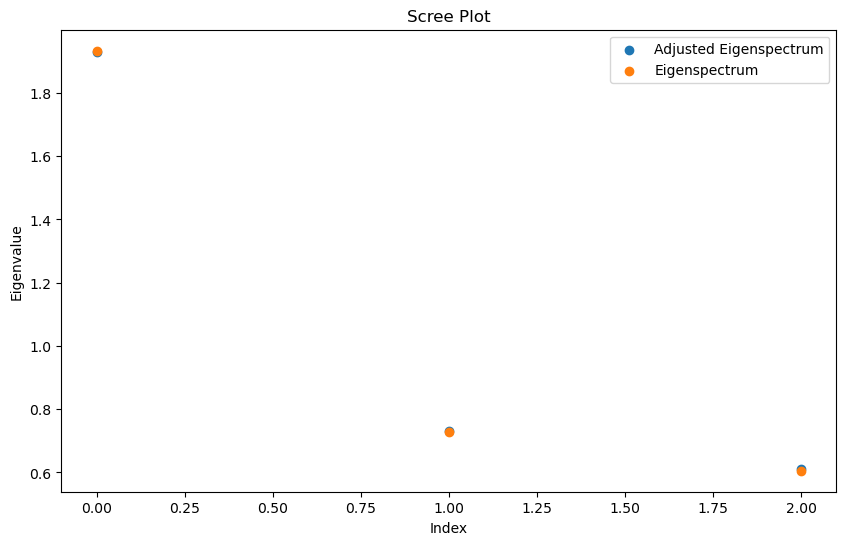

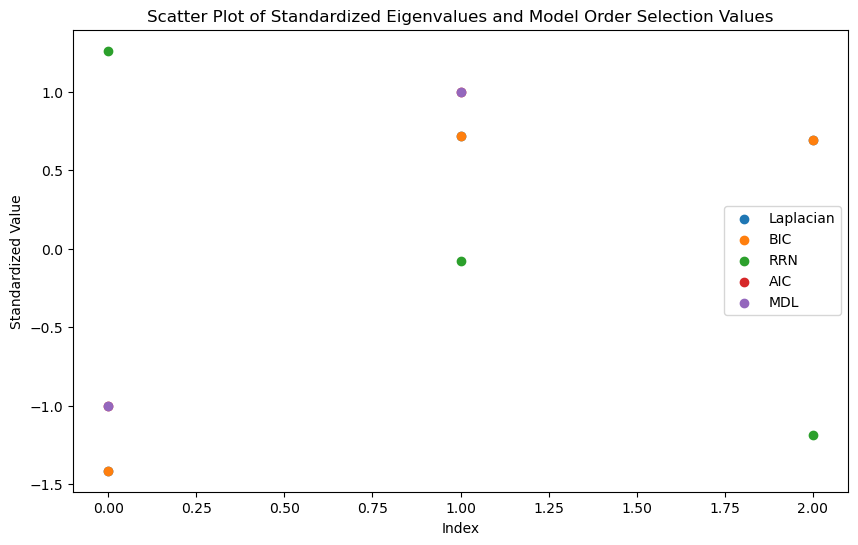

Number of Group A Filters: 1
Number of Group B Filters: 1
Total Number of Filters Chosen Via Riemannian Approximation Followed by Variance Explanation: 2
Total Number of Filters Chosen Via SPADE Cost Function: 208


/scratch/zaisou/52890334.dccn-l029.dccn.nl/ipykernel_13251/201089475.py:110: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(top_filters, aspect='auto', cmap='viridis', origin='lower')


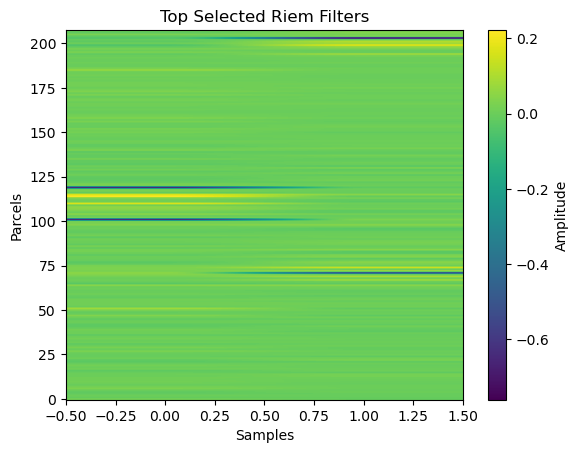

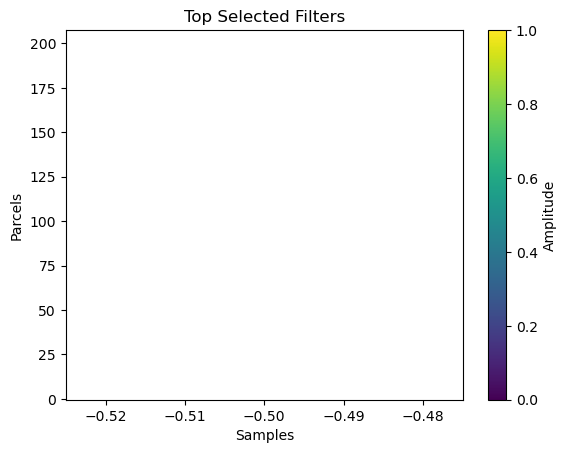

In [11]:
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm

def test_significance(null_distribution, test_statistics, alpha=0.05):
    """
    Calculate p-values for test statistics against a null distribution and apply Bonferroni correction.

    Parameters:
    - null_distribution (array-like): The distribution of values under the null hypothesis.
    - test_statistics (array-like): The statistics to test against the null distribution.
    - alpha (float): The significance level for the tests (default is 0.05).

    Returns:
    - p_values (np.array): The p-values for each test statistic.
    - significant_tests (np.array): Boolean array indicating which tests are significant.
    """
    
    # Calculate p-values
    p_values = np.array([np.mean(null_distribution >= ts) for ts in test_statistics])

    # https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
    # Apply FDR correction using the Benjamini-Hochberg method fdr_bh
    reject, _, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')

    return p_values, reject


def QR(basis, visualize=True):
    # Combine normalized projected filters with PCA components
        # QR decomposition
    Q, R = np.linalg.qr(basis)
    
    if visualize:
        # Plot Q matrix
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.heatmap(Q, annot=True, cmap='viridis')
        plt.title("Orthogonal Matrix Q")

        # Plot R matrix
        plt.subplot(1, 2, 2)
        sns.heatmap(R, annot=True, cmap='viridis')
        plt.title("Upper Triangular Matrix R")

        plt.tight_layout()
        plt.show()
    else:
        plt.figure()
        sns.heatmap(R, annot=True, cmap='viridis')
        plt.title("Upper Triangular Matrix R")
        plt.show()

    return Q, R


def FKT_var_select(groupA, groupB, unorth_filters):
    plt.figure()
    sns.heatmap(unorth_filters, annot=True, cmap='viridis')
    plt.title("Unnormalized Filters")
    plt.show()
    print("Orthonormalize Discriminant Filters")
    filters, _ = QR(unorth_filters)
    # filters = unorth_filters
    var_explained = SPADE_Cost(groupA,groupB,filters)
    a_filters = np.where(var_explained > 0)[0]
    b_filters = np.where(var_explained < 0)[0]
    # Note SPADE_Cost is defined such that groupA is the positive class
    # print(var_explained)
    # print(SPADE_Cost(groupA,groupB,unorth_filters))
    
    print("Select Group A Variance Explaining Discriminant Filters")
    A_eigs = np.var(groupA@np.linalg.pinv(filters[:,a_filters].T),axis=0,ddof=1)
    A_eigs_index = np.argsort(A_eigs)[::-1]
    N_A = groupA.shape[0]
    num_A_filters = call_pca_dim(eigs=A_eigs[A_eigs_index],N=N_A)
    reduced_filters_A = filters[:,a_filters][:,A_eigs_index[:num_A_filters]]


    print("Select Group B Variance Explaining Discriminant Filters")
    B_eigs = np.var(groupB@np.linalg.pinv(filters[:, b_filters].T),axis=0,ddof=1)
    B_eigs_index = np.argsort(B_eigs)[::-1]
    N_B = groupB.shape[0]
    num_B_filters = call_pca_dim(eigs=B_eigs[B_eigs_index],N=N_B)
    reduced_filters_B = filters[:,b_filters][:,B_eigs_index[:num_B_filters]]

    reduced_filters = np.concatenate((reduced_filters_A,reduced_filters_B),axis=1)

    print("Number of Group A Filters:", num_A_filters)
    print("Number of Group B Filters:", num_B_filters)

    return reduced_filters, reduced_filters_A, reduced_filters_B

p_values_riem, significant_tests_riem = test_significance(riem_distances, fkt_riem_eigs)
p_values, significant_tests = test_significance(var_discrim_distances, SPADE_eigs)

if len(significant_tests_riem) > 0:
    top_filters_riem, top_filters_riem_A, top_filters_riem_B  = FKT_var_select(subs_data_A, subs_data_B,fkt_filters[:,significant_tests_riem])
    plt.figure()
    plt.imshow(top_filters_riem, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Amplitude')
    plt.title('Top Selected Riem Filters')
    plt.xlabel('Samples')
    plt.ylabel('Parcels')

if len(significant_tests) > 0:
    top_filters = fkt_filters[:,significant_tests]
    plt.figure()
    plt.imshow(top_filters, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Amplitude')
    plt.title('Top Selected Filters')
    plt.xlabel('Samples')
    plt.ylabel('Parcels')

print(f"Total Number of Filters Chosen Via Riemannian Approximation Followed by Variance Explanation: {top_filters_riem.shape[1]}")
print(f"Total Number of Filters Chosen Via SPADE Cost Function: {len(significant_tests)}")

if riem_filters:
    filters = top_filters_riem
    filters_A = top_filters_riem_A
    filters_B = top_filters_riem_B
else:
    filters = top_filters


### Sandbox

In [ ]:
 # Soft Threshold function
def soft(z, lam):     
    return np.sign(z)*np.maximum(np.abs(z)-lam,0) 

# L21 proximal function 
def l21_prox(z, lam):
    """compute the proximal operator of L_21 norm with argument z and paramter lam"""
    x = z.copy()
    col_norm = np.linalg.norm(z,axis=0)
    idx = col_norm<=lam 
    idx_c = np.logical_not(idx)
    x[:,idx]=0
    x[:,idx_c]=(1-lam/col_norm[idx_c])*x[:,idx_c]
    return x

#ADMM Implementation of Robust PCA
def ADMM_L1(L, S, X, lam, rho, niter=10):
    '''
    Input: 
            L:     Low Rank Component of the Data Matrix 
            S:     The Sparse Component of the Data Matrix
            X:     The Data Matrix
            lam:   The regularization term 
            rho:   Augmented Lagrangian Parameter 
            niter: Number of Iterations 
            
        Intermediate: 
            W:     The scaled Dual variables


        Output: 
            L:     The Low Rank Component of the Data Matrix 
        '''  

    W = X-L-S
    for itr in range(niter):
        U,Sig,V = np.linalg.svd(X-S+W, full_matrices=False)
        L = np.dot(np.dot(U,np.diag(soft(Sig,1/rho))),V)
        S = soft(X-L+W, lam/rho)
        W = X-L-S+W




    print("Rank of original data matrix is: {}".format(np.linalg.matrix_rank(X)))
    print("Rank of low rank data matrix is: {}".format(np.linalg.matrix_rank(L)))
    plt.figure()
    plt.imshow(L, aspect='auto', cmap='viridis', origin='lower')
    plt.title('Low Rank Component of the Data Matrix')
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.imshow(S, aspect='auto', cmap='viridis', origin='lower')
    plt.title('Sparse Noise')
    plt.colorbar()
    plt.show()
    
    return L, S

RiemA = mean_covariance(groupA_covs, metric='riemann')
Rho = 1 # Augmented Lagrangian Parameter intialization
ld = 1/np.sqrt(np.amax(RiemA.shape)) # penalty term
A_hat,A_noise =  ADMM_L1(L=RiemA.T, S=np.zeros(RiemA.T.shape),X=RiemA.T, lam=ld, rho = Rho)

RiemB = mean_covariance(groupB_covs, metric='riemann')
B_hat,B_noise =  ADMM_L1(L=RiemB.T, S=np.zeros(RiemB.T.shape),X=RiemB.T, lam=ld, rho = Rho)
balanced = A_hat + np.eye(A_hat.shape[0])*0.000001
SPADE_eigs_test, fkt_filters_test, fkt_riem_eigs_test = FKT(A_hat + np.eye(A_hat.shape[0])*(5e-6), B_hat + np.eye(A_hat.shape[0])*(5e-6),preprocessed_GroupA,preprocessed_GroupB, mean="riemann", average=False, visualize=True, gamma=0.0)
p_values_riem_TEST, significant_tests_riem_TEST = test_significance(riem_distances, fkt_riem_eigs_test)
print(f"Significant tests for Riemannian distances: {significant_tests_riem_TEST}")
top_filters_riem_TEST = FKT_var_select(group_A_reduced,group_B_reduced,all_subjects_reduced,fkt_filters_test[:,significant_tests_riem_TEST])

In [ ]:
# # Generate null distributions for tangent FKT
# riem_distances_tangent, var_discrim_distances_tangent = simulate_FKT(preprocessed_GroupA, preprocessed_GroupB, groupA_covs, groupB_covs, tangent_CSP,n_simulations=1)

SPADE_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent = tangent_CSP(groupA_covs,groupB_covs,subs_data_A,subs_data_B, mean="riemann", average=False, visualize=True, k=1)

# p_values_riem_tangent, significant_tests_riem_tangent = test_significance(riem_distances_tangent, fkt_riem_eigs_tangent)
# p_value_tangent, significant_tests_tangent = test_significance(var_discrim_distances_tangent, SPADE_eigs_tangent)

# print(f"Significant tests for Riemannian distances: {significant_tests_riem_tangent}")
# print(f"Significant tests for variance differences: {significant_tests_tangent}")

# top_filters_riem_tangent = fkt_filters_tangent[:,significant_tests_riem_tangent]
# top_filters_tangent = fkt_filters_tangent[:,significant_tests_tangent]

In [ ]:
p_values_riem_tangent, significant_tests_riem_tangent = test_significance(riem_distances, fkt_riem_eigs_tangent)
top_filters_riem = FKT_var_select(preprocessed_GroupA,preprocessed_GroupB,fkt_filters_tangent[:,significant_tests_riem])
# p_value_tangent, significant_tests_tangent = test_significance(var_discrim_distances, SPADE_eigs_tangent)

# # print(f"Significant tests for Riemannian distances: {significant_tests_riem_tangent}")
# print(f"Significant tests for variance differences: {significant_tests_tangent}")

# # top_filters_riem_tangent = fkt_filters_tangent[:,significant_tests_riem_tangent]
# if len(significant_tests) > 0:
#     top_filters_tangent = FKT_proj(reshaped_preprocessed_subjects,fkt_filters[:,significant_tests])

In [ ]:
def visualize(all_filters):
     # Create a figure and axes for subplots
    fig, axes = plt.subplots(all_filters.shape[1], 1, figsize=(6, 4*all_filters.shape[1]))

    # Iterate over each axis of filters
    for i in range(all_filters.shape[1]):
        # Access the subplot using indexing
        if all_filters.shape[1] == 1:
            ax = axes
        else:
            ax = axes[i]

        # Calculate the outer product image for the current axis
        outer_product = all_filters[:, i:i+1]@ all_filters[:, i:i+1].T

        # Plot the outer product image on the corresponding subplot
        im = ax.imshow(outer_product, aspect='auto', cmap='viridis', origin='lower')
        ax.set_title(f"Outer Product for Axis {i}")
        fig.colorbar(im, ax=ax, label='Amplitude')

        plt.tight_layout()
    plt.show()

In [ ]:
def PCA_svd(X,n=0):
    n_samples, n_features = X.shape
    X_standardized = (X - np.mean(X, axis=0))
    U,s,Vh = np.linalg.svd(X_standardized, full_matrices=False)
    eigenvalues = (s**2)/n_samples
    if n != 0:
        return U[:,:n]
    else:
        plt.scatter(range(0,eigenvalues.shape[0]),eigenvalues)
        plt.show()

#### Combine Spatially and Whiten


In [ ]:
def combine_spatial_bases(group_data_reduced, groupA_data, groupB_data, fkt_A, fkt_B):
    # Project fkt_basis onto the row space of group_data
    fkt_A_space = (np.linalg.pinv(np.linalg.pinv(groupA_data.T) @ fkt_A)@groupA_data)
    fkt_B_space = (np.linalg.pinv(np.linalg.pinv(groupB_data.T) @ fkt_B)@groupB_data)
    print(fkt_A_space.shape, fkt_B_space.shape)

    n_components = call_pca_dim(Data=group_data_reduced)  # Get the number of components
    U, E, VT = np.linalg.svd(group_data_reduced, full_matrices=False)
    print(E.shape)
    print(VT[:n_components,:].shape)

    # Combine PCA components with projected fkt_basis
    combined_spatial_basis = np.vstack((VT[:n_components,:],fkt_A_space, fkt_B_space))
    print(combined_spatial_basis.shape)
    # QR decomposition
    Q, R = QR(combined_spatial_basis.T)
    return Q

def ICA_alt(whitened_data):
    ica_alt = FastICA(whiten=False)
    
    # Takes in Samples (Space) x Features
    # Transpose output to obtain componentsx samples
    IFA_components_alt = ica_alt.fit_transform(whitened_data).T  
    
    return IFA_components_alt

nonindep_spatial = combine_spatial_bases(all_subjects_reduced, subs_data_A, subs_data_B, top_filters_riem_A, top_filters_riem_B)
print(nonindep_spatial.shape)

raw_components_combined_alt = ICA_alt(nonindep_spatial)


def threshold_and_visualize_alt(filters, atlas, threshold=4):
    # Define a function to compute p-values from your filters
    def compute_p_values(filter):
        std_groupIFA = (filter - np.mean(filter, keepdims=True, axis=0)) / np.std(filter, axis=0)
        # Assuming a normal distribution, compute two-tailed p-values
        p_values = 2 * (1 - norm.cdf(np.abs(std_groupIFA)))
        return p_values

    # Process each filter individually
    for i in range(filters.shape[1]):
        filter = (filters[:, i:i+1])
        std_groupIFA = (filter - np.mean(filter, keepdims=True, axis=0)) / np.std(filter, axis=0)
        
        # Compute p-values for the current filter
        p_values = compute_p_values(filter)
        
        # Apply multiple comparisons correction for the current filter
        corrected_p_values = multipletests(p_values.flatten(), method='fdr_bh')[1]
        corrected_p_values = corrected_p_values.reshape(p_values.shape)
        
        # Threshold the corrected p-values
        threshold = 0.05
        significant_indices = corrected_p_values < threshold
        
        # Create a figure and axes for subplots (1 row of 2 plots per filter)
        fig, axes = plt.subplots(1, 2, figsize=(18, 10))

        ax_hist1 = axes[0]
        ax_img = axes[1]

        # Plot the histogram of the current filter
        ax_hist1.hist(std_groupIFA, bins=30, color='blue', alpha=0.7)
        ax_hist1.set_title(f"Histogram for Filter {i+1}")
        ax_hist1.set_xlabel('Value')
        ax_hist1.set_ylabel('Frequency')

        # Generate the brain image mask using the significant indices
        masked_comp = std_groupIFA * significant_indices
        
        # Calculate the outer product image for the current filter
        outer_product = masked_comp @ masked_comp.T

        # Plot the outer product image on the corresponding subplot
        im = ax_img.imshow(outer_product, aspect='auto', cmap='viridis', origin='lower')
        ax_img.set_title(f"Outer Product for Filter {i+1}")
        fig.colorbar(im, ax=ax_img, label='Amplitude')

        plt.tight_layout()
        plt.show()
        
        # Skip the iteration if there are no significant values
        if not np.any(significant_indices):
            print(f'Component {i} did not contain any significant values')
            continue

        roi = ' | '.join([f'(a == {num})' for num in np.where(significant_indices)[0] + 1])
        final_string = f"(({roi}))"
        roi_mask = nimg.math_img(final_string, a=atlas)
        nplot.plot_roi(roi_mask, cmap='jet')

threshold_and_visualize(raw_components_combined_alt.T, atlas,noise_normalizer, threshold=3)

### Preprocess for PICA

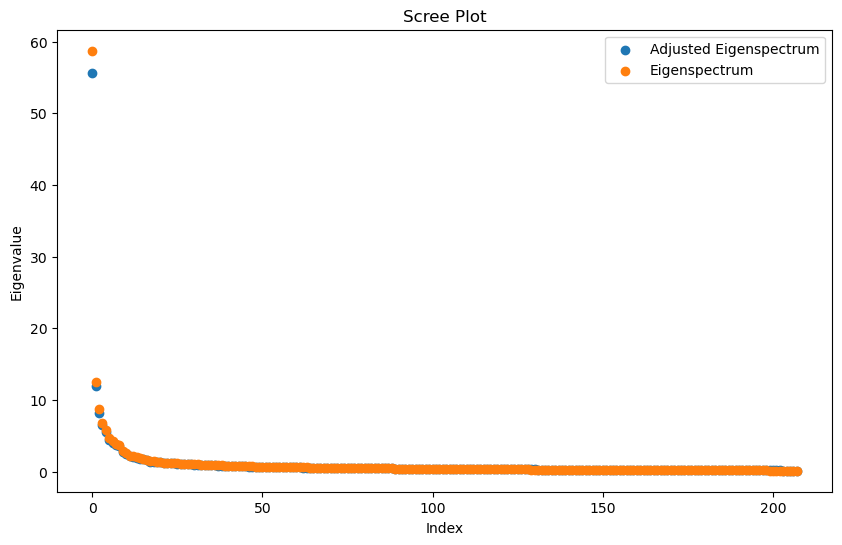

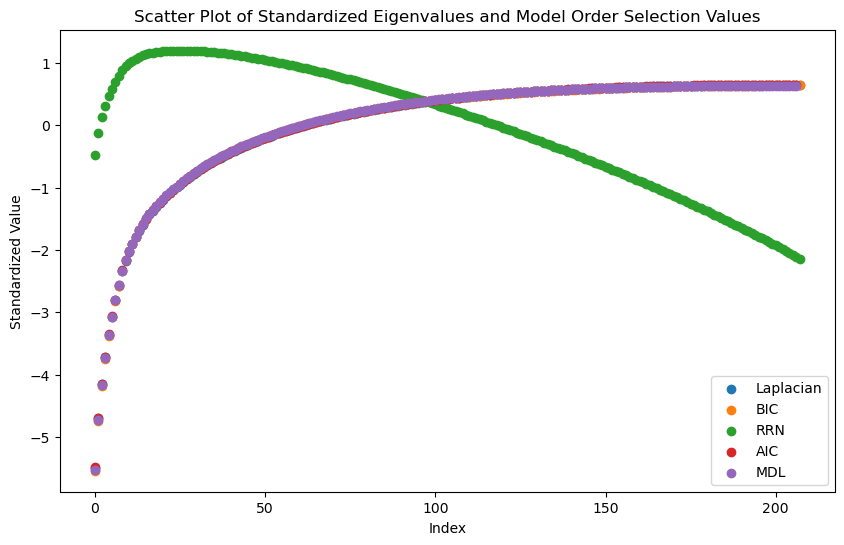

-1 28


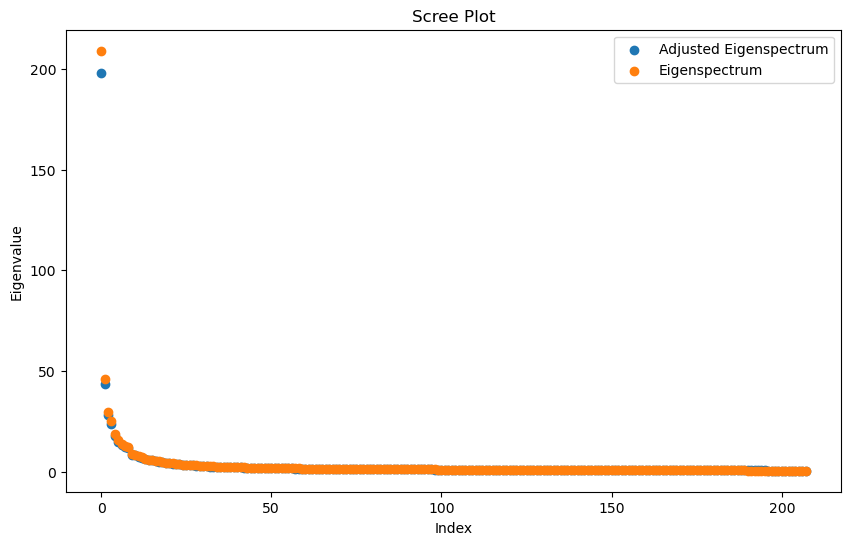

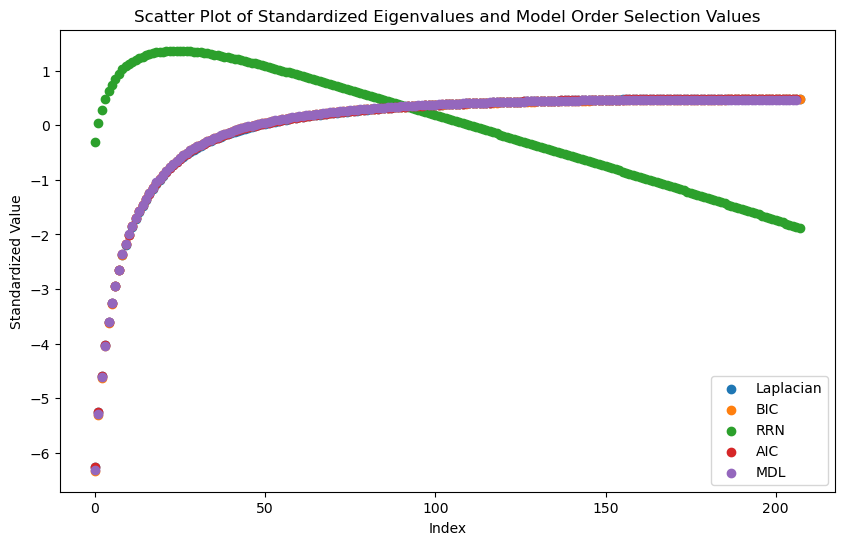

28 25


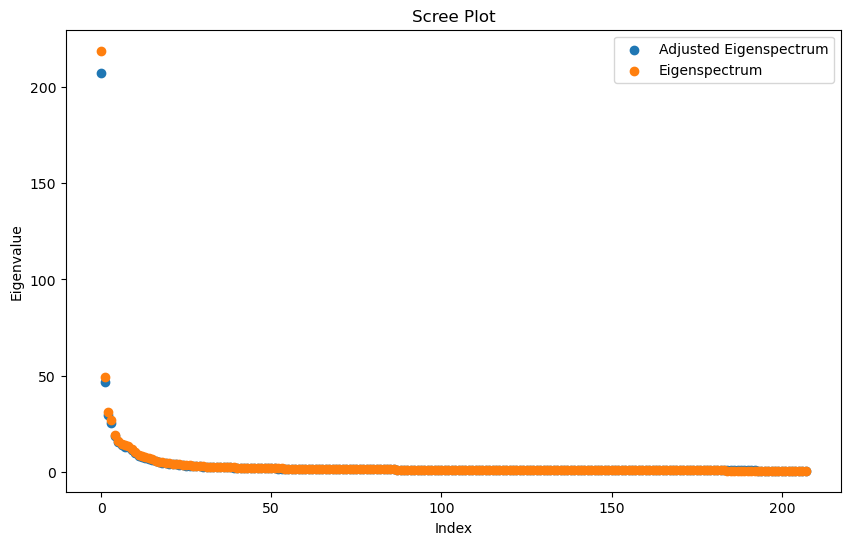

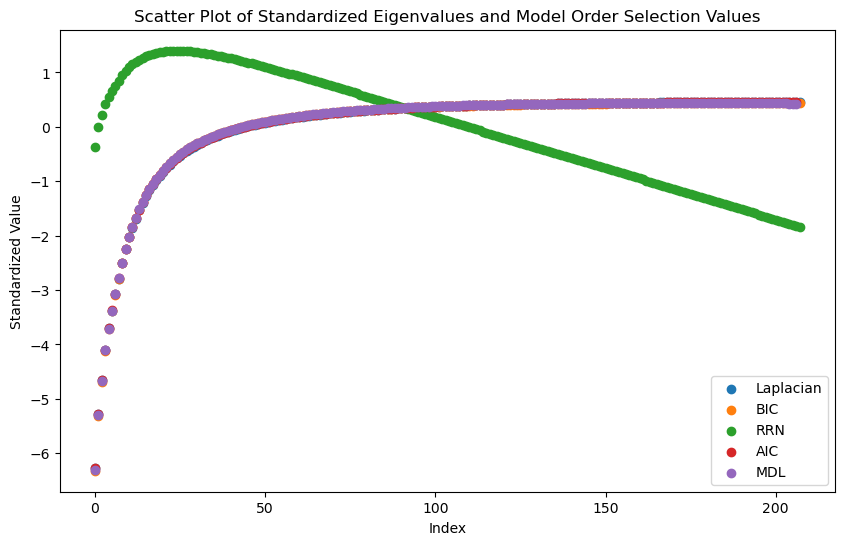

25 25
-1 -1
-1 -1
-1 -1


In [12]:
# # https://www.fmrib.ox.ac.uk/datasets/techrep/tr02cb1/tr02cb1.pdf
# # The de-meaned original data are first temporally pre-whitened using knowledge
# # about the noise covariance Σi at each voxel location. The covariance of the data is calculated from the
# # data after normalization of the voxel-wise standard deviation. In the case where spatial information
# # is available, this is encoded in the estimation of the sample covariance matrix Rx
# # https://www.sciencedirect.com/science/article/pii/S1053811912001978#bbb0005
# # https://royalsocietypublishing.org/doi/epdf/10.1098/rstb.2005.1634
# # Estimating the mixing matrix A, however, reduces to identifying the square matrix Q after whitening the data with respect to the noise covariance Si and projecting the temporally whitened observations onto the space spanned by the q eigenvectors of Rx with largest eigenvalues. The maximum likelihood estimates of sources and s are obtained using generalized least- squares 
# # remean removes the rowmean 
# # Let vector be mxn
# # mean (vectors') - returns a row of m means (one for each column m in the tranpose)
# # mean (vectors')' turns it into a column m x 1
# #  ones (1,size (vectors, 2)) creates a 1xn vector of 1s
# # meanValue * ones (1,size (vectors, 2)) creates a mxn matrix where each element in a row is the mean of the mth row 
# # newVectors = zeros (size (vectors));
# # meanValue = mean (vectors')'; transpose vectors to 
# # newVectors = vectors - meanValue * ones (1,size (vectors, 2))
# # Remove the row mean 

# # Step 1
# # Remove the column mean
# # colmean = mean(data);
# # data = remmean(data')';
# # Step 2
# # Remove the row mean
# # Step 3
# # Form the rowxrow covariance matrix and use it for PCA covarianceMatrix = cov(vectors');
# # Step 4 Use PCA to get the whitening matrix
# # Step 4.5 thrreshold whitened signal below 1.6 or arbitrary threshold
# # Step 5 reconstruct your data using the residual projecting matrix from hat matrix formed from the whitening matrix
# # Step 6 use noise reconstruction to measure variance of noise in each voxel
# # Step 7 use the above variance to variance normalize your signal
# # Step 8 remove the row mean from your data

from scipy import linalg

#     # SVD Sanity Check https://arxiv.org/pdf/2307.15213
#     # u,d,vt = np.linalg.svd(subs_data-subs_data.mean(axis=ax,keepdims=True), full_matrices=False)
#     # e = (((d/(np.sqrt(subs_data.shape[ax]-1)))**2))

#     # Perform PCA
#     # Takes in {array-like, sparse matrix} of shape (n_samples, n_features)
#     pca = PCA()
#     pca.fit(data)

#     # np.sum(np.var(subs_data@np.linalg.pinv(vt[0:1,:])@vt[0:1,:], axis=ax,ddof=1))/np.sum(np.var(subs_data,ddof=1,axis=ax))
#     # https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm

#     ax = 0
#     reconstructed = np.einsum('ik,kj->kij',np.einsum('ij,jk->ik', data, np.linalg.pinv(basis.T)),basis.T)
#     variance = (np.linalg.norm((reconstructed - reconstructed.mean(axis=(ax+1),keepdims=True)),axis=(1,2))/np.sqrt(data.shape[ax]-1))**2
#     threshold = np.min(variance)

#     # Find the number of components that explain at less than the threshold variance
#     num_components = np.argmax(pca.explained_variance_ < threshold) + 1
#     return num_components

# def get_n(data):
#     # Check the shape of the data and determine the axis for mean subtraction
#     if data.shape[0] > data.shape[1]:
#         axis = 0
#     else:
#         axis = 1
    
#     groupN = data.shape[axis] - 1
#     # Subtract the mean along the specified axis
#     data_centered = data - np.mean(data, axis=axis, keepdims=True)
    
#     # Perform SVD decomposition
#     d = linalg.svdvals(data_centered)
    
#     # Convert singular values to eigenvalues
#     e = (d ** 2) / groupN
    
#     # Determine the number of components
#     n_components = call_pca_dim(eigs=e, N=groupN)
    
#     return n_components

def get_n_and_some(data):
    # Check the shape of the data and determine the axis for mean subtraction
    if data.shape[0] > data.shape[1]:
        axis = 0
    else:
        axis = 1
    
    groupN = data.shape[axis] - 1
    # Subtract the mean along the specified axis
    data_centered = data - np.mean(data, axis=axis, keepdims=True)
    
    # Perform SVD decomposition
    u, d, vt = np.linalg.svd(data_centered,full_matrices=False)
    
    # Convert singular values to eigenvalues
    e = (d ** 2) / groupN
    
    # Determine the number of components
    n_components = call_pca_dim(eigs=e, N=groupN)
    
    return n_components, vt[:n_components,:]


def PPCA(data,filters=None, threshold=1.6, niters=10):
    # Remove column mean (mean of time series/mean of a voxel)
    data -= data.mean(axis=0,keepdims=True)
    
    n_components = -1
    n_prev = -2
    i = 0
    while n_components != n_prev and i < niters:
        n_prev = n_components
        if filters is not None:
            if niters==1:
                basis = filters.T
            # else:
            #     n_components, vt = get_n(data)
            #     basis =  np.vstack((vt, spatial_A, spatial_B))
        else:
            n_components, vt = get_n_and_some(data)
            basis = vt

        print(n_prev, n_components)
        
        if data.shape[0] > data.shape[1]:
            est_noise = data - data@np.linalg.pinv(basis)@basis
        else:
            print("This is currently not an option")

        est_residual_std = np.std(est_noise,axis=0,ddof=np.linalg.matrix_rank(basis))
        data /= est_residual_std
        i += 1

    # Get the major eigenspace from the timextime covariance
    # u = linalg.svd(data - data.mean(axis=1,keepdims=True), full_matrices=False, check_finite=False)[0]

    # Remove the row mean (mean of a time point across voxels)
    data -= data.mean(axis=1,keepdims=True)
    return data, basis

if concatenate_spatial_bases:
    subs_data, vt = PPCA(subs_data, threshold=0.0, niters=10)
    subs_data_A, _ = PPCA(subs_data_A, filters=filters_A, threshold=0.0, niters=1)
    subs_data_B, _ = PPCA(subs_data_B, filters=filters_B, threshold=0.0, niters=1)
    subs_data_com, _ = PPCA(subs_data, filters=np.hstack((vt.T,filters)), threshold=0.0, niters=1)

In [ ]:
# def PPCA(data,n=0,filters=None, threshold=1.6, niters=10):
#     # Remove column mean (mean of time series/mean of a voxel)
#     data -= data.mean(axis=0,keepdims=True)
    
#     n_components = -1
#     n_prev = -2
#     i = 0
#     while n_components != n_prev and i < niters:
#         n_prev = n_components
#         if n == 0 and filters is not None:
#             n_components = discrim_variance(data,filters)
#         elif n == 0:
#             n_components = get_n(data)
#             # n_components = call_pca_dim(Data=group_data)  # Get the number of components
#         else:
#             n_components = n

#         print(n_prev, n_components)
        
#         if data.shape[0] > data.shape[1]:
#             # Obtain low rank whitened matrix i.e. pxr
#             est_whitened_data, est_whitening_matrix = whiten(data.T, n_components, method="SVD", visualize=False)
#             # Threshold whitened_data
#             est_whitened_data[np.abs(est_whitened_data) < threshold] = 0
#             # Standardize based on noise
#             est_noise = data - (np.linalg.pinv(est_whitening_matrix)@est_whitened_data).T
#         else:
#             # Obtain low rank whitened matrix i.e. txr
#             est_whitened_data, est_whitening_matrix = whiten(data.T, n_components, method="SVD", visualize=False)
#             # Threshold whitened_data
#             est_whitened_data[np.abs(est_whitened_data) < threshold] = 0
#             # Standardize based on noise
#             est_noise = data - (np.linalg.pinv(est_whitening_matrix)@est_whitened_data)

#         est_residual_std = np.std(est_noise,axis=0,ddof=np.linalg.matrix_rank(est_whitening_matrix))
#         data /= est_residual_std
#         i += 1

#     # Remove the row mean (mean of a time point across voxels)
#     # data -= data.mean(axis=1,keepdims=True)

#     # Get the major eigenspace from the timextime covariance
#     u = linalg.svd( data - data.mean(axis=1,keepdims=True), full_matrices=False, check_finite=False)[0]

#     return data, u[:,:n_components]

# if concatenate_spatial_bases:
#     subs_data, u = PPCA(subs_data, n=0, threshold=0.0, niters=10)
#     subs_data_A, _ = PPCA(subs_data, n=0, filters=filters_A, threshold=0.0, niters=1)
#     subs_data_B, _ = PPCA(subs_data, n=0, filters=filters_B, threshold=0.0, niters=1)
# else:
#     subs_data, u = PPCA(subs_data, n=0, threshold=0.0, niters=10)


# # Remove the row mean (mean of a time point across voxels)
# # subs_data -= subs_data.mean(axis=1,keepdims=True)
# # subs_data_A -= subs_data_A.mean(axis=1,keepdims=True)
# # subs_data_B -= subs_data_B.mean(axis=1,keepdims=True)

### Project to obtain Spatial Filters

1. Debug all
2. For variance selection should I also use the same projection

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# https://www.sciencedirect.com/science/article/pii/S1053811913010914
# https://www.jmlr.org/papers/volume1/tipping01a/tipping01a.pdf
# https://proceedings.mlr.press/v48/oswal16.pdf
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2605279/
# https://fsl.fmrib.ox.ac.uk/fsl/oldwiki/attachments/DualRegression/CB09.pdf

# Expects filters that are Parcles x number of filters
# First 3 projection methods should be the same
def FKT_proj(data, filters, method="basic", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01):
    S = (data @ filters)
    
    if method == "basic":
        proj = (np.linalg.pinv(S)@ data)
    elif method == "covs":
        cov_est_scm = Covariances(estimator='scm')
        s_cov = cov_est_scm.transform(S.T[np.newaxis,:,:])[0,:,:]
        data_cov = cov_est_scm.transform(data.T[np.newaxis,:,:])[0,:,:]
        proj = (data_cov @ filters @ np.linalg.inv(s_cov)).T
    elif method == "linreg":
        reg = LinearRegression()
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "grouplassolinreg":
        reg = MultiTaskLasso(alpha=alpha)  # Using 5-fold cross-validation
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "lassolinreg":
        reg = Lasso(alpha=alpha)  # Using 5-fold cross-validation
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "elasticlinreg":
        reg = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        reg.fit(S, data)
        proj = reg.coef_.T
    elif method == "growl":
        # Proximal Operator for GrOWL targeting columns
        def prox_growl(V, lambda1, lambda2, tau):
            p, r = V.shape
            norms = np.linalg.norm(V, axis=0)  # Norms of columns
            indices = np.argsort(-norms)  # Sort indices by descending norms
            weights = lambda1 + lambda2 * np.linspace(1, 0, r)  # Weights decrease
            V_new = np.zeros_like(V)
            for i in range(r):
                idx = indices[i]
                if norms[idx] > weights[i] * tau:
                    V_new[:, idx] = (1 - tau * weights[i] / norms[idx]) * V[:, idx]
            return V_new
        
        # Initialization
        B = np.zeros((filters.shape[1], data.shape[1]))
        
        # Optimization Loop
        max_iter = 100
        learning_rate = 0.01
        for _ in range(max_iter):
            gradient = S.T @ (S @ B - data)
            B -= learning_rate * gradient
            B = prox_growl(B, lambda1, lambda2, tau=learning_rate)
            if np.linalg.norm(gradient) < 1e-1:
                break
        
        proj = B.T
    
    return proj

def compare_basis(x, basis):
    # Normalize the columns of x and basis
    x_normalized = x/np.linalg.norm(x, axis=0, keepdims=True)
    basis_normalized = basis/np.linalg.norm(basis, axis=0, keepdims=True)

    # Calculate cosine similarity
    cos_sim = cosine_similarity(x_normalized.T, basis_normalized.T)
    if x_normalized.shape[1] != basis_normalized.shape[1]:
        x_normalized = x_normalized[:,np.argmax(np.abs(cos_sim),axis=0)]

    # Plot heatmaps for cosine similarities
    plt.figure()
    sns.heatmap(cos_sim, cmap='viridis')
    plt.title('Cosine Similarity')
    plt.show()
    
    # Calculate the covariance matrix after whitening
    covariance_matrix = ((x_normalized - x_normalized.mean(axis=0,keepdims=True)).T @ (basis_normalized - basis_normalized.mean(axis=0,keepdims=True))) / (basis_normalized.shape[1] - 1)
    
    # Calculate the difference matrix
    difference_matrix = (x_normalized - basis_normalized * np.sign(np.diag(covariance_matrix)))
    
    # Plot heatmaps for differences
    plt.figure()
    sns.heatmap(difference_matrix, cmap='viridis')
    plt.title('Difference Matrix Heatmap')
    plt.show()
    
    # Scatter plot of the difference matrix
    plt.figure()
    for i in range(difference_matrix.shape[1]):
        plt.scatter(np.arange(difference_matrix.shape[0]), difference_matrix[:, i], label=f'Column {i+1}')
    plt.xlabel('Index')
    plt.ylabel('Difference Value')
    plt.title('Difference Matrix Scatter Plot')
    plt.legend()
    plt.show()

    # Plot normalized x and basis
    plt.figure()
    sns.heatmap(x_normalized, cmap='viridis')
    plt.title('Normalized Projected Spatial Heatmap')
    plt.show()
    
    plt.figure()
    sns.heatmap(basis_normalized, cmap='viridis')
    plt.title('Normalized Basis Heatmap')
    plt.show()

# Columns are samples i.e. XXT is the covariance matrix formed
def whiten(X,n_components, method="SVD", visualize=False):
    # -1 to account for demean
    n_samples = X.shape[-1]-1

    X_mean = X.mean(axis=-1)
    X -= X_mean[:, np.newaxis]

    if method == "SVD":
        u, d = linalg.svd(X, full_matrices=False, check_finite=False)[:2]
        # Give consistent eigenvectors for both svd solvers
        u *= np.sign(u[0])
        K = (u / d).T[:n_components]  # see (6.33) p.140
        del u, d
        whitening_matrix = np.sqrt(n_samples)*K
    elif method == "Cholesky":
    # Does not Orthogonalize, just has unit covariance
        # Step 2: Perform Cholesky decomposition
        L = np.linalg.cholesky(np.cov(X,ddof=1))
        # Step 3:
        whitening_matrix = np.linalg.inv(L)
    elif method == "InvCov":
        # Calculate the covariance matrix of the centered data
        cov_matrix = np.cov(X)
        # Perform eigenvalue decomposition of the covariance matrix
        eigvals, eigvecs = np.linalg.eigh(cov_matrix)
        # Calculate the whitening matrix
        D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals))
        whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T
    elif method == "QR":
        Q, R = QR(X.T)
        whitening_matrix = np.sqrt(n_samples)*np.linalg.pinv(R.T)

    whitened_data = whitening_matrix@X
    
    if visualize: 
        plt.figure()
        sns.heatmap(whitened_data, cmap='viridis')
        plt.title('whitened_data')

        plt.figure()
        sns.heatmap(np.cov(whitened_data,ddof=1), cmap='viridis')
        plt.title('Covariance Matrix of Whitened Components')

        # Step 4: Visualize the whitened data
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Plot original projected data
        ax[0].scatter(X[0,:], X[-1,:], c='blue', alpha=0.5)
        ax[0].set_title('Projected Data')
        ax[0].set_xlabel('Component 1')
        ax[0].set_ylabel('Component 2')
        ax[0].axis('equal')

        # Plot whitened data
        ax[1].scatter(whitened_data[0, :], whitened_data[-1, :], c='red', alpha=0.5)
        ax[1].set_title('Whitened Data')
        ax[1].set_xlabel('Component 1')
        ax[1].set_ylabel('Component 2')
        ax[1].axis('equal')

        plt.tight_layout()
        plt.show()

    return whitened_data, whitening_matrix


In [ ]:
# Spatial Filters Unwhitened
print("Unwhitened")
spatial_filters_A = FKT_proj(subs_data_A, filters_A, method="basic", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
spatial_filters_B = FKT_proj(subs_data_B, filters_B, method="basic", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
combined_discrim = np.vstack((spatial_filters_A, spatial_filters_B)).T
compare_basis(combined_discrim, filters)

# Spatial Filters Whitened
print("Whitened via Inverse Covariance")
inv_cov_data, _ = whiten(combined_discrim.T,n_components=combined_discrim.T.shape[0], method="InvCov",visualize=False)
compare_basis(inv_cov_data.T, filters)

print("Whitened via SVD")
svd_data, _ = whiten(combined_discrim.T,n_components=combined_discrim.T.shape[0], method="SVD",visualize=False)
compare_basis(svd_data.T, filters)

print("Whitened via QR")
QR_data, _ = whiten(combined_discrim.T,n_components=combined_discrim.T.shape[0], method="InvCov",visualize=False)
compare_basis(QR_data.T, filters)

# Check to make sure all 3 methods are the same
alt_A = FKT_proj(subs_data_A, filters_A, method="covs", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
alt_B = FKT_proj(subs_data_B, filters_B, method="covs", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
combined_alt= np.vstack((alt_A, alt_B)).T

alt_A2 = FKT_proj(subs_data_A, filters_A, method="linreg", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
alt_B2 = FKT_proj(subs_data_B, filters_B, method="linreg", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
combined_alt2= np.vstack((alt_A2, alt_B2)).T

print(np.isclose(combined_discrim,combined_alt).all())
print(np.isclose(combined_discrim,combined_alt2).all())
print(np.isclose(combined_alt,combined_alt2).all())

In [ ]:
combined_basis = np.vstack((vt, spatial_filters_A, spatial_filters_B)).T

# Spatial Filters Whitened
print("Whitened via Inverse Covariance")
inv_cov_data_all, _ = whiten(combined_basis.T,n_components=combined_basis.T.shape[0], method="InvCov",visualize=True)
compare_basis(inv_cov_data_all.T, filters)

print("Whitened via SVD")
svd_data_all, _ = whiten(combined_basis.T,n_components=combined_basis.T.shape[0], method="SVD",visualize=True)
compare_basis(svd_data_all.T, filters)

print("Whitened via QR")
QR_data_all, _ = whiten(combined_basis.T,n_components=combined_basis.T.shape[0], method="InvCov",visualize=True)
compare_basis(QR_data_all.T, filters)

### Combine Basis, Orthonormalize Basis, and Spatial Projection (REVIST INCOMPLETE)

1. Check PCA (I think they are all condensed because they come from an eigenvalue decomposition)
2. Did I calculate the PseudoPCA/combined_eigenvalues correctly
3. Should I demean the filters or the combined data (done above)
4. Double check fkt filters are orthonormal before they are input
5. Check how order (order of filters input into QR decomposition) of Orthonormalization is affects resuls - doesnt make a difference no longer orthonormal due to projection
6. Which way to run the PCA/SVD and number of components to include in model order selection
7. Use eigh or svd dependning on diemsnions and dont use PCA to get the eigenvectors
8. Should I demean anything before projecting that isnt demeaned

In [14]:
def combine_basis(group_data, vt, fkt_basis,spatial=False, data_A=None,data_B=None, A=None, B=None):    
    if spatial:
        spatial_filters_A = FKT_proj(data_A, A, method="basic", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
        spatial_filters_B = FKT_proj(data_B, B, method="basic", alpha=1, beta=0, l1_ratio=0.5, lambda1=.01, lambda2=.01)
        combined_spatial = np.vstack((vt,spatial_filters_A, spatial_filters_B))
        Q = None
    else:
        print("Not yet implemented; coming soon or never...")
    return combined_spatial, Q

combined_spatial, combined_basis = combine_basis(subs_data,vt, filters, spatial=concatenate_spatial_bases, data_A=subs_data_A, data_B=subs_data_B,A=filters_A, B=filters_B)

In [ ]:
# def combine_basis(group_data, u, fkt_basis,spatial=False, data_A=None,data_B=None, A=None, B=None):    
#     if spatial:
#         spatial_A = (np.linalg.pinv(np.linalg.pinv(data_A.T) @ A)@data_A)
#         spatial_B = (np.linalg.pinv(np.linalg.pinv(data_B.T) @ B)@data_B)
#         spatial_group = np.linalg.pinv(u)@group_data
#         combined_spatial = np.vstack((spatial_group, spatial_A, spatial_B))
#         Q = None
#     else:
#         # Project fkt_basis onto the row space of group_data
#         proj_fkt_basis = np.linalg.pinv(group_data.T) @ fkt_basis
#         # Combine PCA components with projected fkt_basis
#         combined_basis = np.hstack((u, proj_fkt_basis))
#         # QR decomposition
#         Q, _ = QR(combined_basis,visualize=False)
#         combined_spatial = np.linalg.pinv(Q)@(group_data)
#     return combined_spatial, Q

# combined_spatial, combined_basis = combine_basis(subs_data,u, filters, spatial=concatenate_spatial_bases, data_A=subs_data_A, data_B=subs_data_B,A=filters_A, B=filters_B)

### ICA (REVIST/INCOMPLETE)

1. Adding Meamn/Whitening Correctly?
2. Whiten correctly so converges in all cases

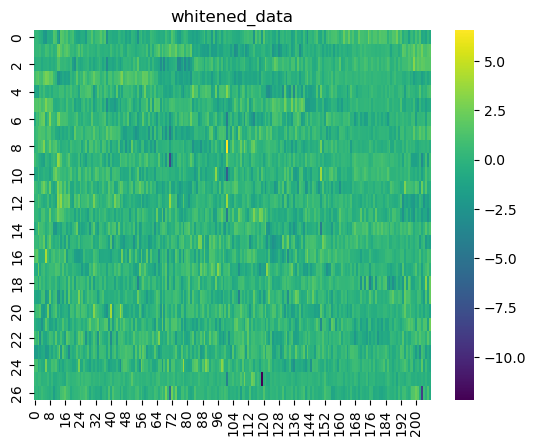

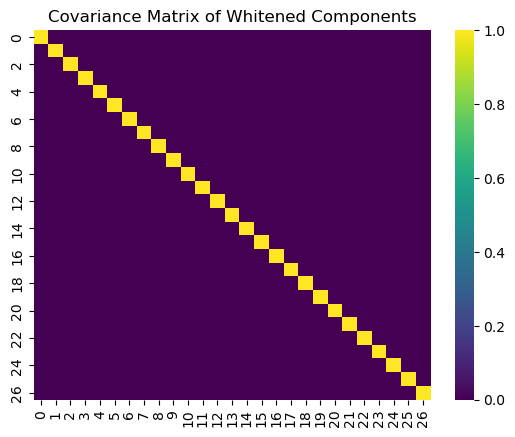

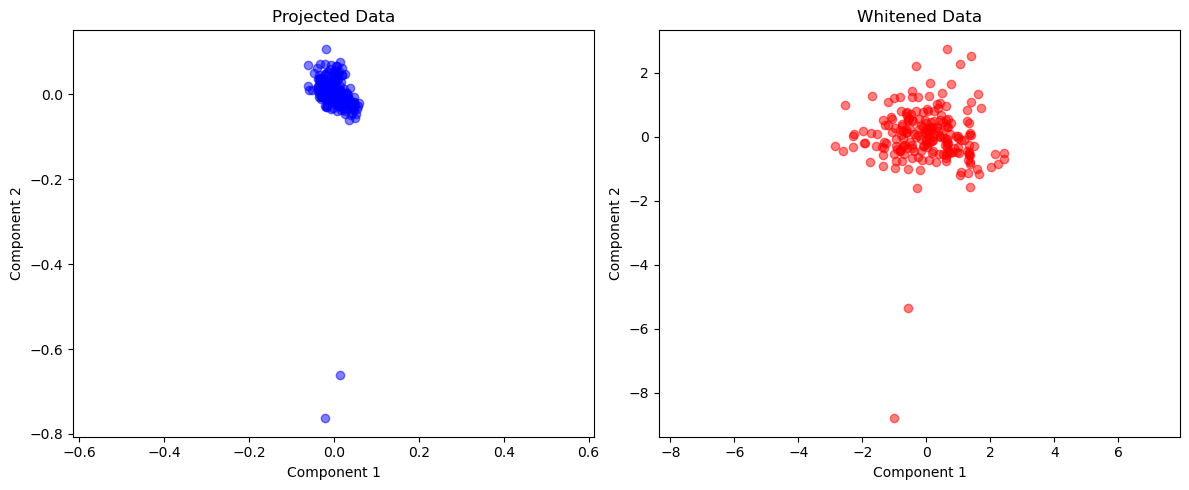

The combined unmixing matrix correctly calculates the components:  False


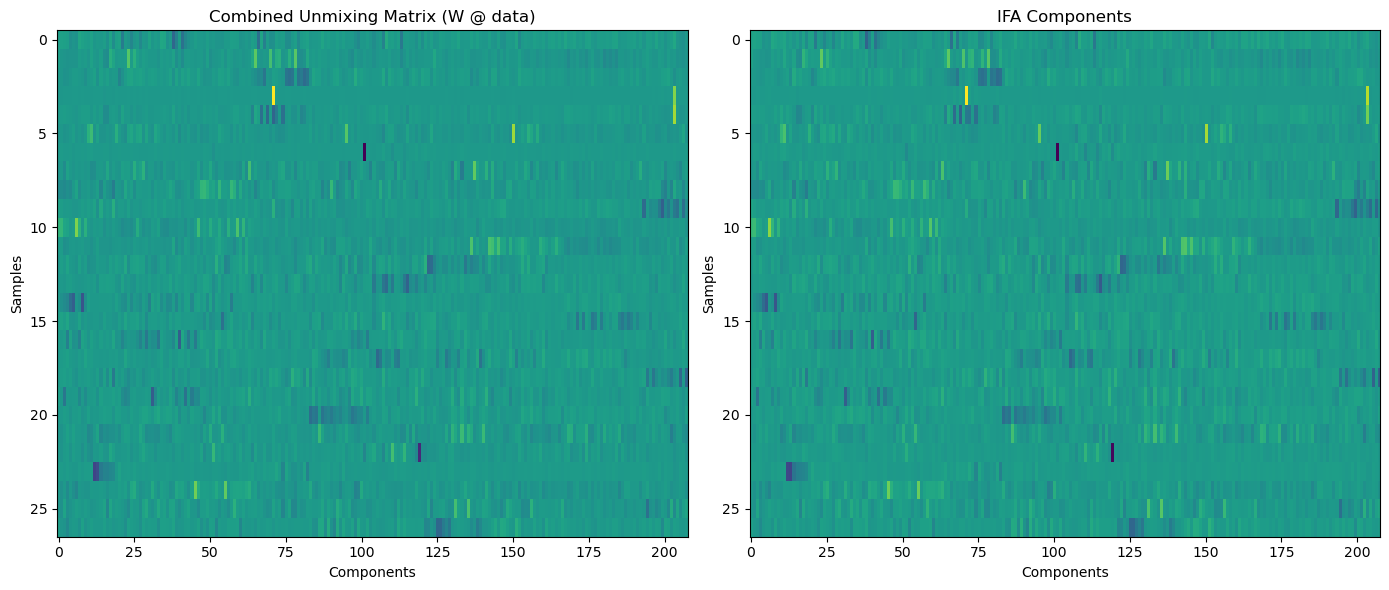

The combined mixing matrix correctly reconstructs the low rank data:  False


In [15]:
def ICA(data,projected_data,basis=None,method="SVD"):
    # https://www.fmrib.ox.ac.uk/datasets/techrep/tr01mj2/tr01mj2.pdf
    whitened_data, whitening_matrix = whiten(projected_data,n_components=projected_data.shape[0],method=method,visualize=True)
    ica = FastICA(whiten=False)
    IFA_components = ica.fit_transform(whitened_data.T).T
    if basis is not None:
        Q = ica.components_
        A = basis@np.linalg.pinv(Q)
        W = np.linalg.pinv(A)
    else:
        A = (data)@np.linalg.pinv(IFA_components)
        W = np.linalg.pinv(A)

    print("The combined unmixing matrix correctly calculates the components: ", np.allclose(W@(data - data.mean(axis=-1,keepdims=True)), IFA_components))
    # Create heat maps for the matrices
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Heat map for the combined unmixing matrix
    axes[0].imshow(W@(data - data.mean(axis=-1,keepdims=True)), aspect='auto', cmap='viridis')
    axes[0].set_title('Combined Unmixing Matrix (W @ data)')
    axes[0].set_xlabel('Components')
    axes[0].set_ylabel('Samples')

    # Heat map for the IFA components
    axes[1].imshow(IFA_components, aspect='auto', cmap='viridis')
    axes[1].set_title('IFA Components')
    axes[1].set_xlabel('Components')
    axes[1].set_ylabel('Samples')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    print("The combined mixing matrix correctly reconstructs the low rank data: ", np.allclose(A@IFA_components + A@(W@np.mean(data,axis=1,keepdims=True)), A@(W@(data - np.mean(data,axis=1,keepdims=True))) + A@(W@np.mean(data,axis=1,keepdims=True))))

    return IFA_components, A, W

raw_components_combined, A_combined, W_combined = ICA(subs_data_com,combined_spatial,basis=combined_basis, method="InvCov")

# raw_components_combined, A_combined, W_combined = ICA(combined_filters,subs_data,method="SVD")
# raw_components_discrim, A_discrim, W_discrim = ICA(whitened_data_discrim,discrim_eigs,discrim_base,subs_data)
# raw_components_major, A_major, W_major = ICA(whitened_data_major,major_eigs,major_eigenvectors.T,all_subjects_reduced)


### Create Z maps Threshhold and Visualize (Revist Incomplete)

1. Threshold level
2. FDR/correction method (within each  zmap or also between )
3. Divide by noise var or noise std?
4. Correct way to calculate p values
5. Intuition for Z scores
6. Correct way to calculate noise
6. 1. Divide by n-1 or n-m
6. 2. WTW pinv(W)W
7. When calculating the noise should i spatially demean first

In [16]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm

def noise_projection(W,data, visualize=True):

    Signals = np.linalg.pinv(W)@(W@data)
    Residuals = data - Signals
    residual_std = np.std(Residuals,axis=0,ddof=np.linalg.matrix_rank(W))
    # Trace of I-pinv(W)(W) is equal to the nullity (n-m gvien n > m) of the reconstructed matrix 
    # trace = data.shape[0] - np.linalg.matrix_rank(W)
    # residual_std2 = (np.einsum('ij,ij->j', Residuals, Residuals)/(trace))**.5


    if visualize:
        n=50
        plt.figure()
        plt.plot(Signals[:n,0:1])
        plt.plot(Residuals[:n,0:1])
        plt.plot(data[:n,0:1])
        plt.plot(data[:n,0:1] - (Signals[:n,0:1]+Residuals[:n,0:1]))
        plt.legend(['Signal','Noise', 'Data' ,'Reconstruction Error'])
        plt.title("Calculations based on pinv(W)W Projection Matrix")
        plt.show()

        plt.scatter(range(0,residual_std.shape[0]), residual_std)
        plt.title("Noise std Per Voxel based on pinv(W)W Projection Matrix")
        plt.show()

        # plt.scatter(range(0,residual_std2.shape[0]), residual_std2)
        # plt.title("Noise Variance Per Voxel based on pinv(W)W Projection Matrix Normalized by N-rank(m)")
        # plt.show()

    return residual_std


def threshold_and_visualize(data, W, components, atlas, save_images=True, folder_name="output"):
    
    # Create the folder or overwrite if it exists
    if save_images:
        if os.path.exists(folder_name):
            for file in os.listdir(folder_name):
                file_path = os.path.join(folder_name, file)
                try:
                    if os.path.isfile(file_path):
                        os.unlink(file_path)
                except Exception as e:
                    print(e)
        else:
            os.makedirs(folder_name)
    
    voxel_noise = noise_projection(W,data)[:, np.newaxis]
    z_scores_array = np.zeros_like(components)

    # Process each filter individually
    for i in range(components.shape[1]):
        z_score = ((components[:, i:i+1]))/voxel_noise
        # P(Z < -z \text{ or } Z > z) = (1 - \text{CDF}(z)) + (1 - \text{CDF}(z)) = 2 \times (1 - \text{CDF}(z))
        p_values = 2 * (1 - norm.cdf(np.abs(z_score)))
        # Apply multiple comparisons correction for the current filter https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
        reject, pvals_corrected, _, _ = multipletests(p_values.flatten(), alpha=0.05, method='fdr_bh')
        masked_comp = z_score*(reject[:,np.newaxis])
        # print(masked_comp, reject[:,np.newaxis],z_score)
        z_scores_array[:, i:i+1] = masked_comp
        significant_voxels = np.where(reject)[0] + 1
        
       
       # Skip the iteration if there are no significant values
        if not np.any(reject):
            print(f'Component {i} did not contain any significant values')
            plt.figure()
            plt.hist(z_score, bins=30, color='blue', alpha=0.7)
            plt.title(f"Histogram for Filter {i} NO SIGNIFICANT VALUES")
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            if save_images:
                plt.savefig(os.path.join(folder_name, f"histogram_no_significant_values_filter_{i}.png"))
            plt.show()
        else:
            # Create a figure and axes for subplots (1 row of 2 plots per filter)
            fig, axes = plt.subplots(1, 2, figsize=(18, 10))

            ax_hist1 = axes[0]
            ax_img = axes[1]

            # Plot the histogram of the current filter
            ax_hist1.hist(z_score, bins=30, color='blue', alpha=0.7)
            ax_hist1.set_title(f"Histogram for Filter {i}")
            ax_hist1.set_xlabel('Value')
            ax_hist1.set_ylabel('Frequency')
            
            # Generate the brain image mask using the significant indices
            outer_product = masked_comp @ masked_comp.T

            # Plot the outer product image on the corresponding subplot
            im = ax_img.imshow(outer_product, aspect='auto', cmap='viridis', origin='lower')
            ax_img.set_title(f"Outer Product for Filter {i}")
            fig.colorbar(im, ax=ax_img, label='Amplitude')

            plt.tight_layout()
            if save_images:
                plt.savefig(os.path.join(folder_name, f"histogram_and_outer_product_filter_{i}.png"))
            plt.show()

            # Create ROI mask for significant voxels
            roi = ' | '.join([f'(a == {num})' for num in significant_voxels])
            final_string = f"(({roi}))"
            roi_mask = nimg.math_img(final_string, a=atlas)
            
            # Plot the ROI with nilearn and add a title
            display = nplot.plot_roi(roi_mask, cmap='jet')
            display.title(f"Region of Interest Mask for Filter {i}")
            if save_images:
                display.savefig(os.path.join(folder_name, f"roi_mask_filter_{i}.png"))
            plt.show()

    return z_scores_array

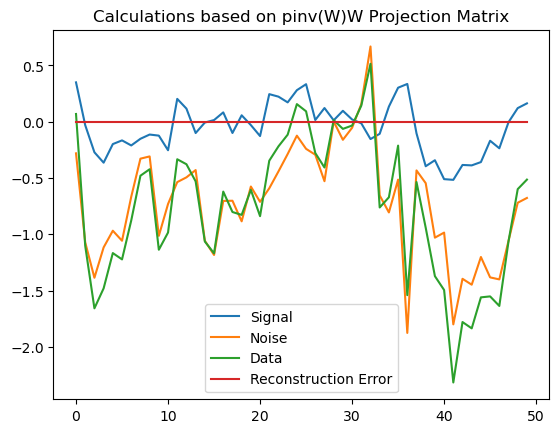

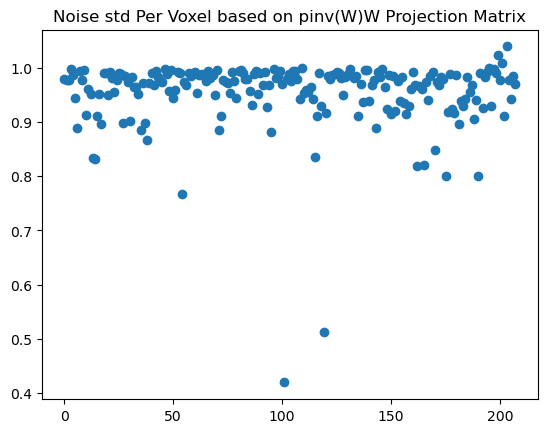

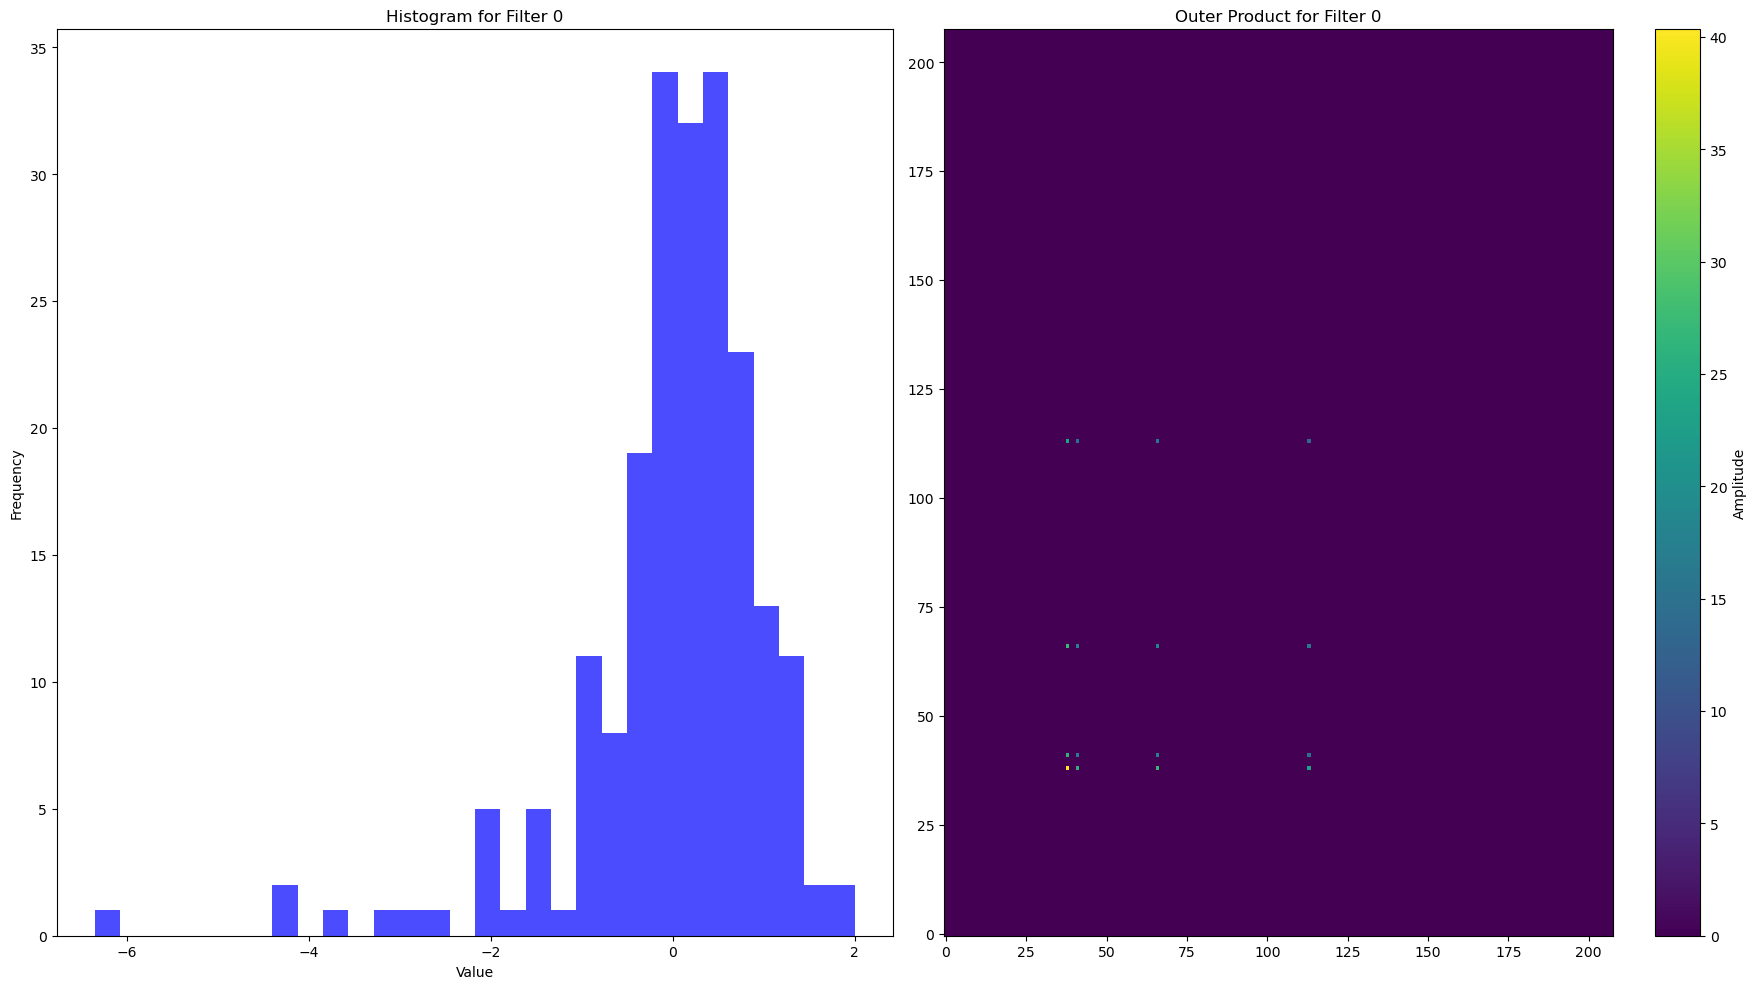

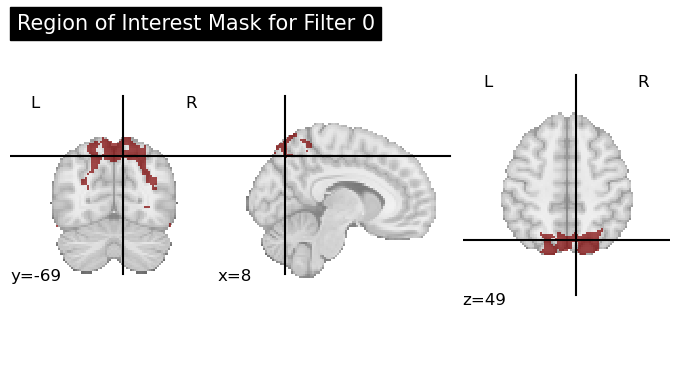

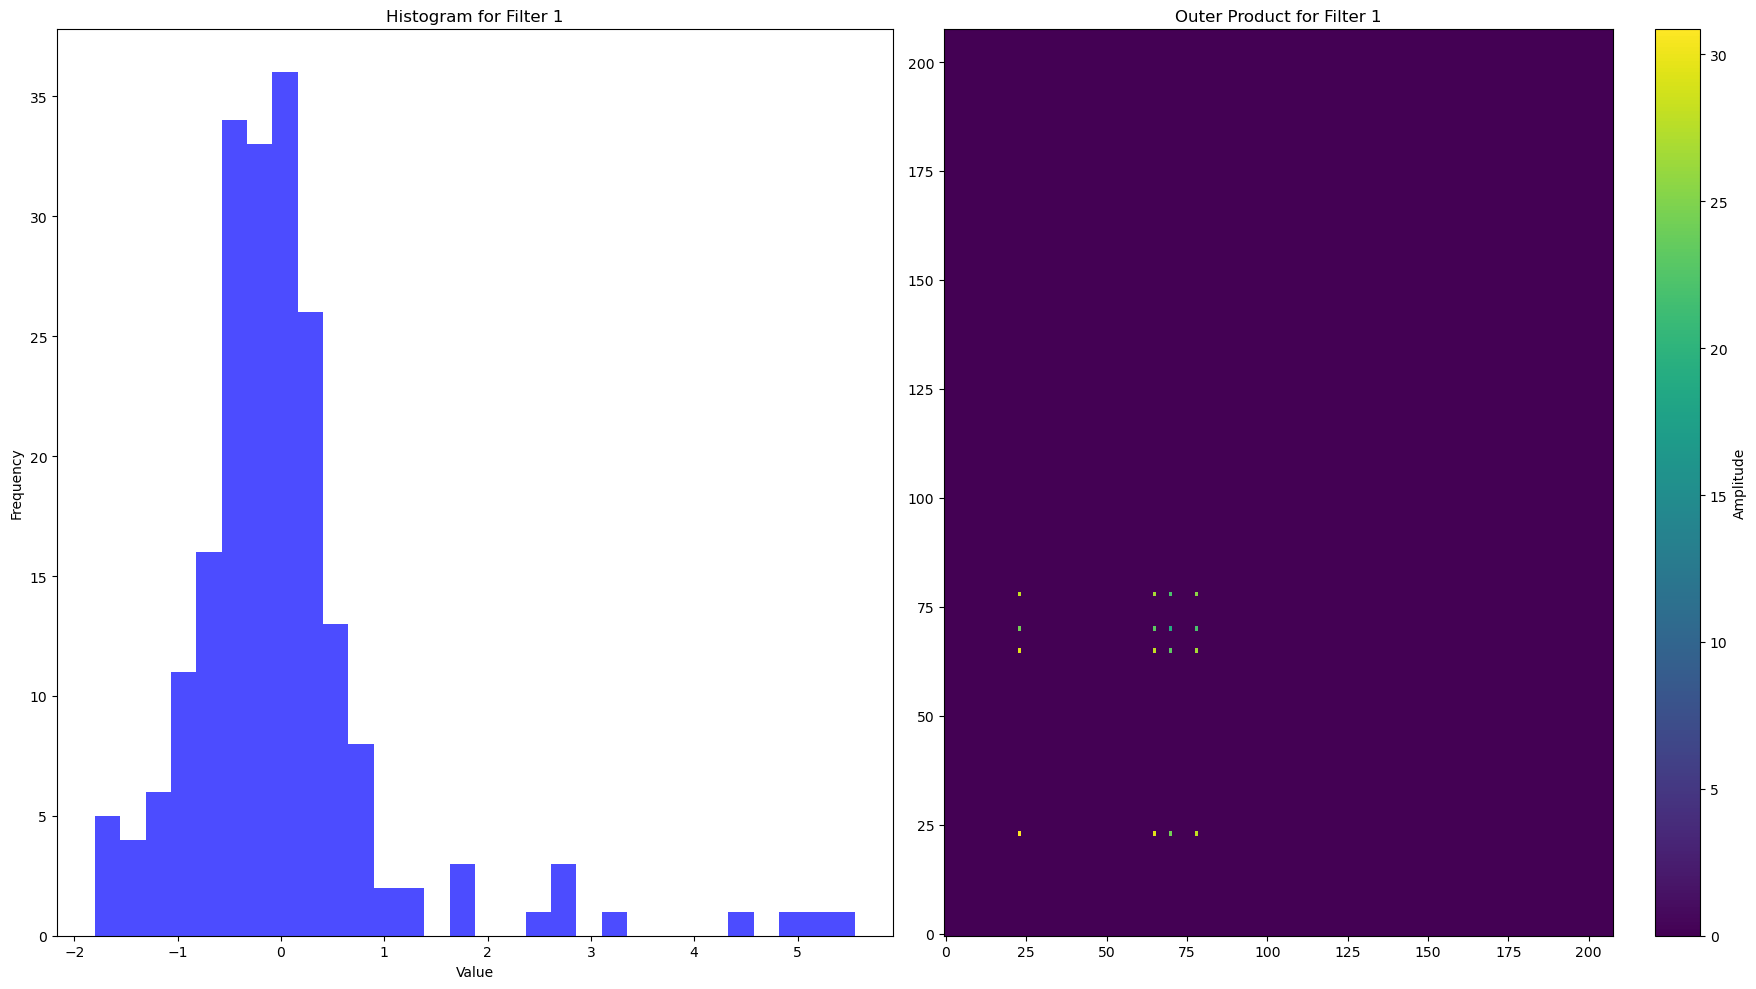

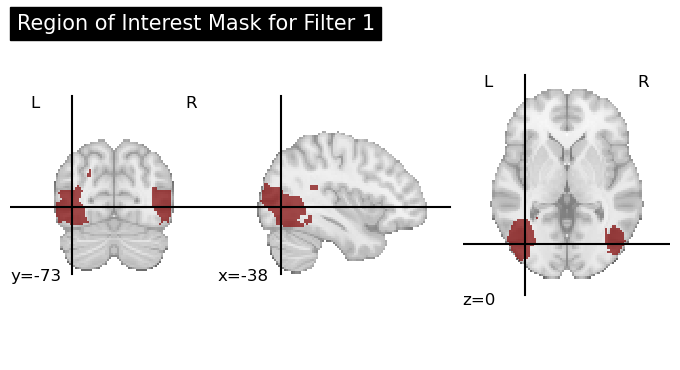

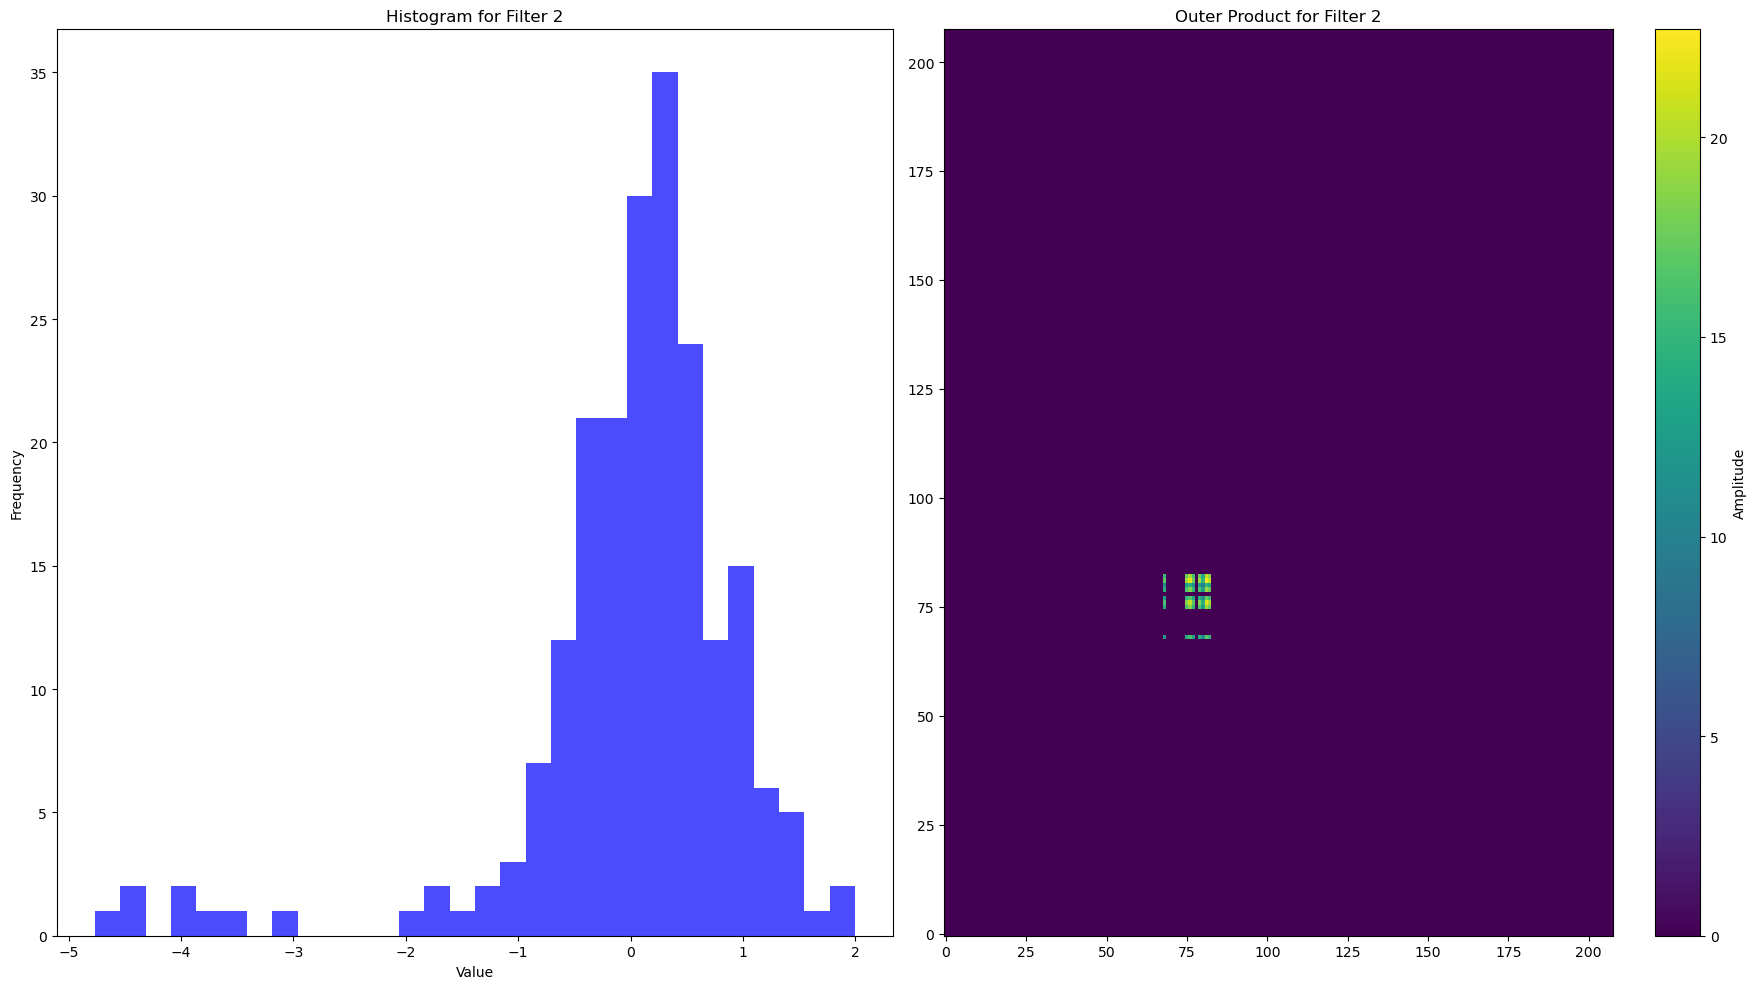

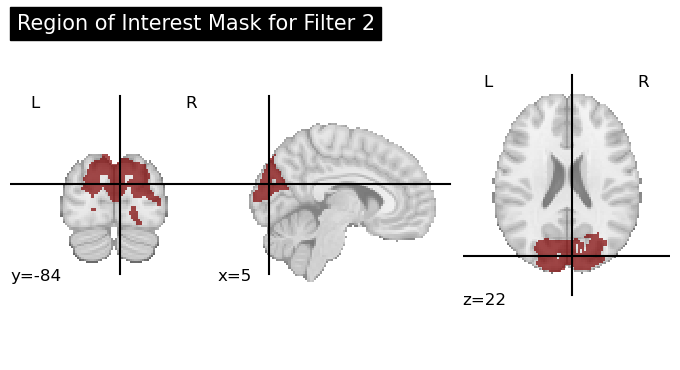

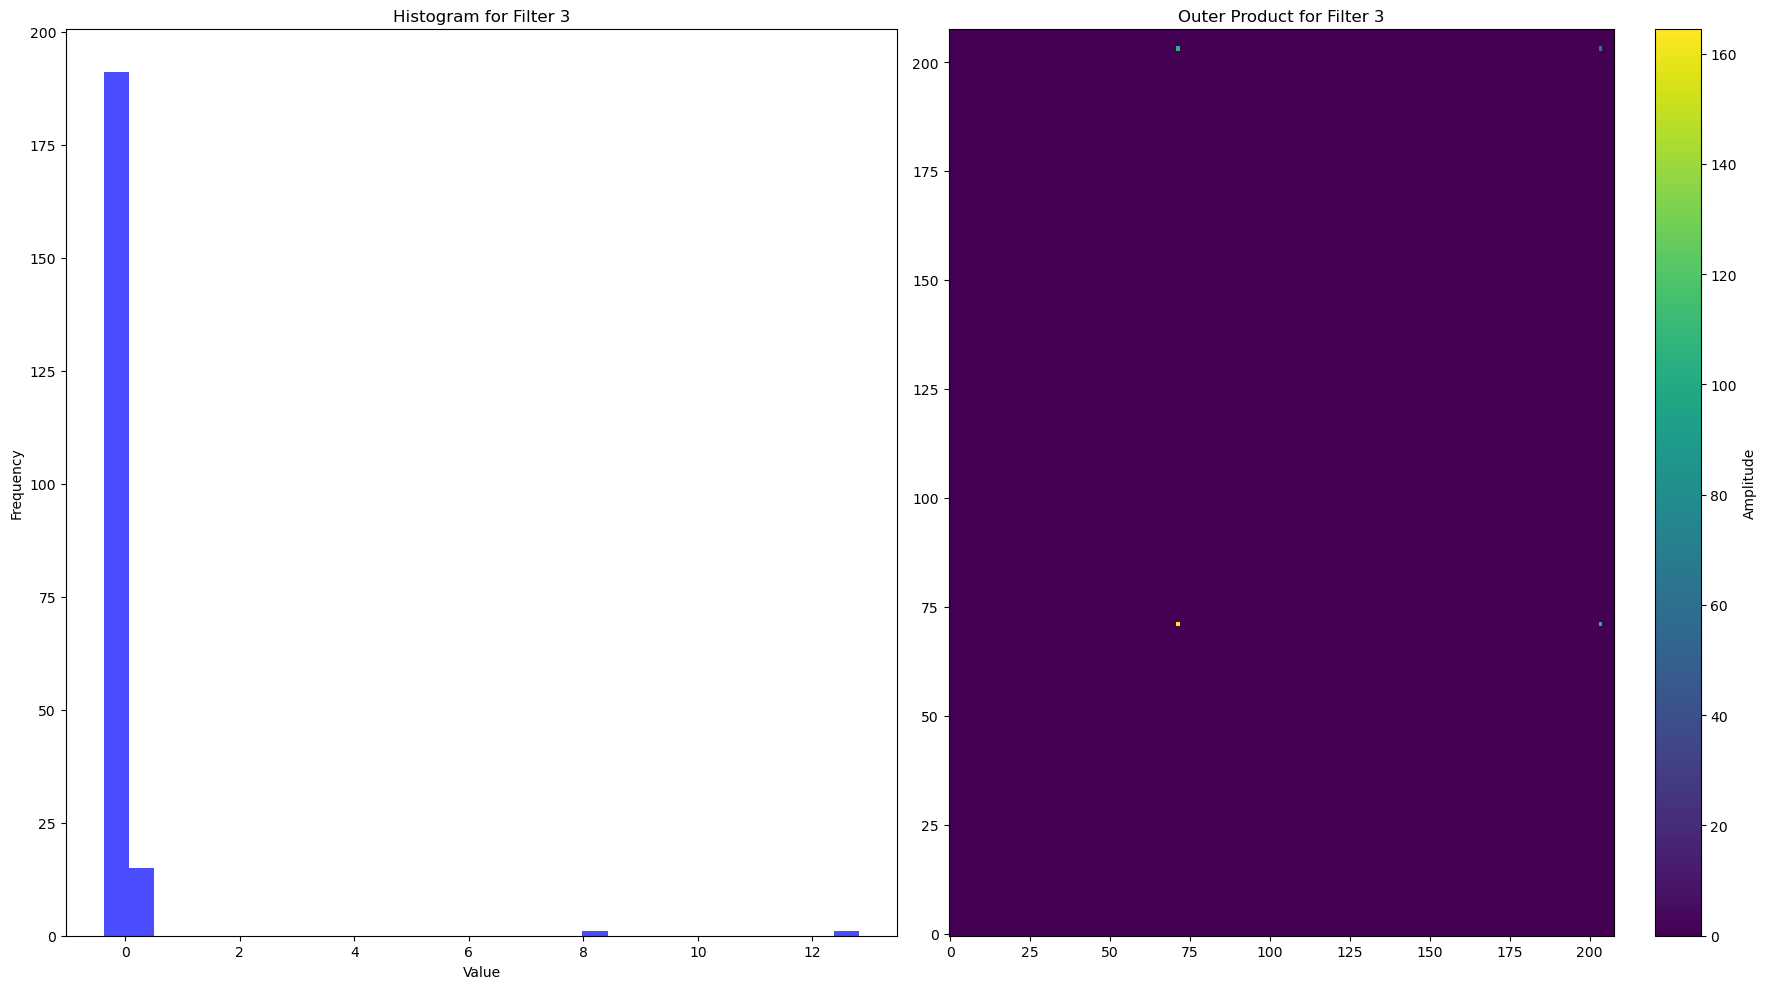

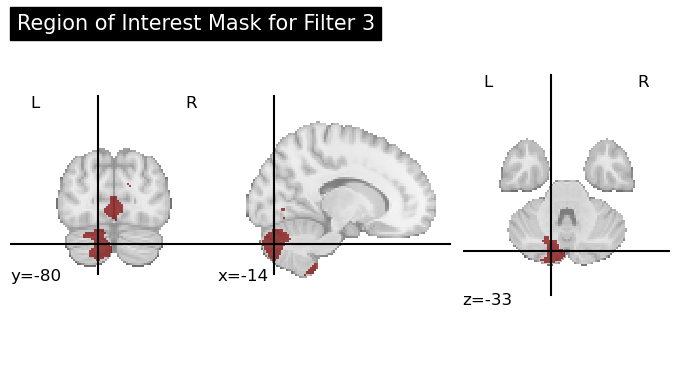

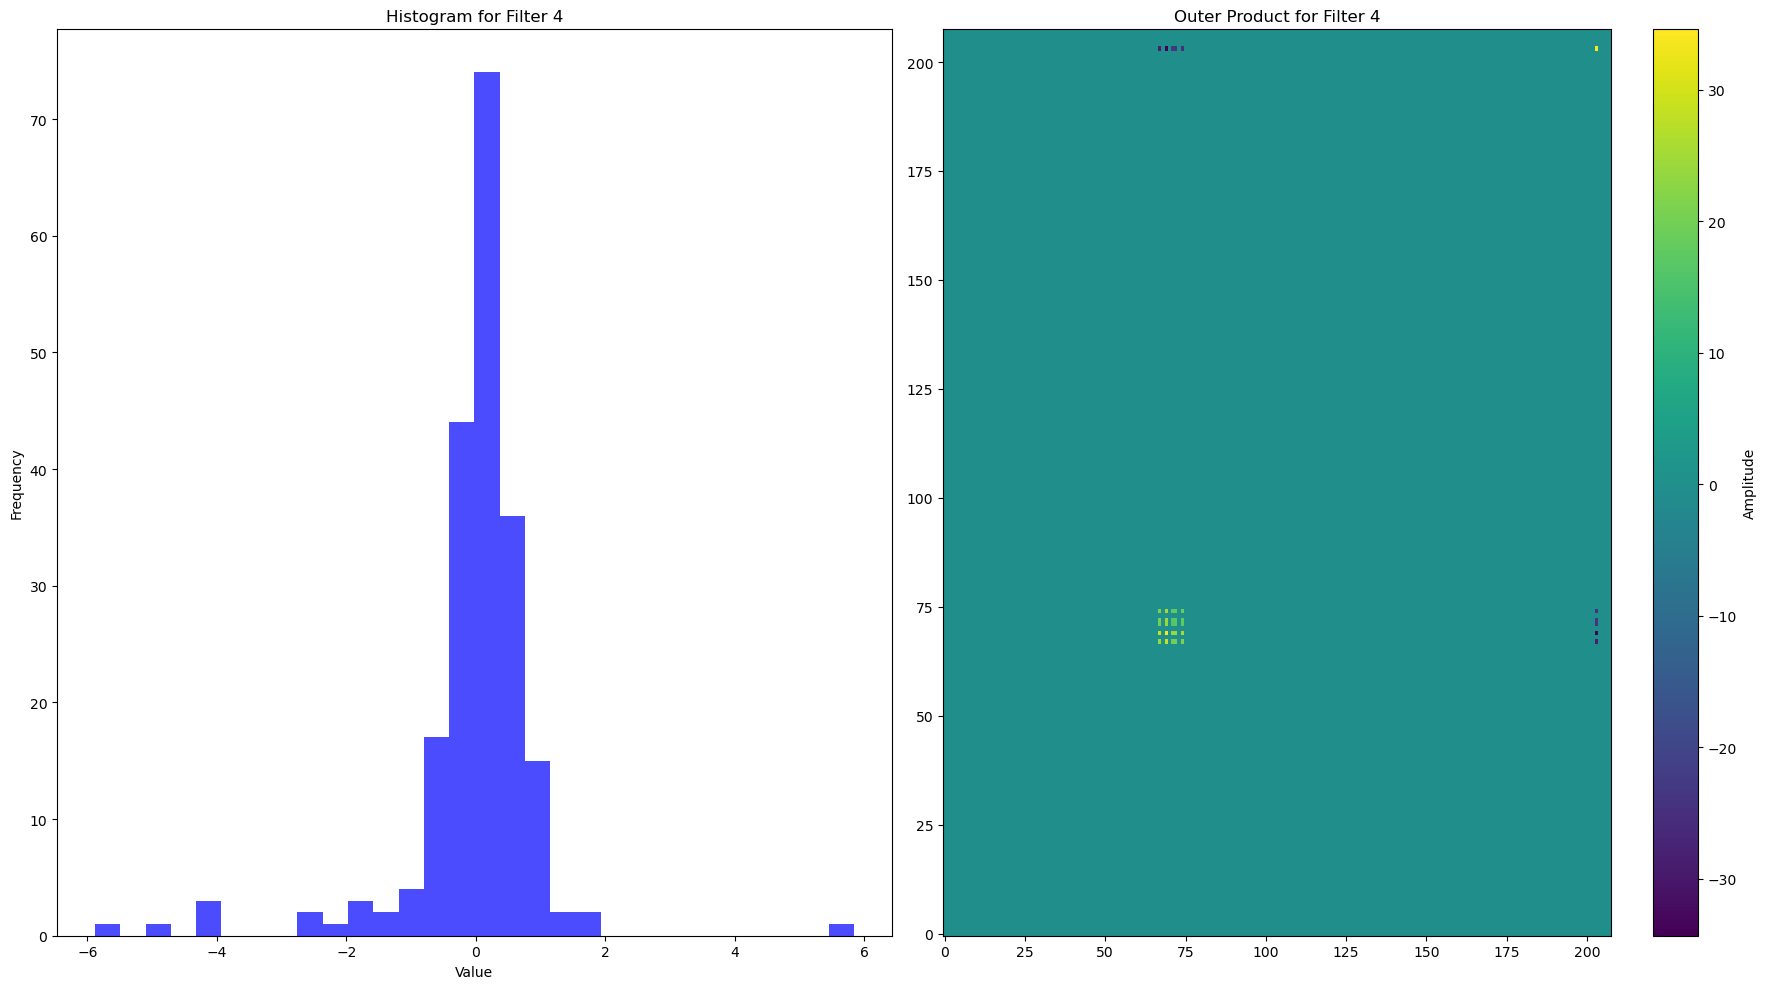

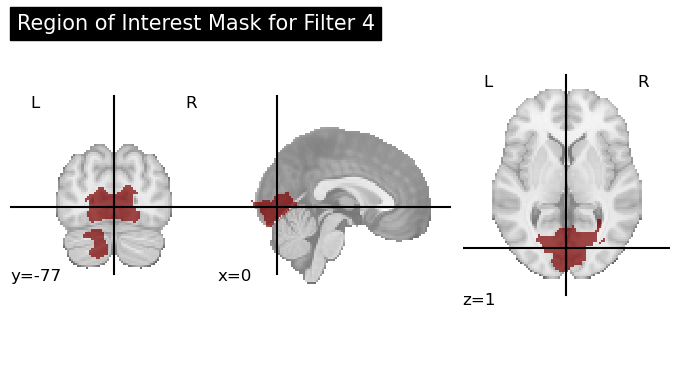

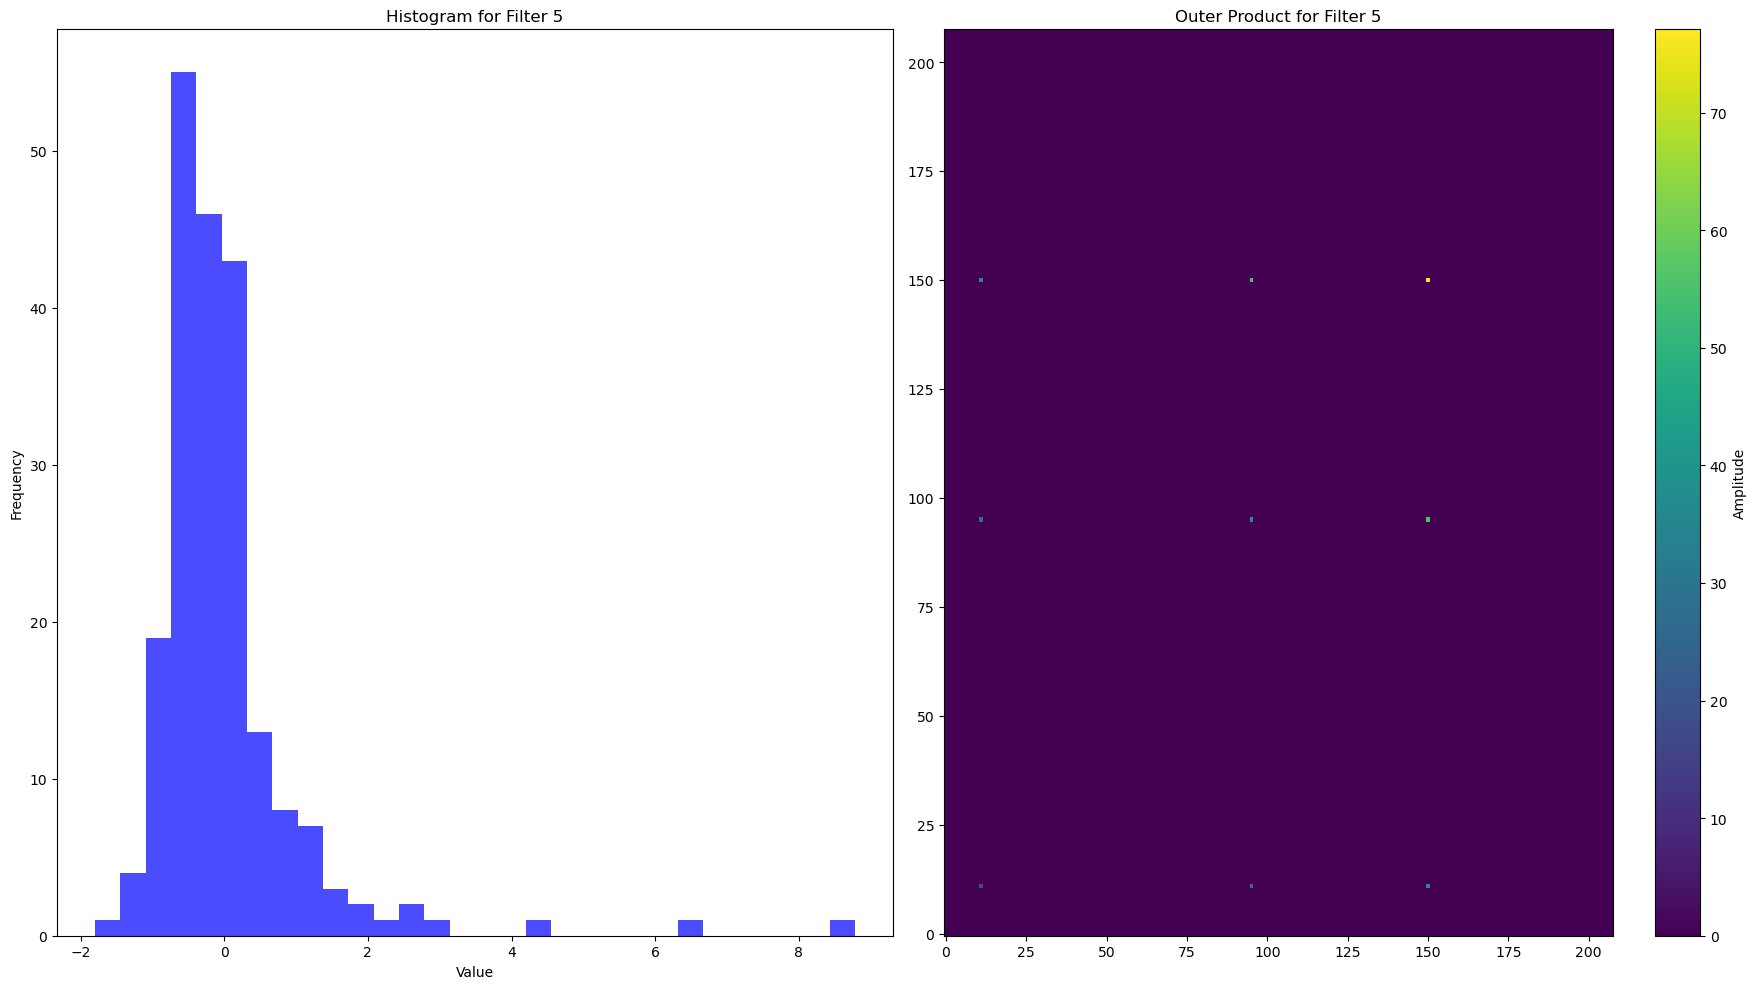

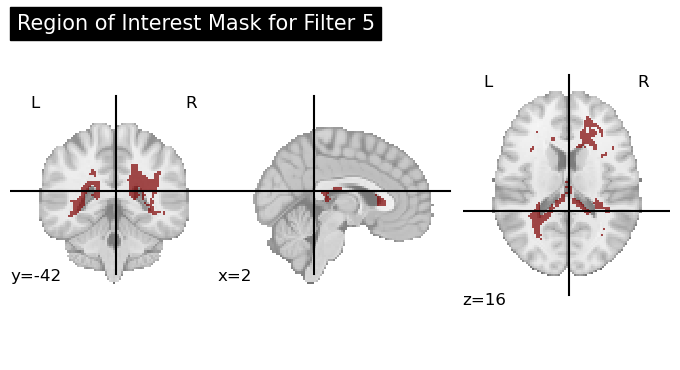

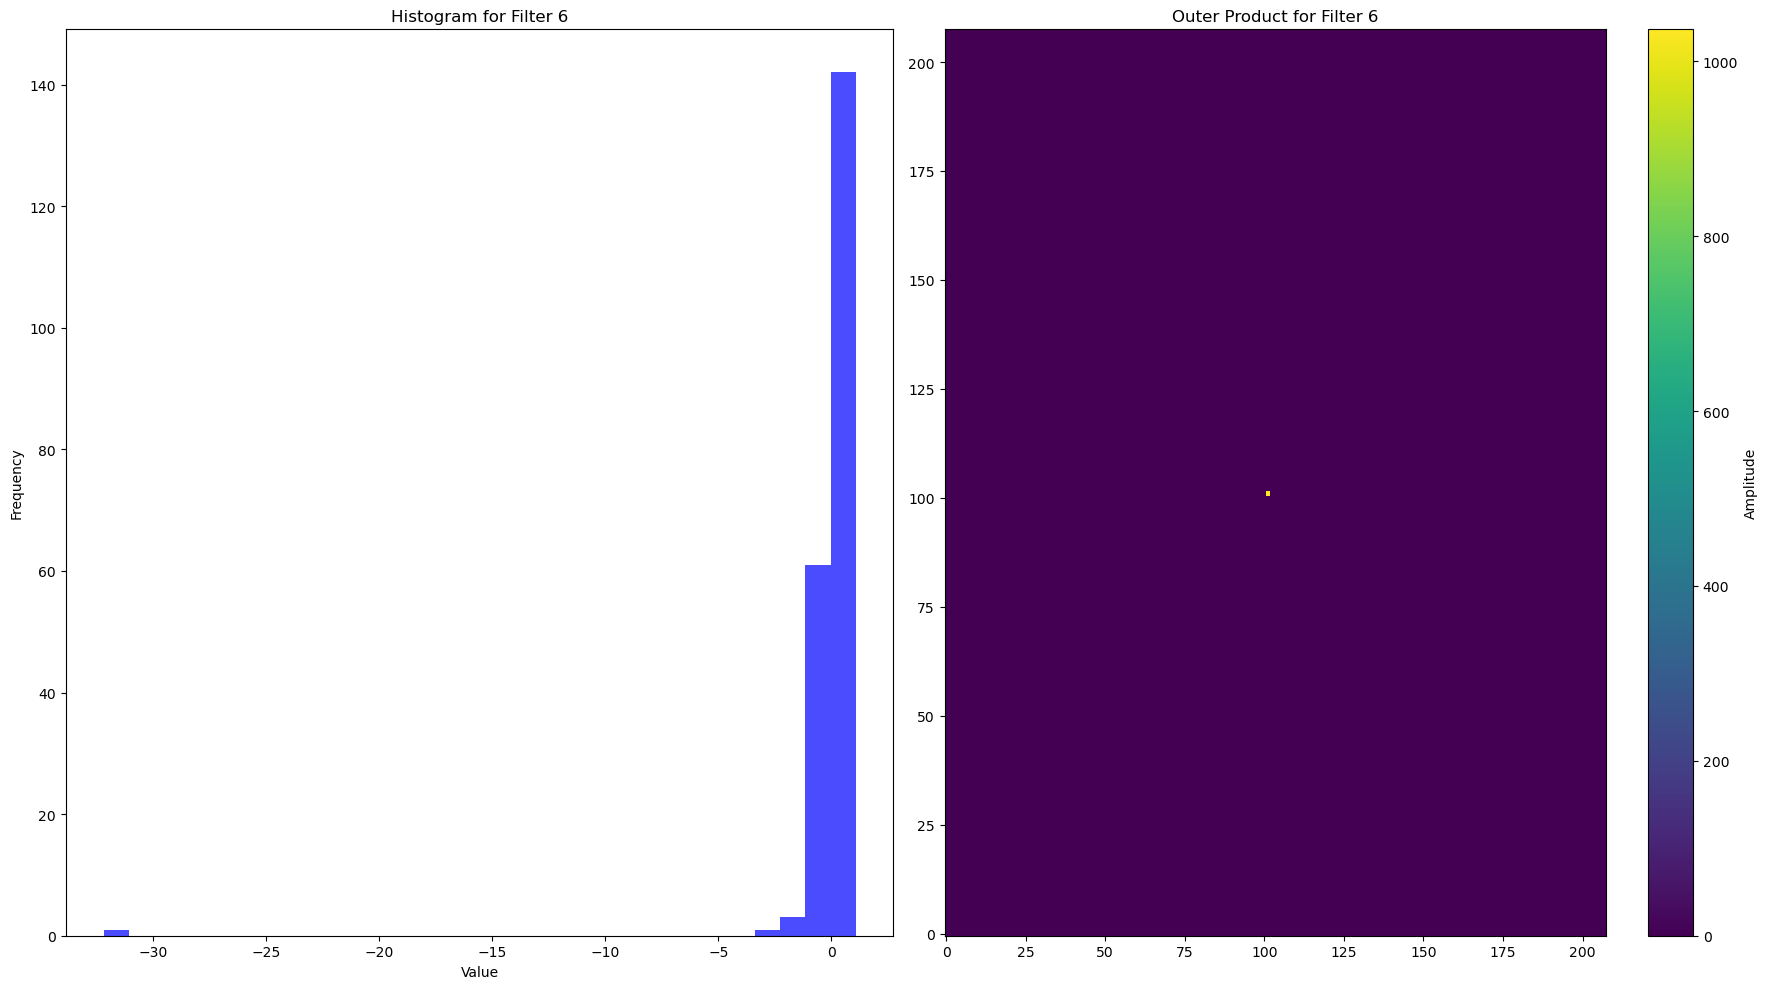

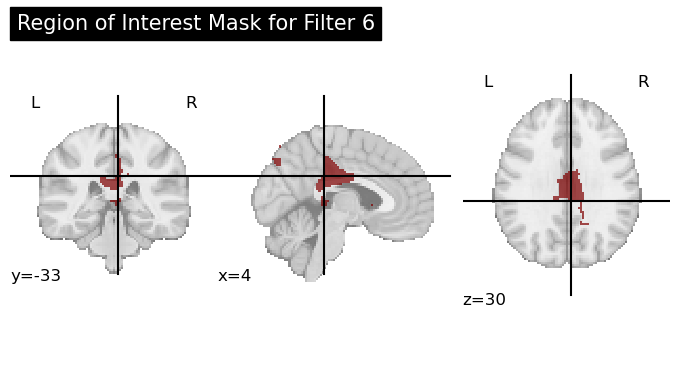

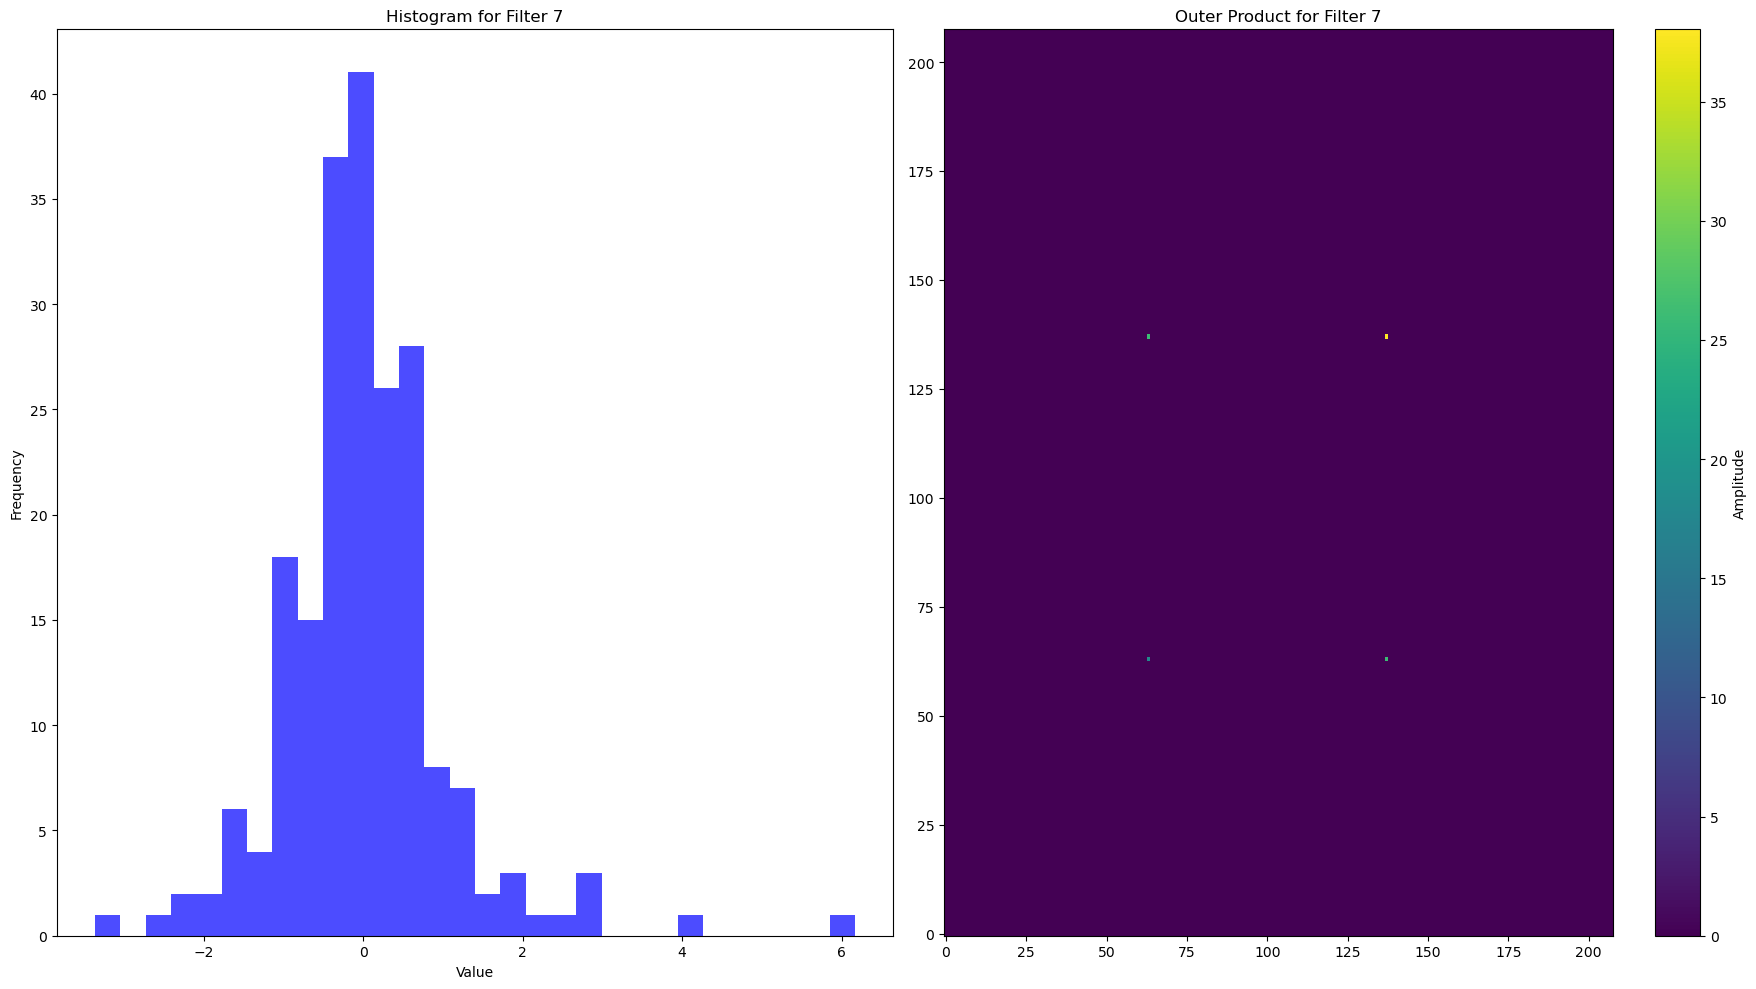

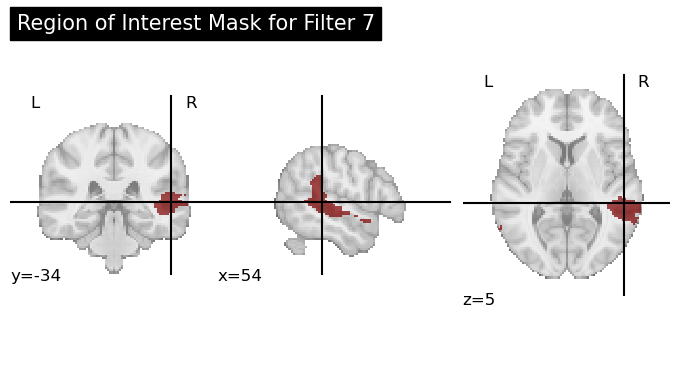

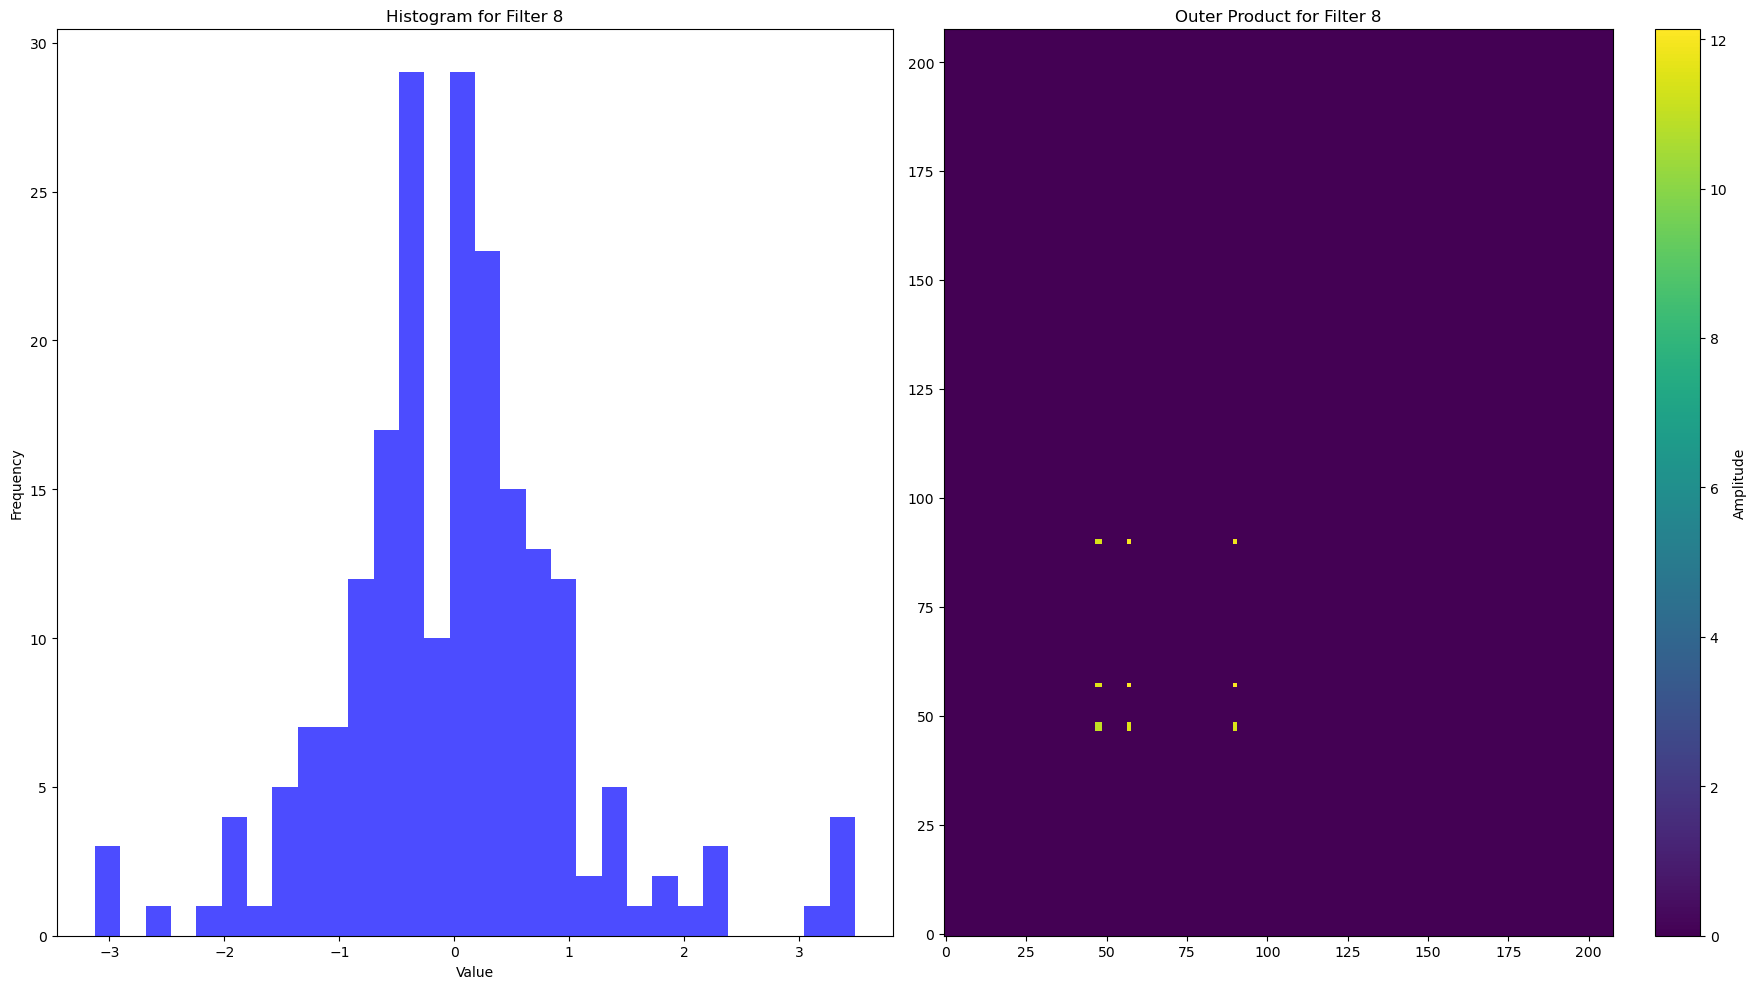

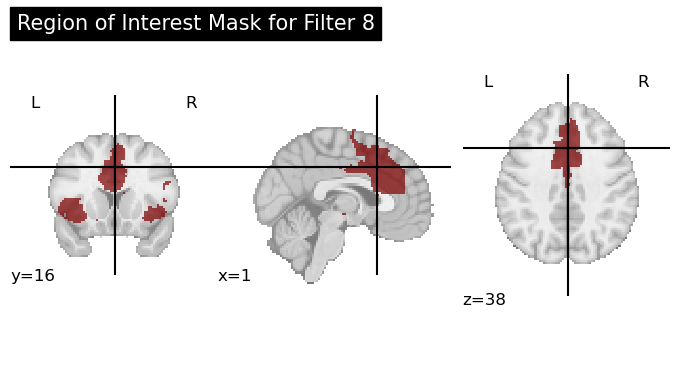

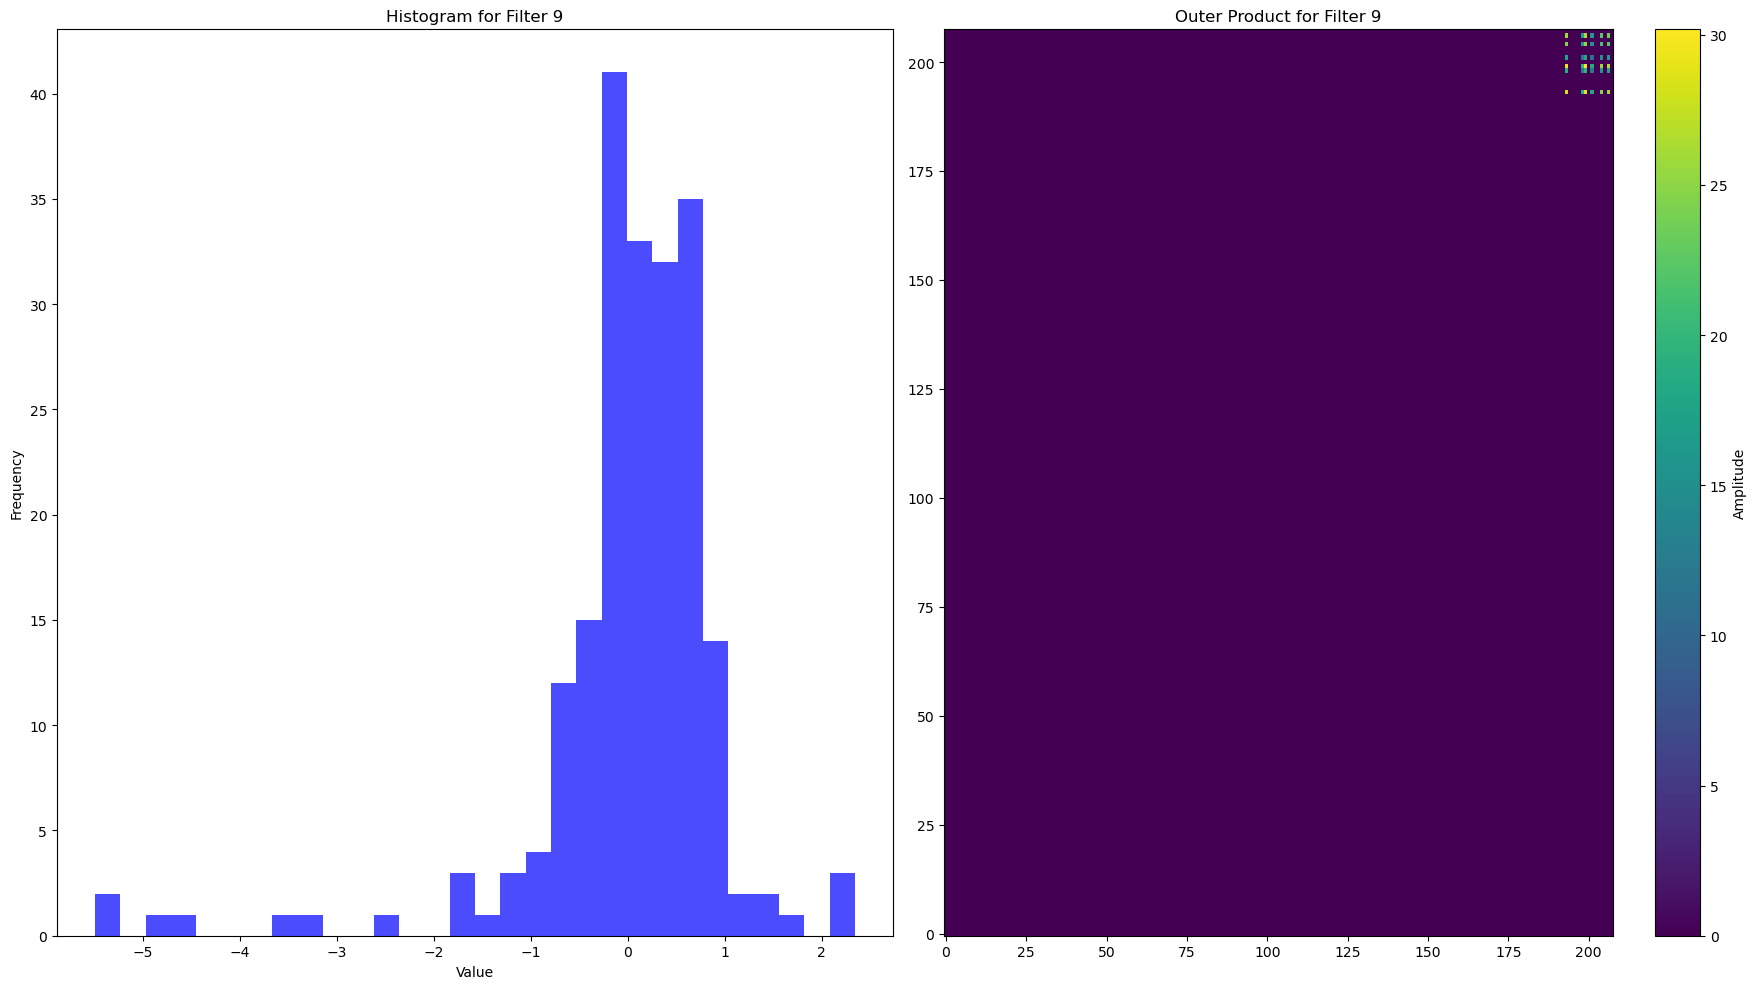

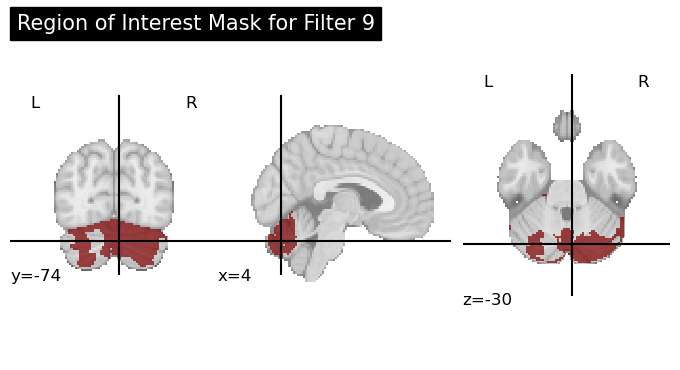

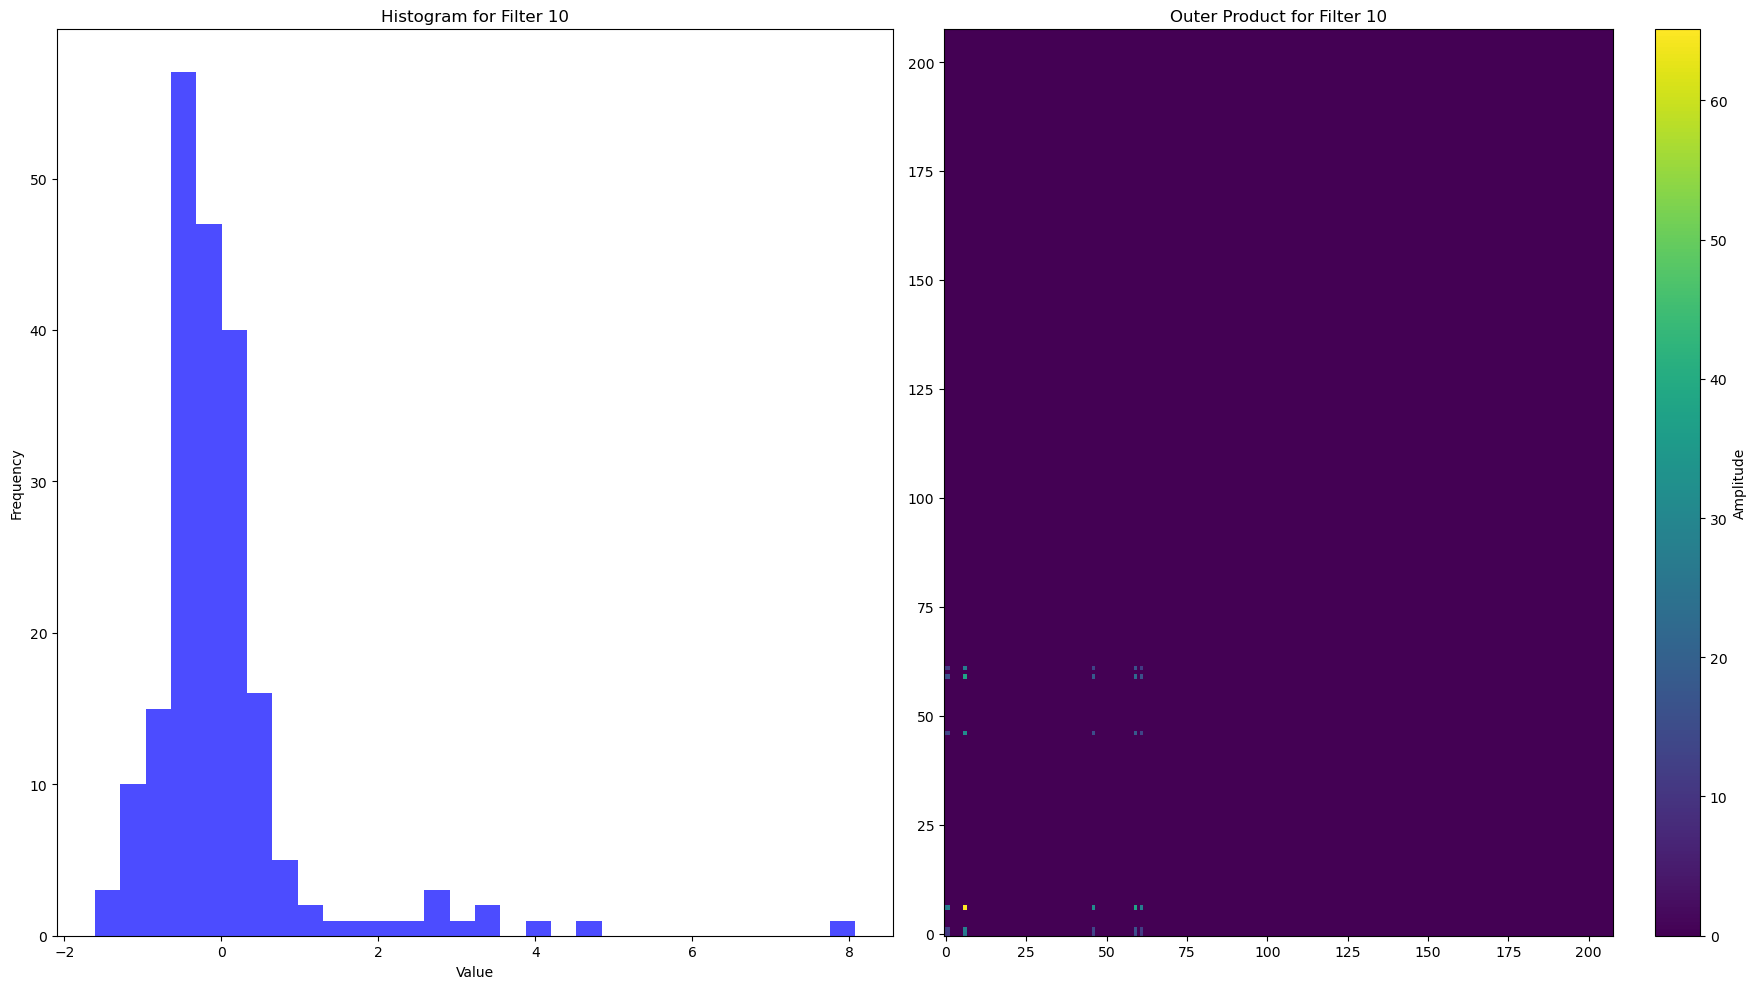

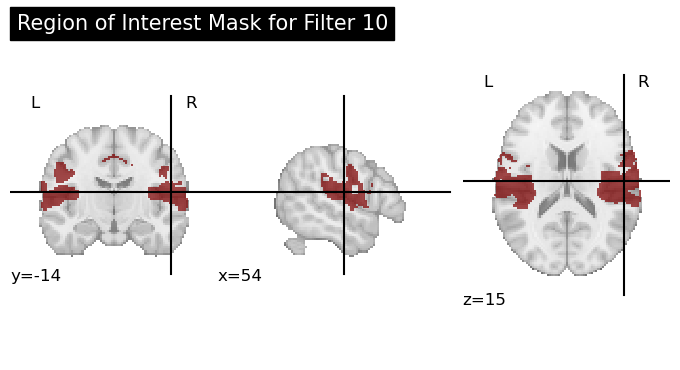

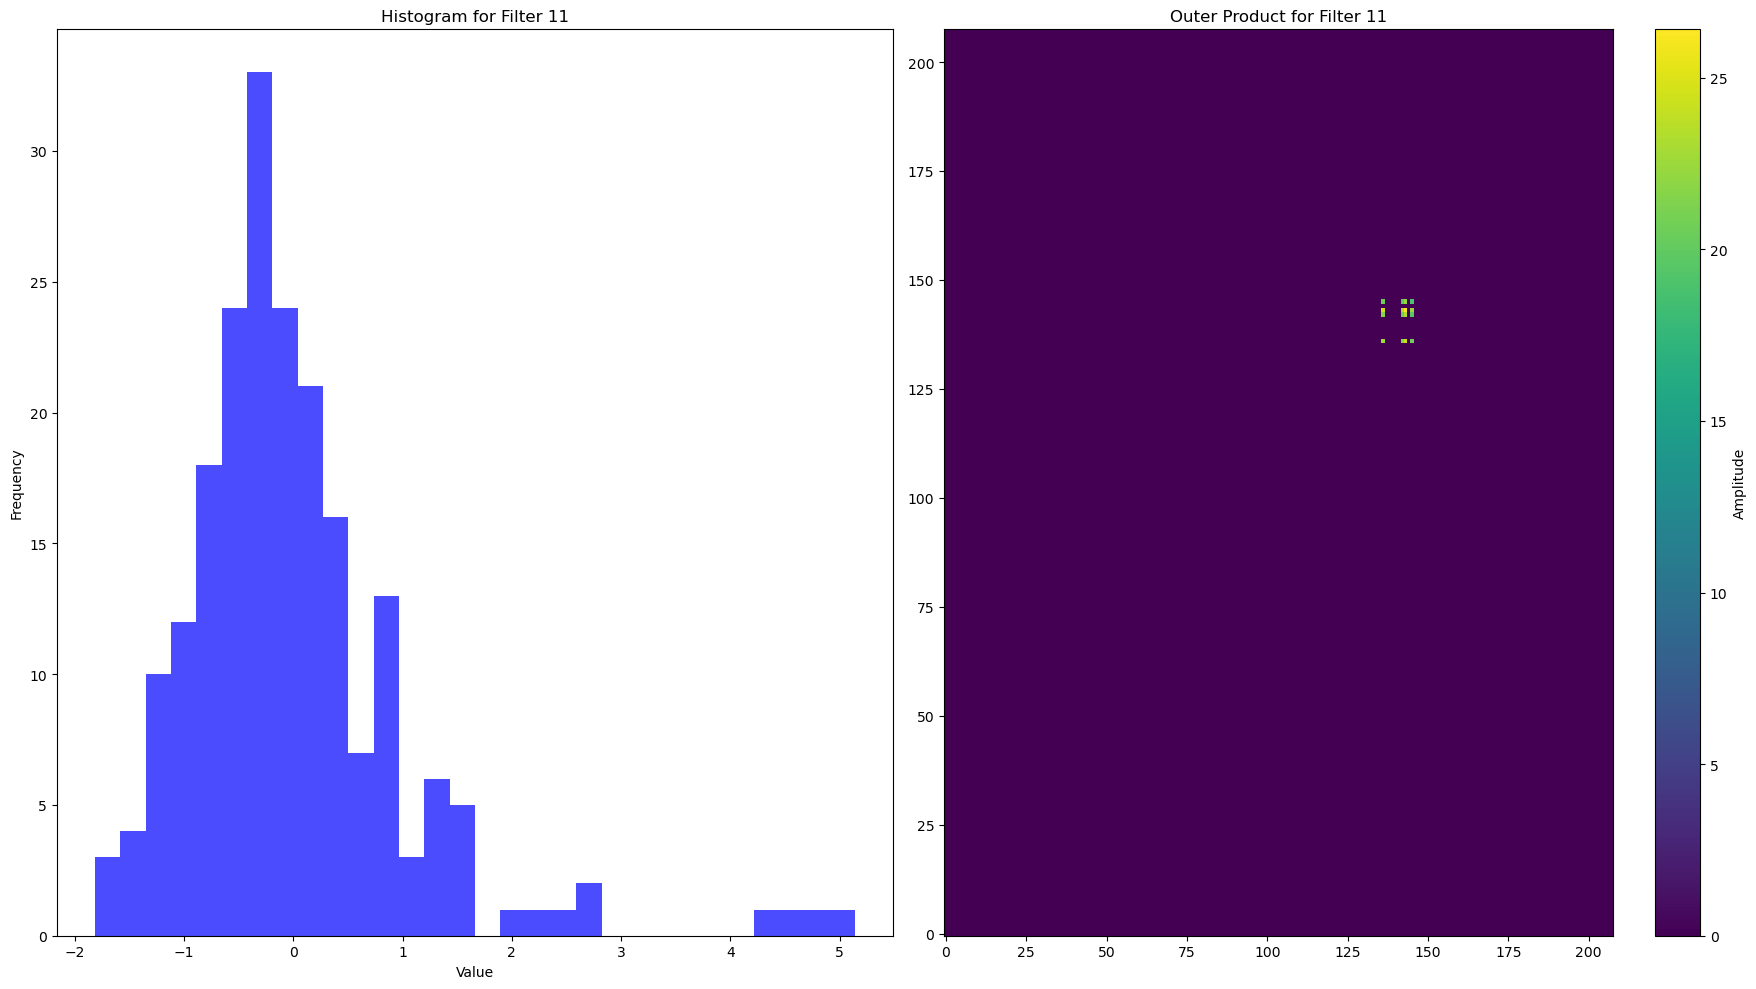

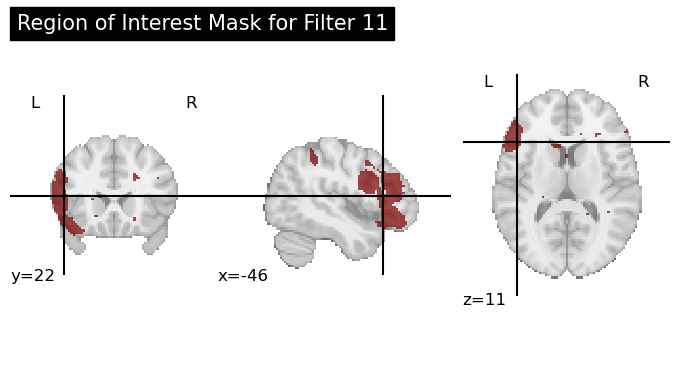

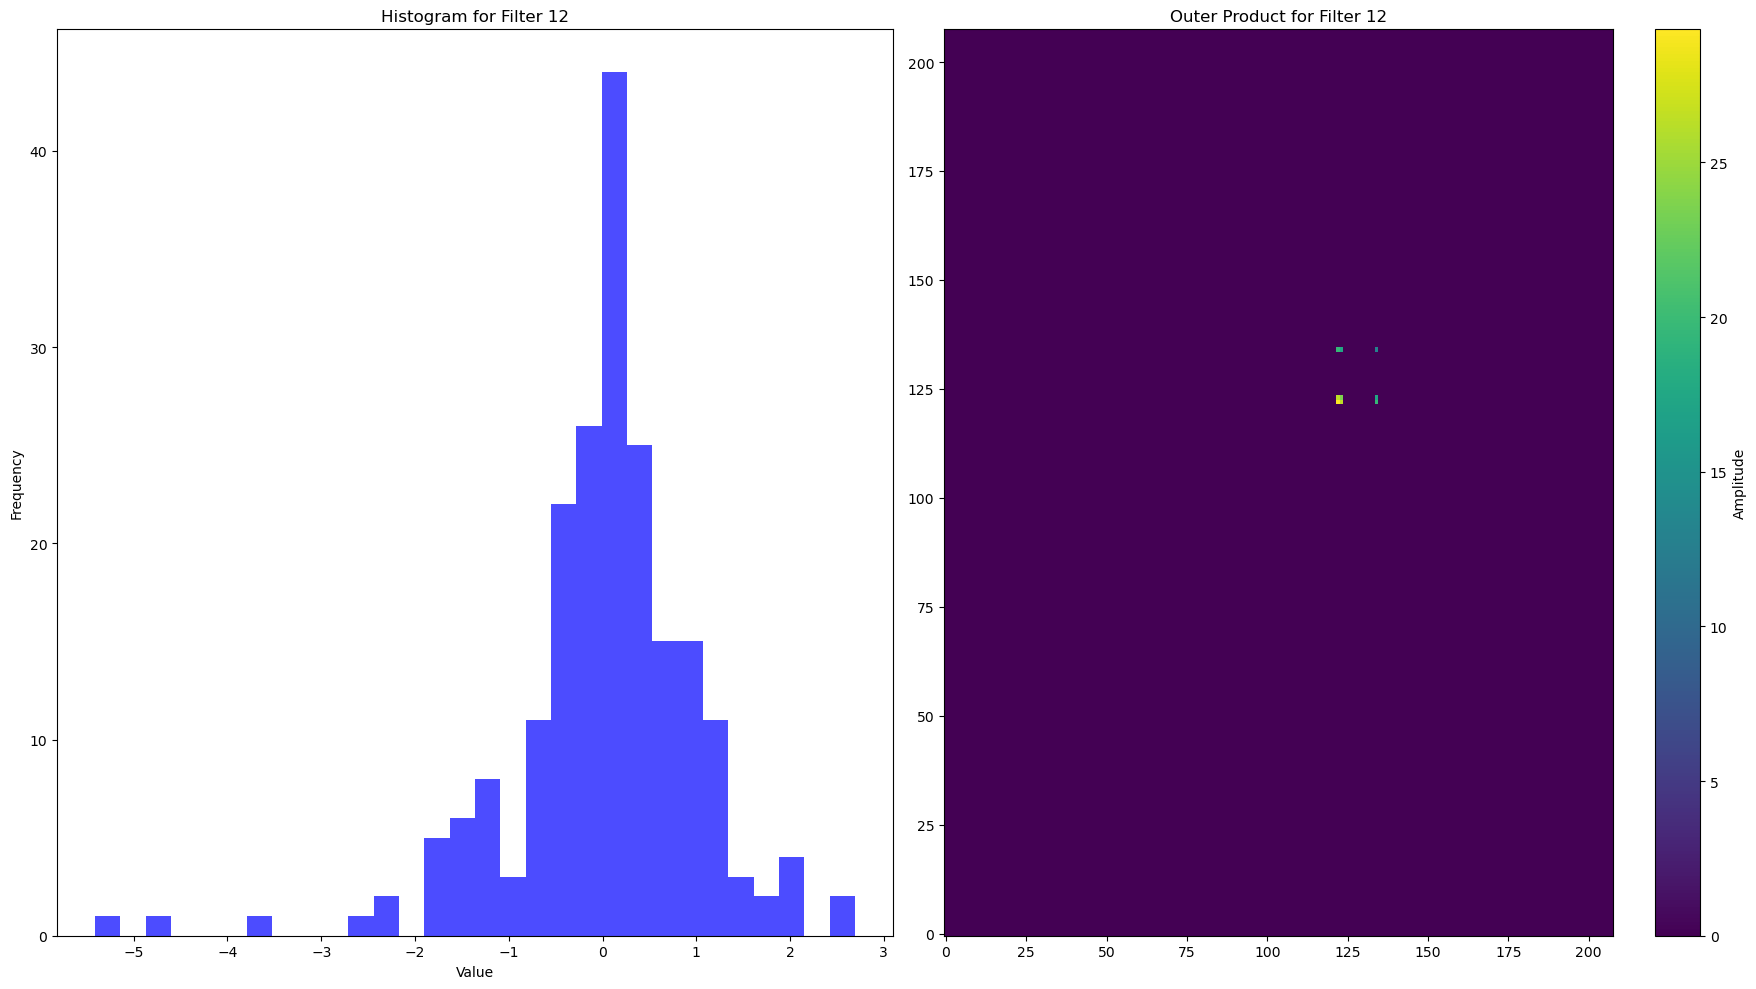

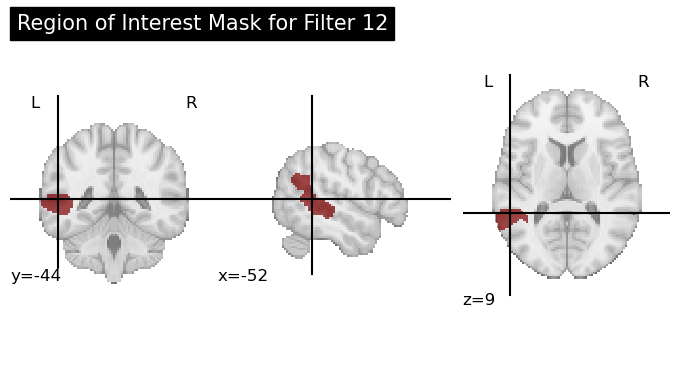

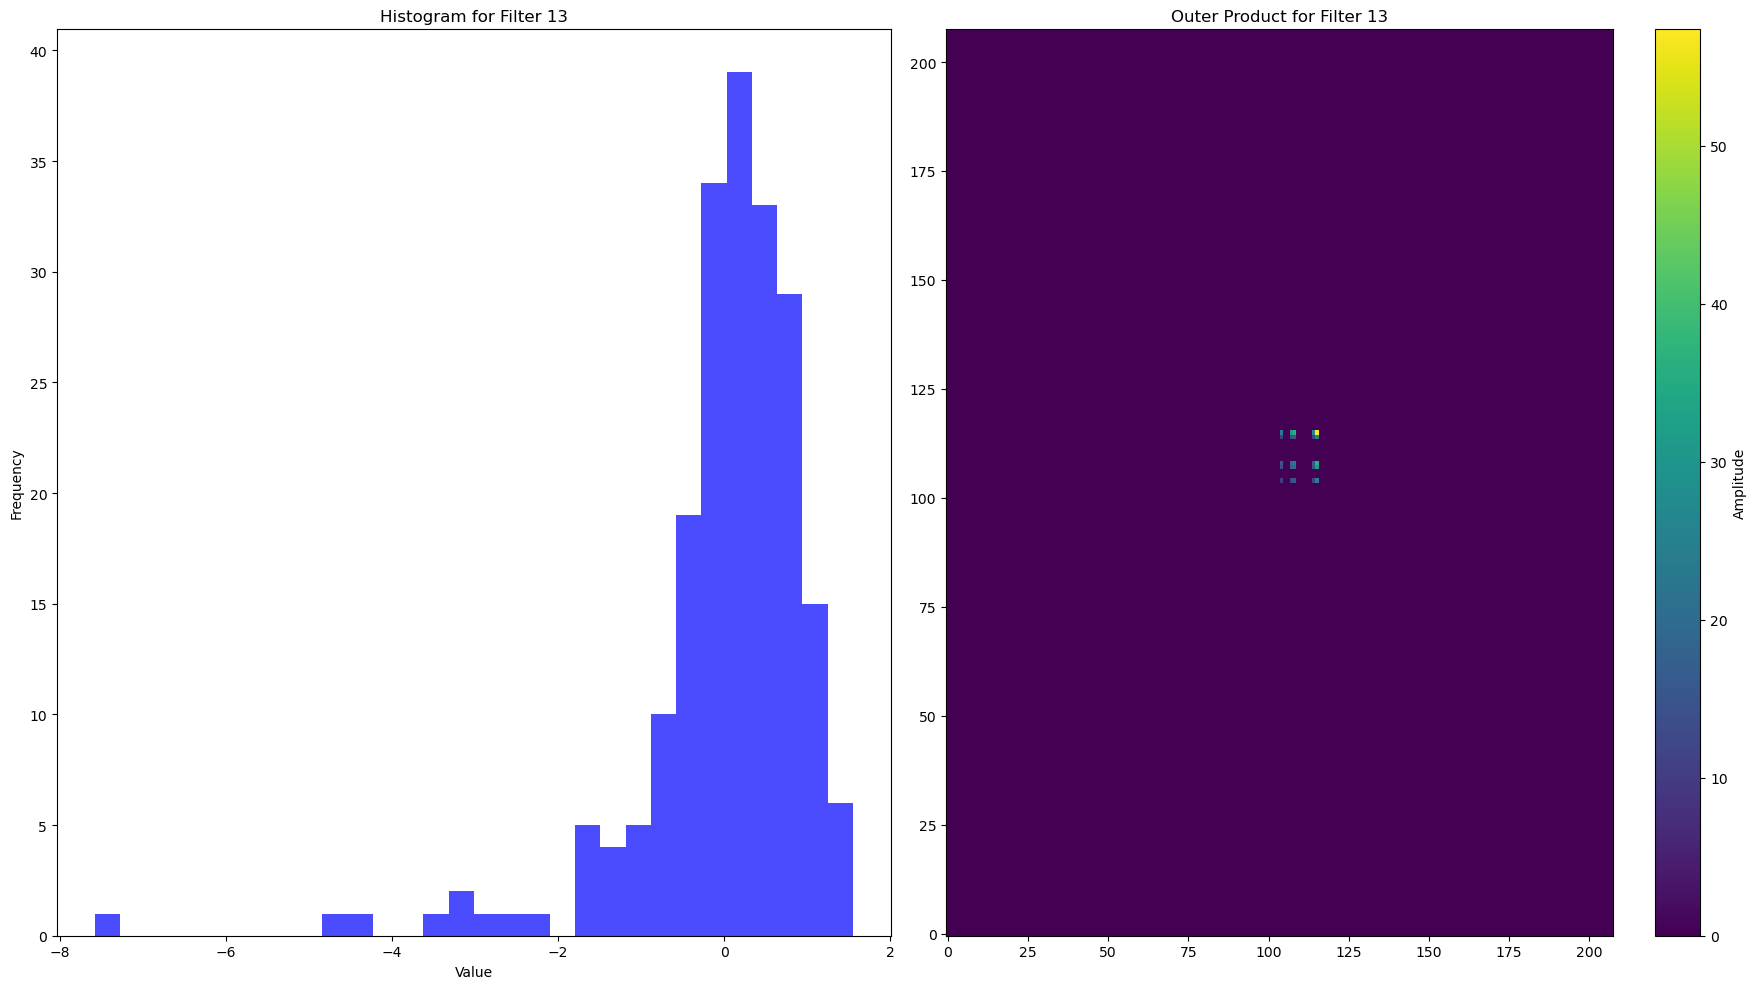

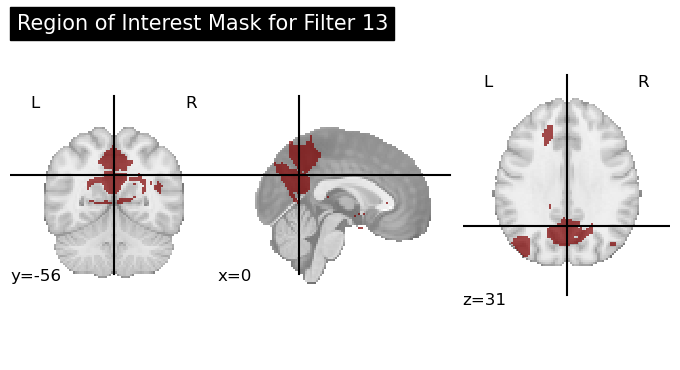

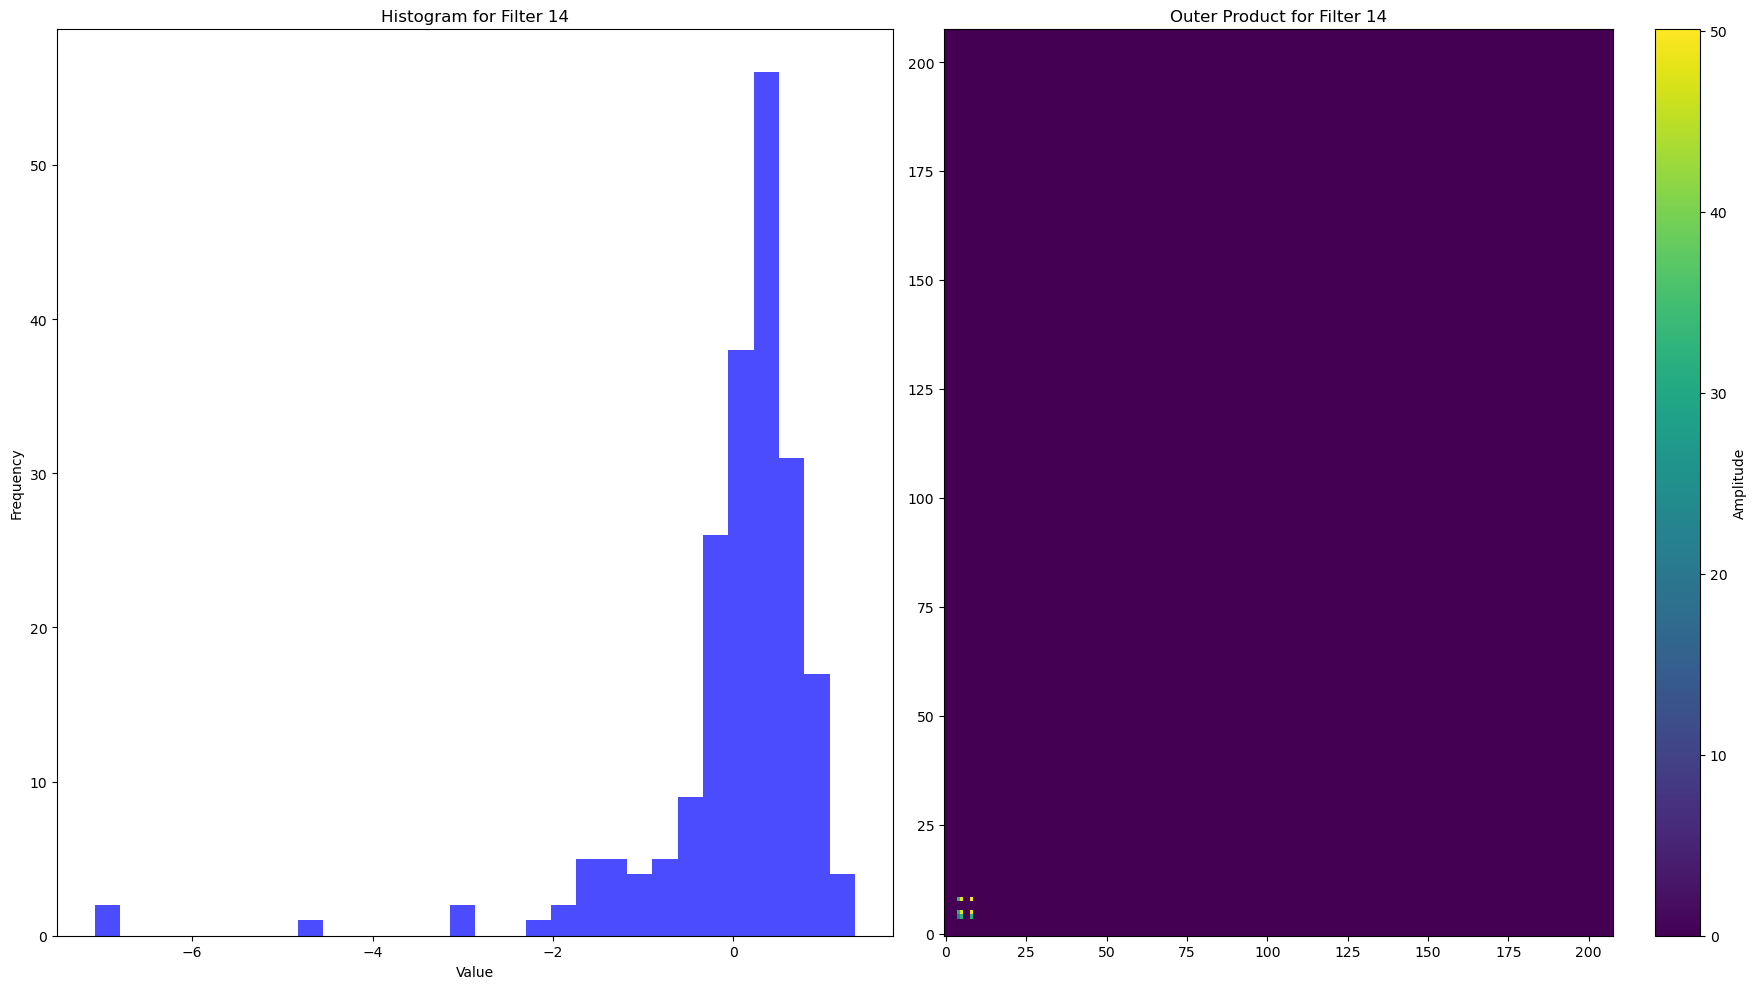

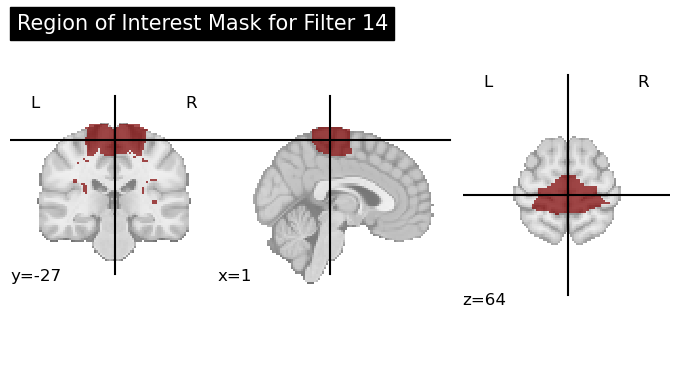

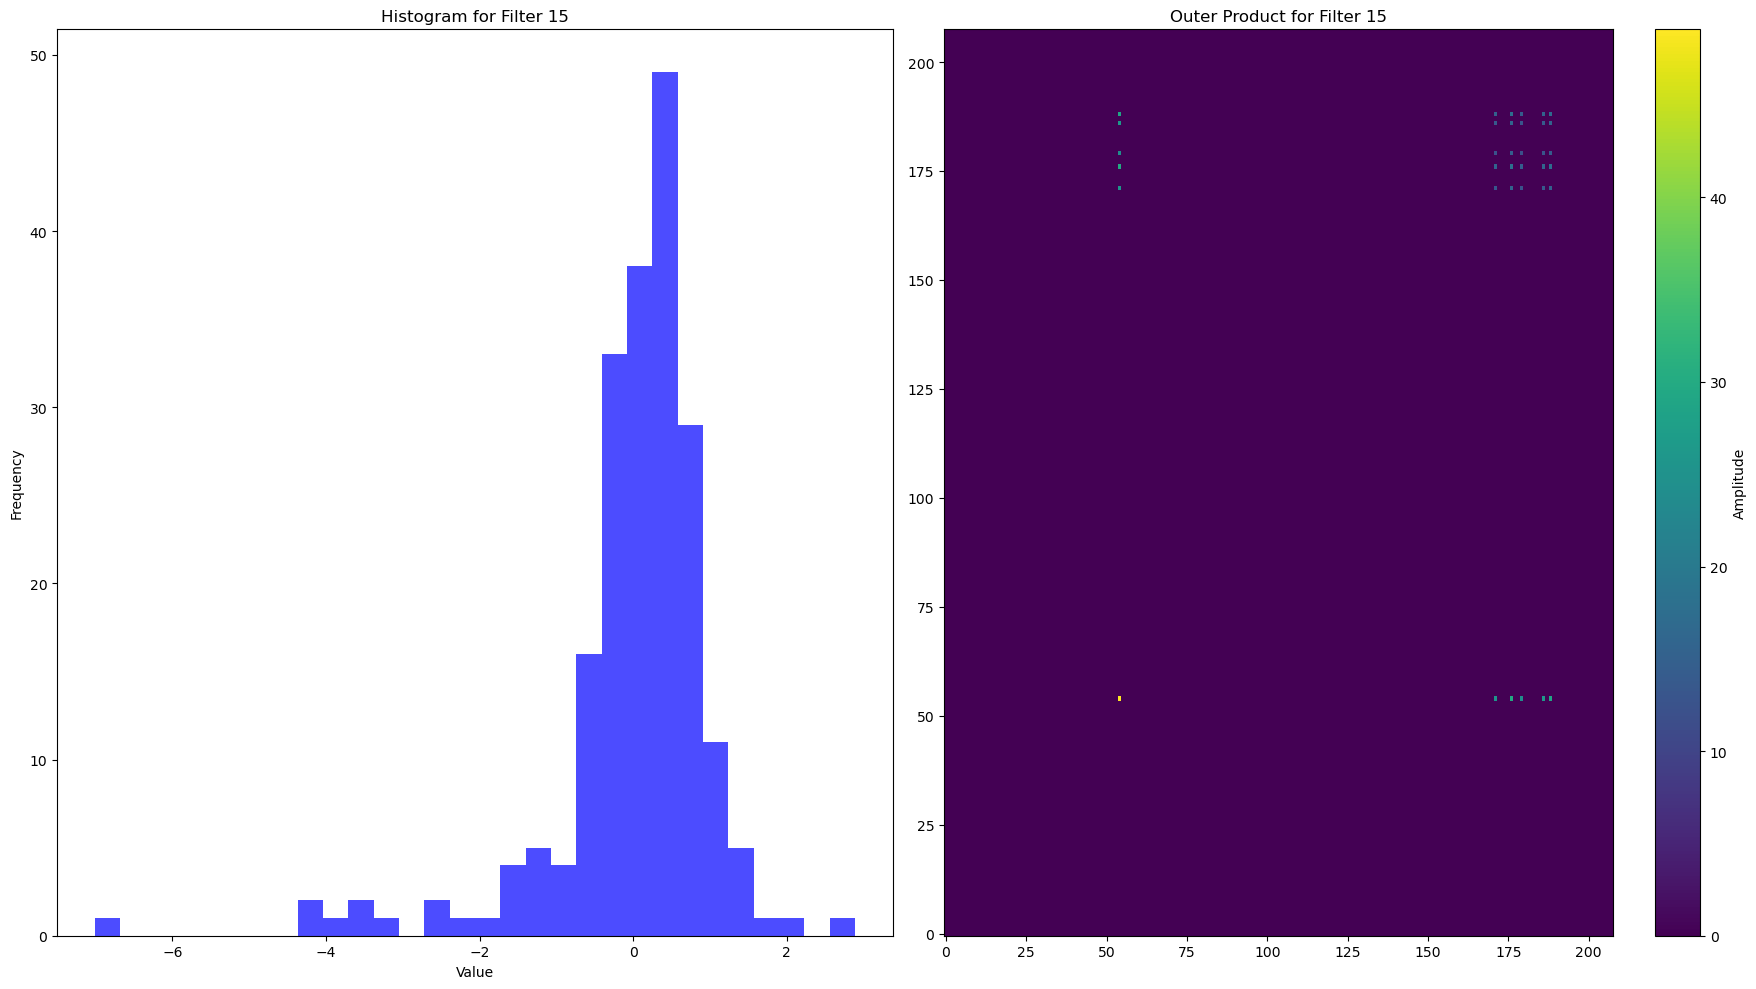

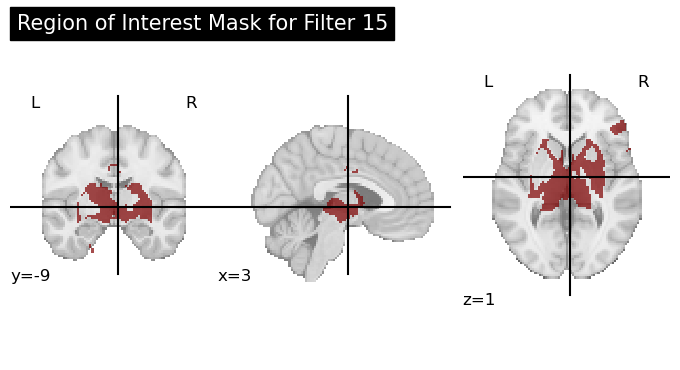

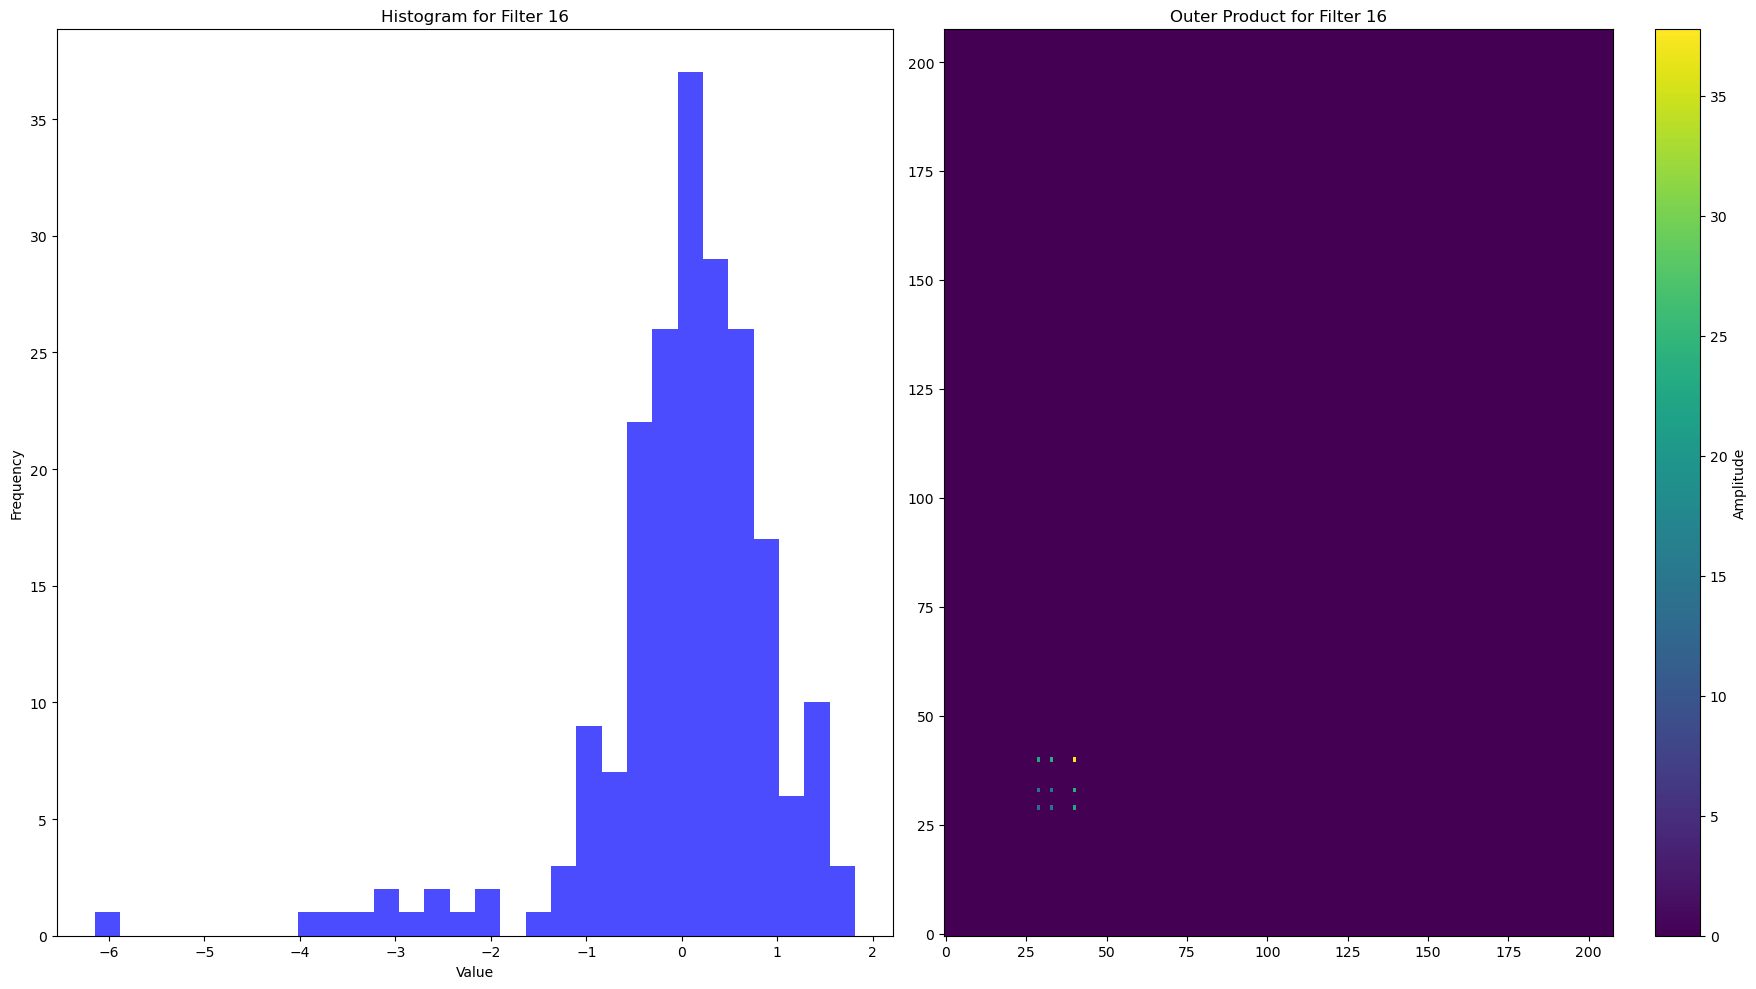

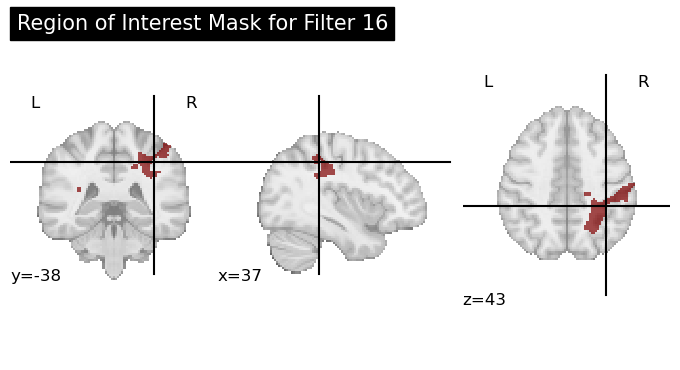

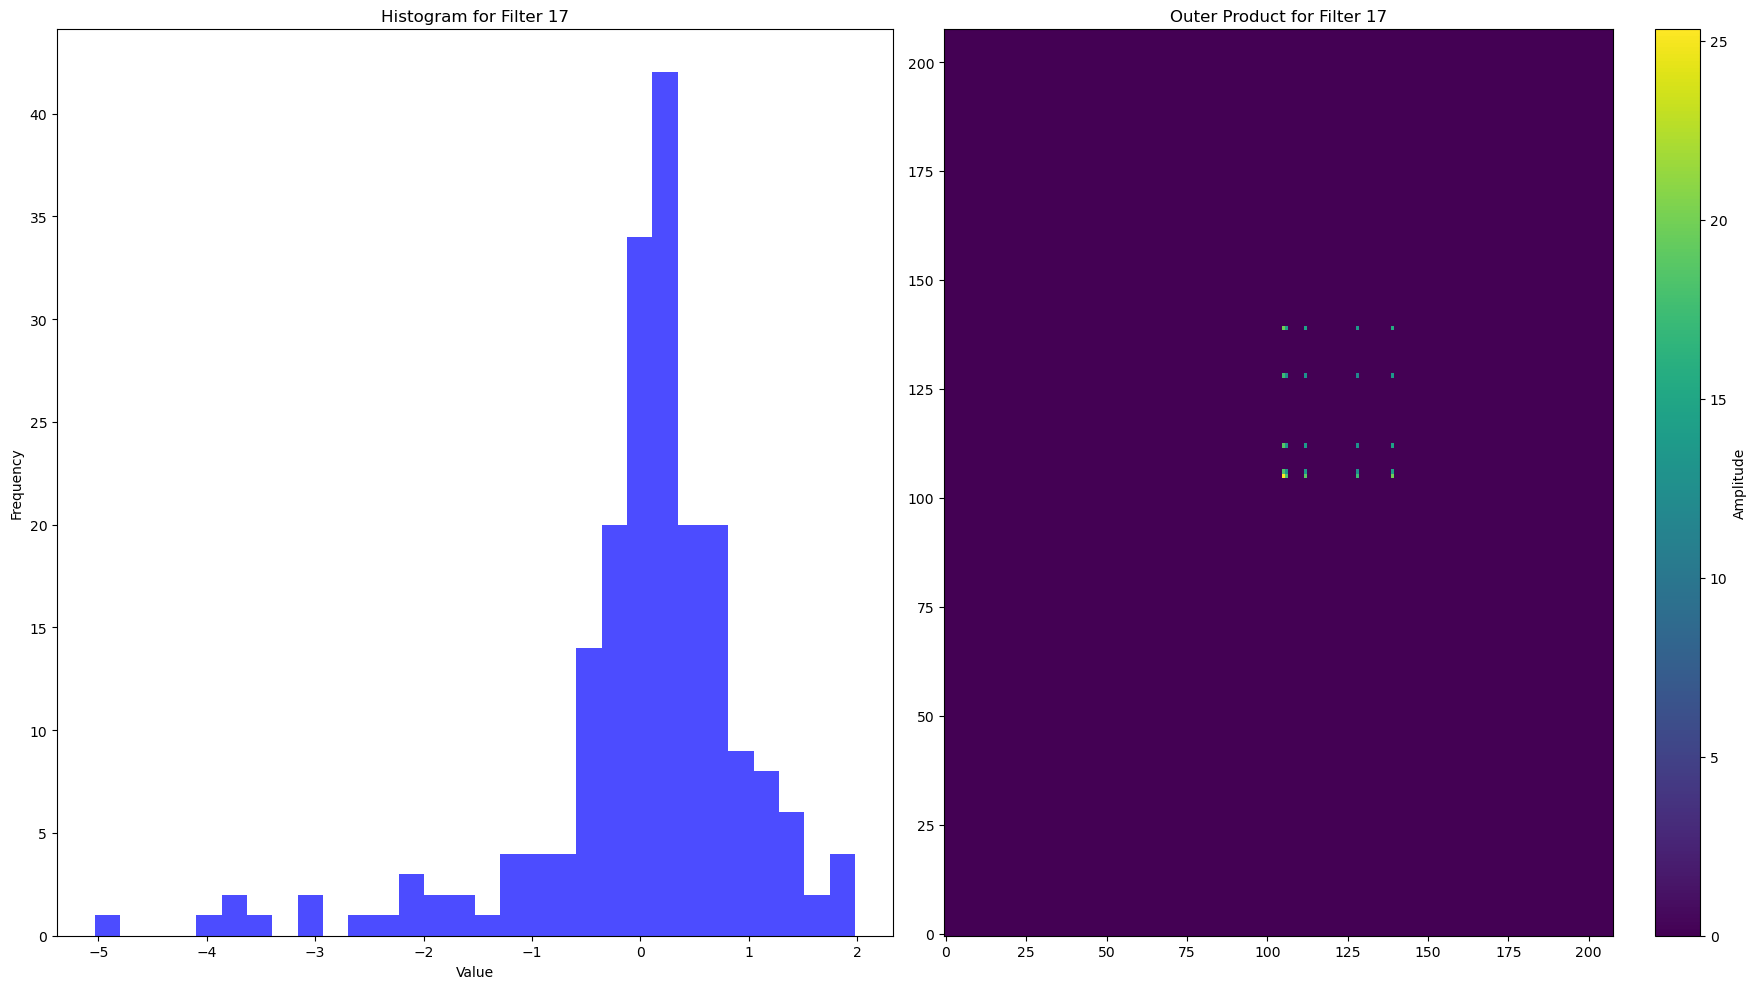

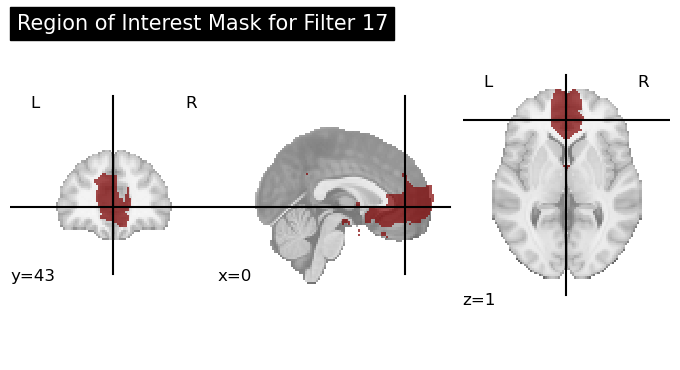

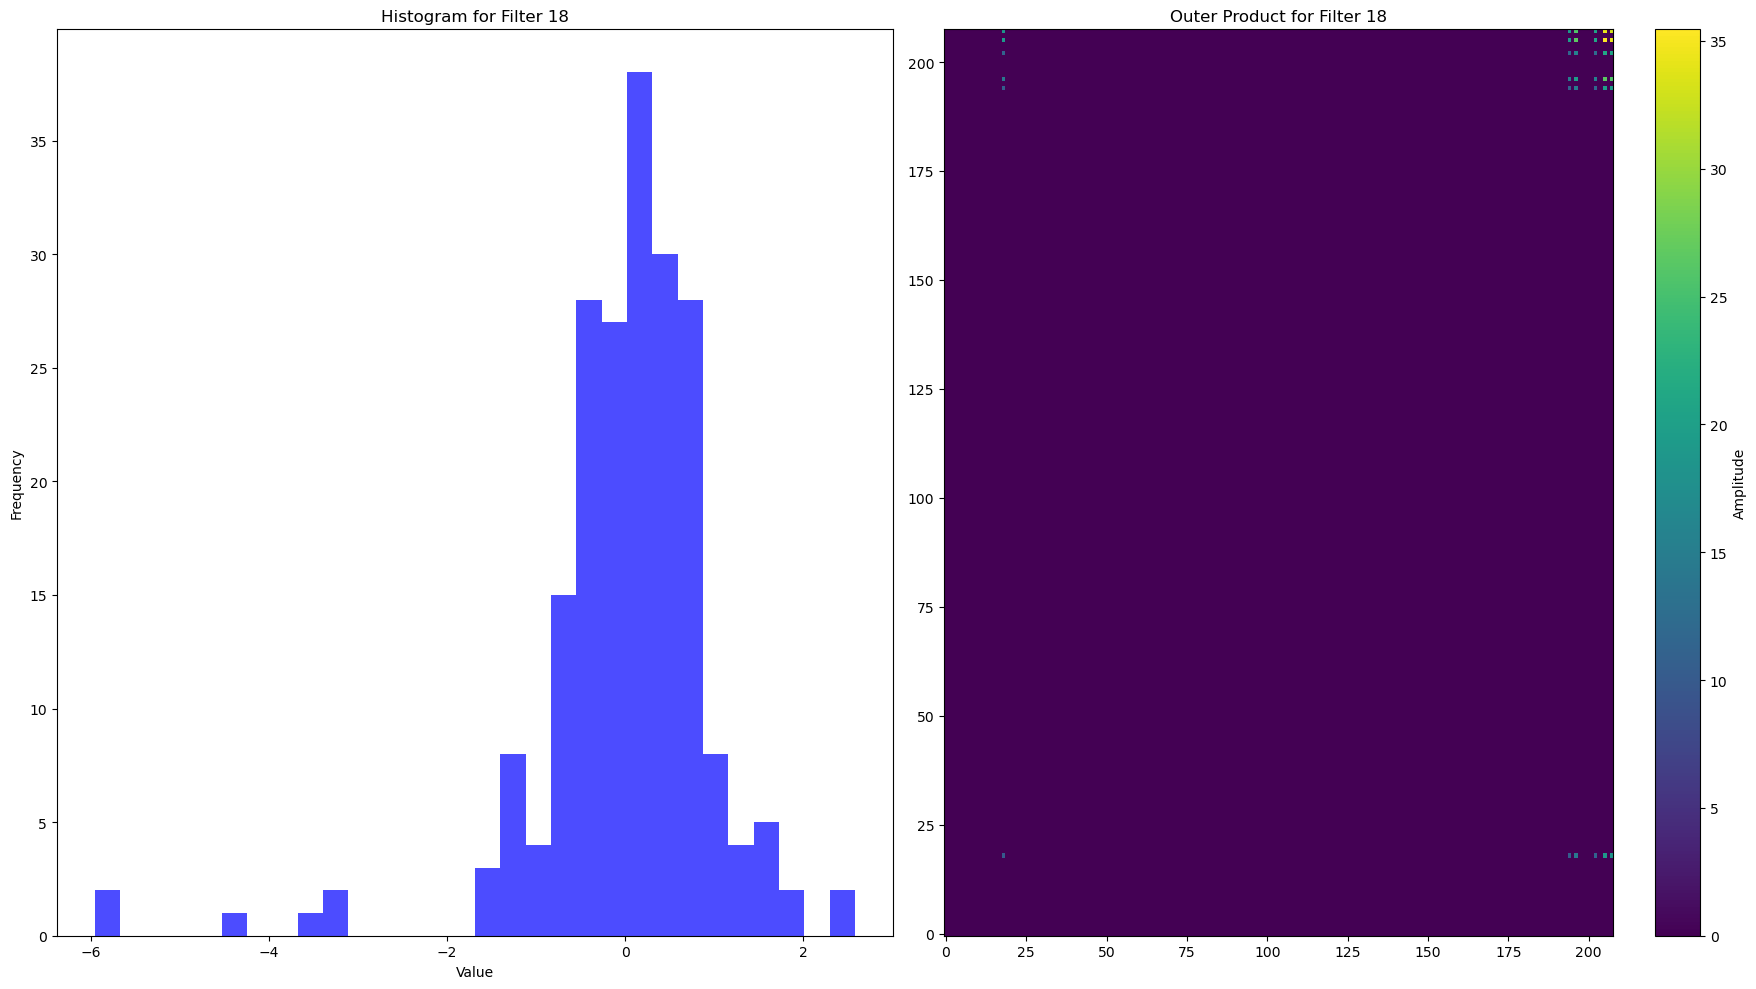

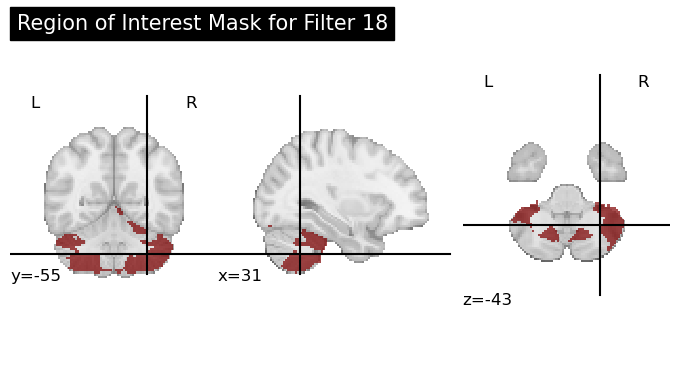

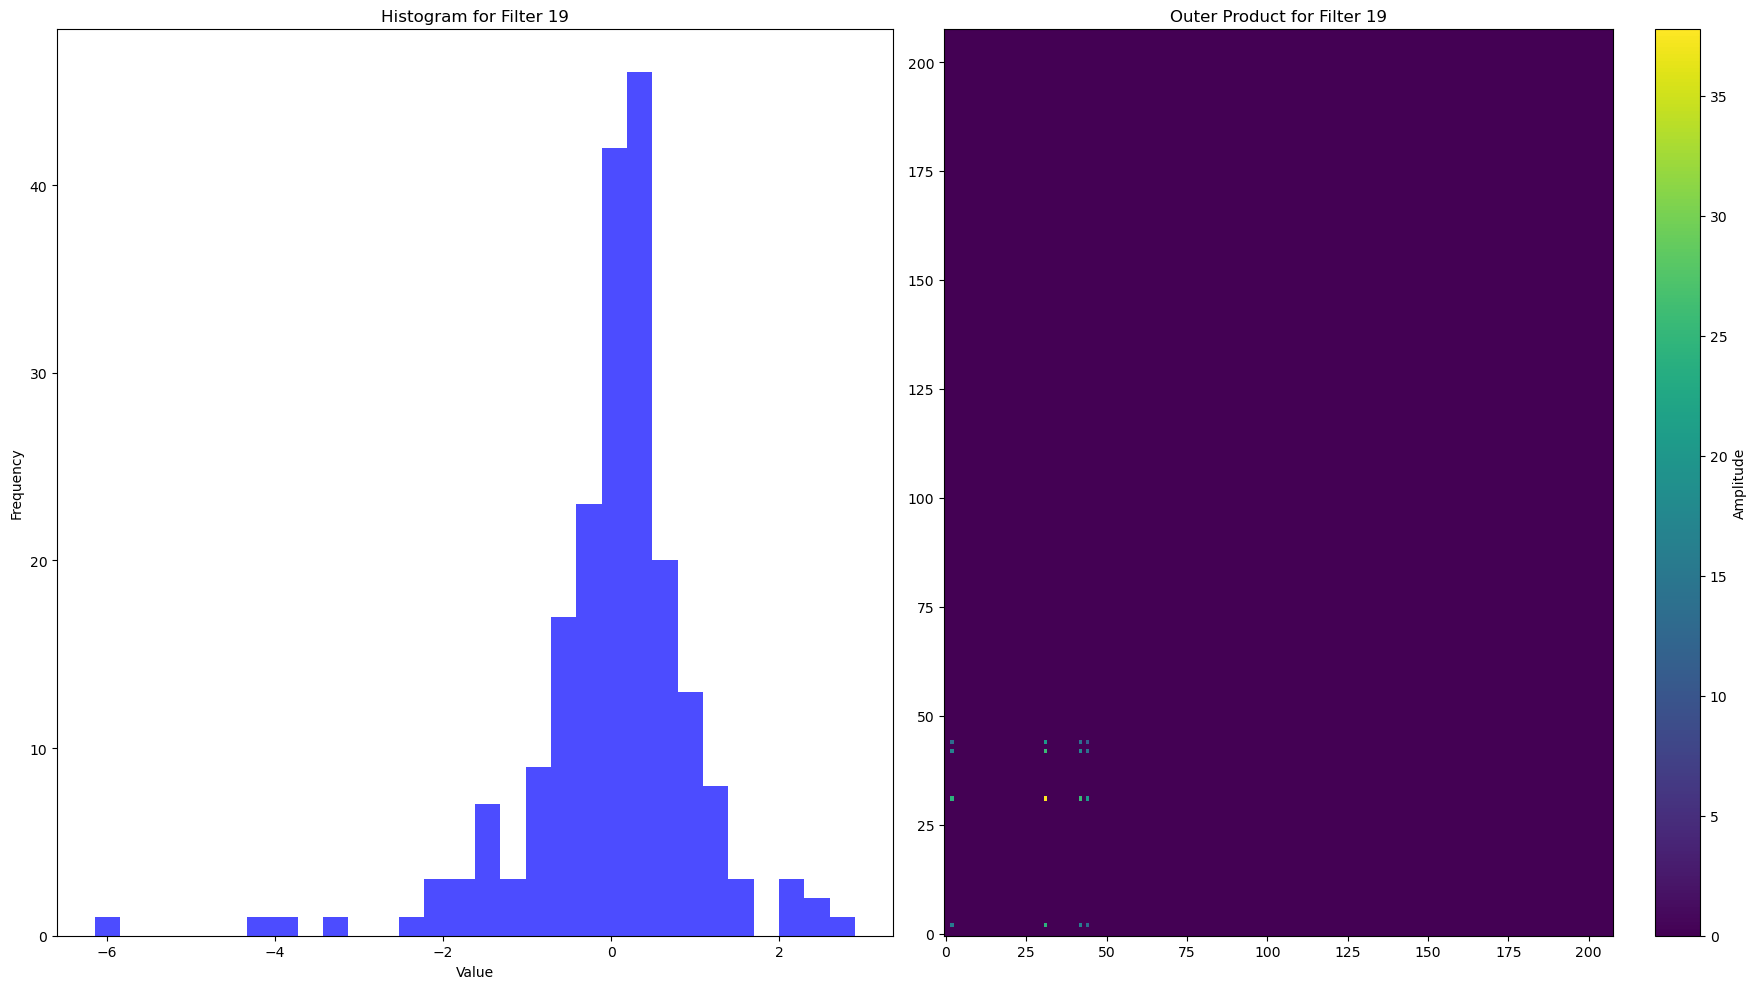

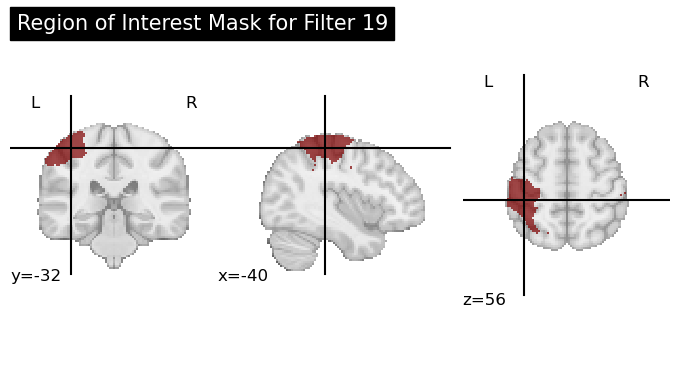

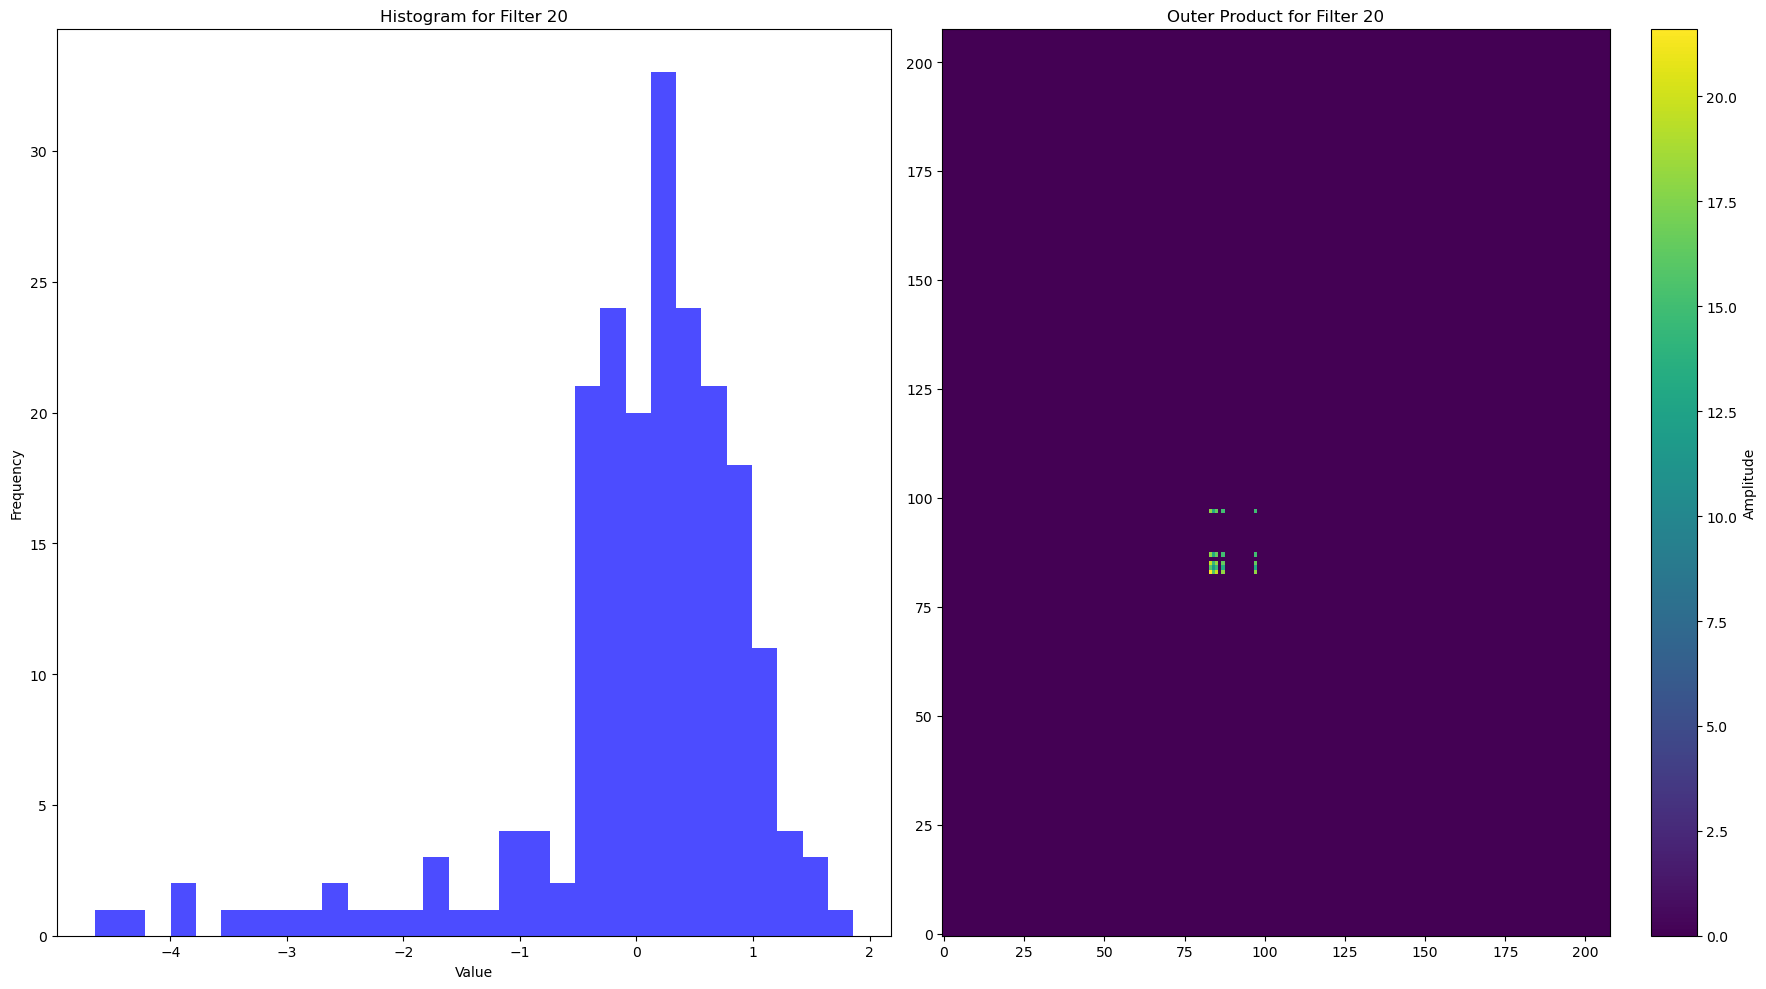

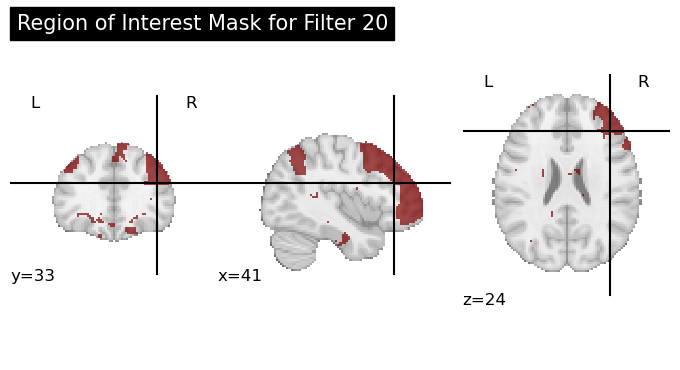

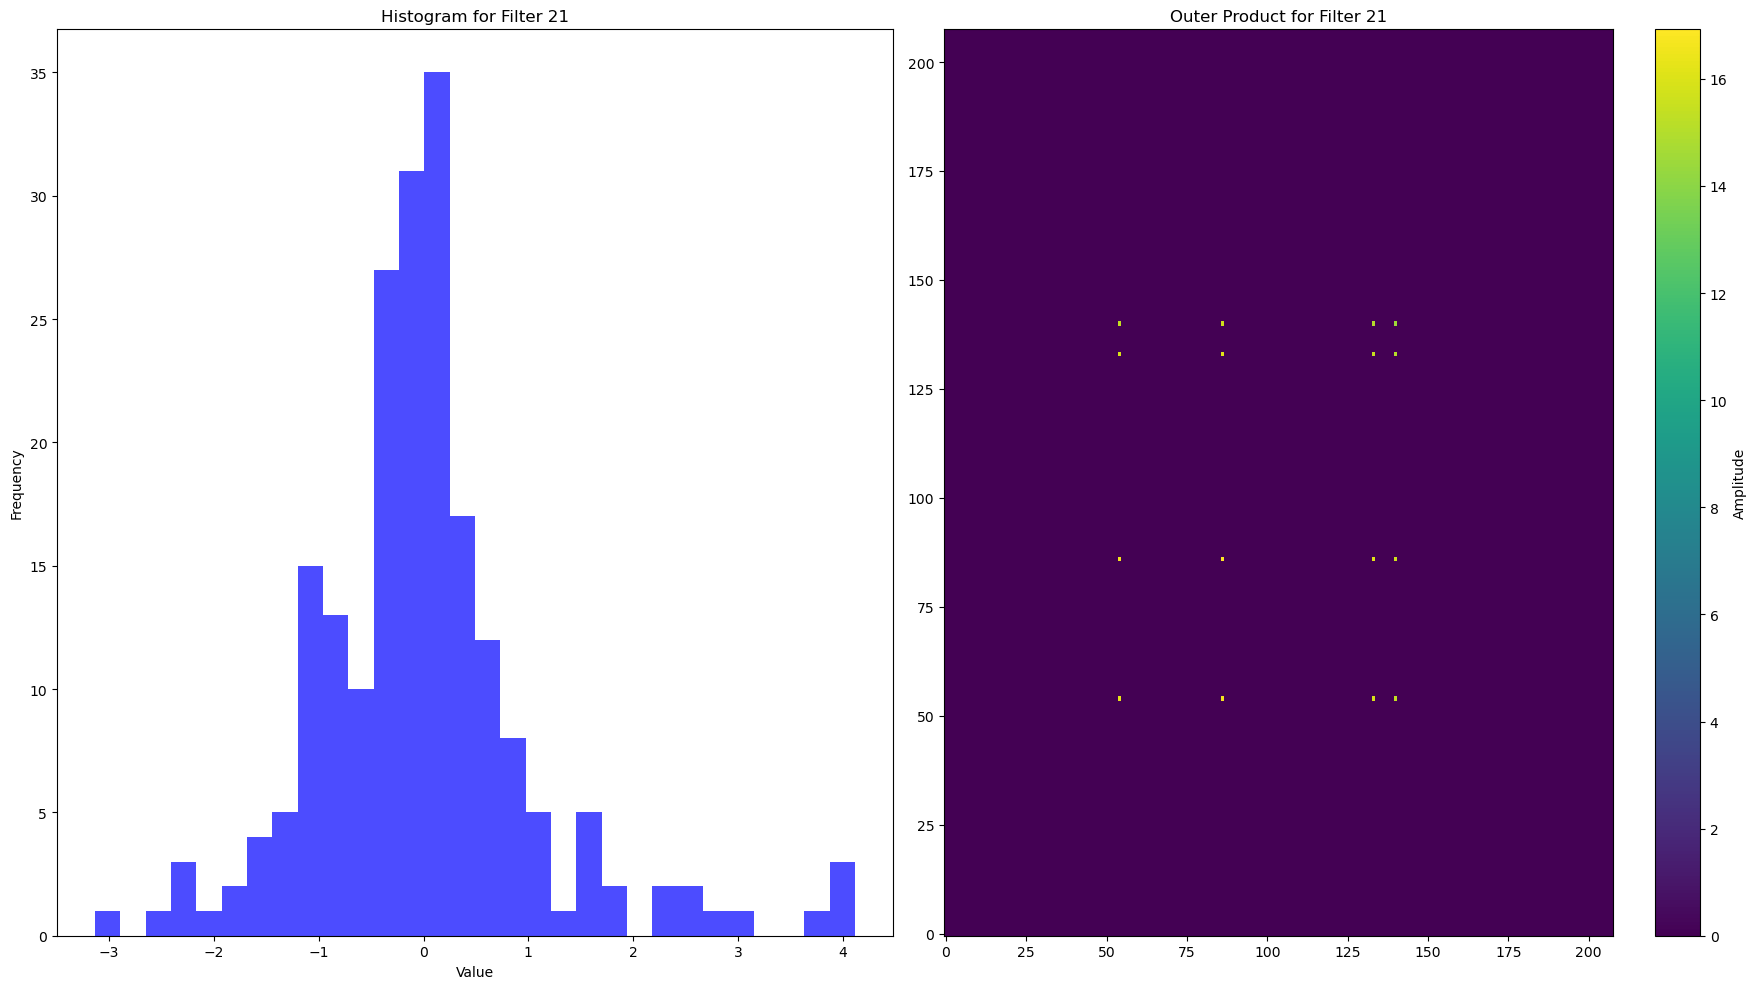

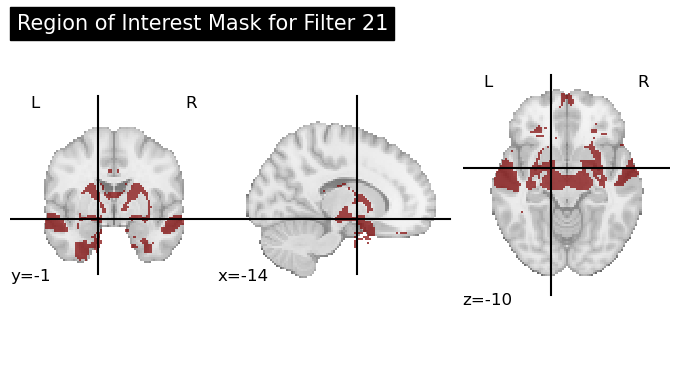

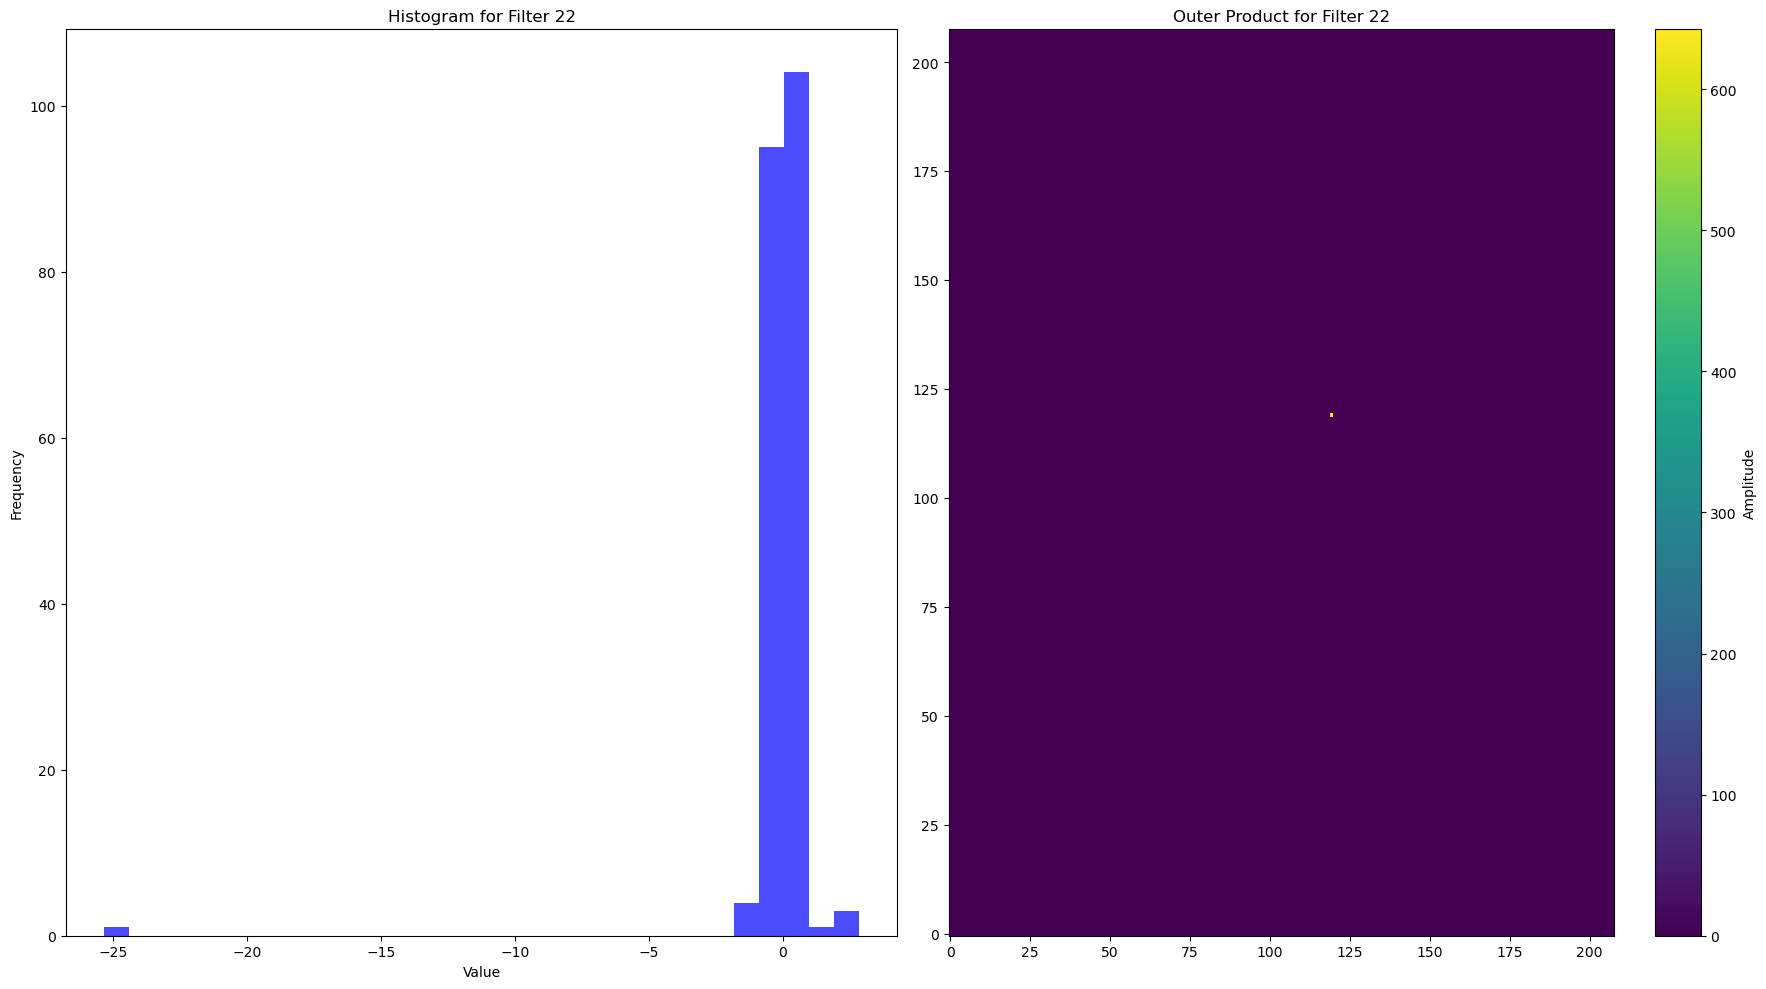

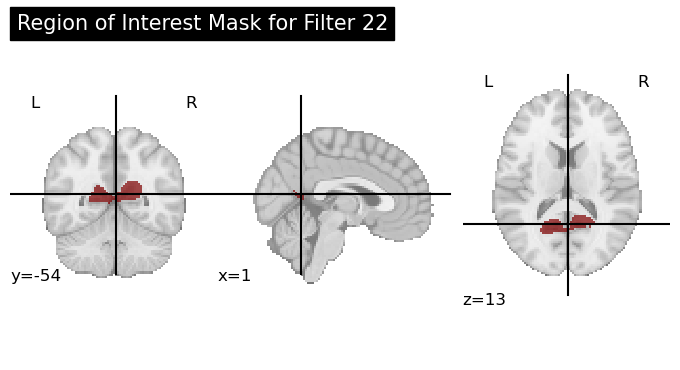

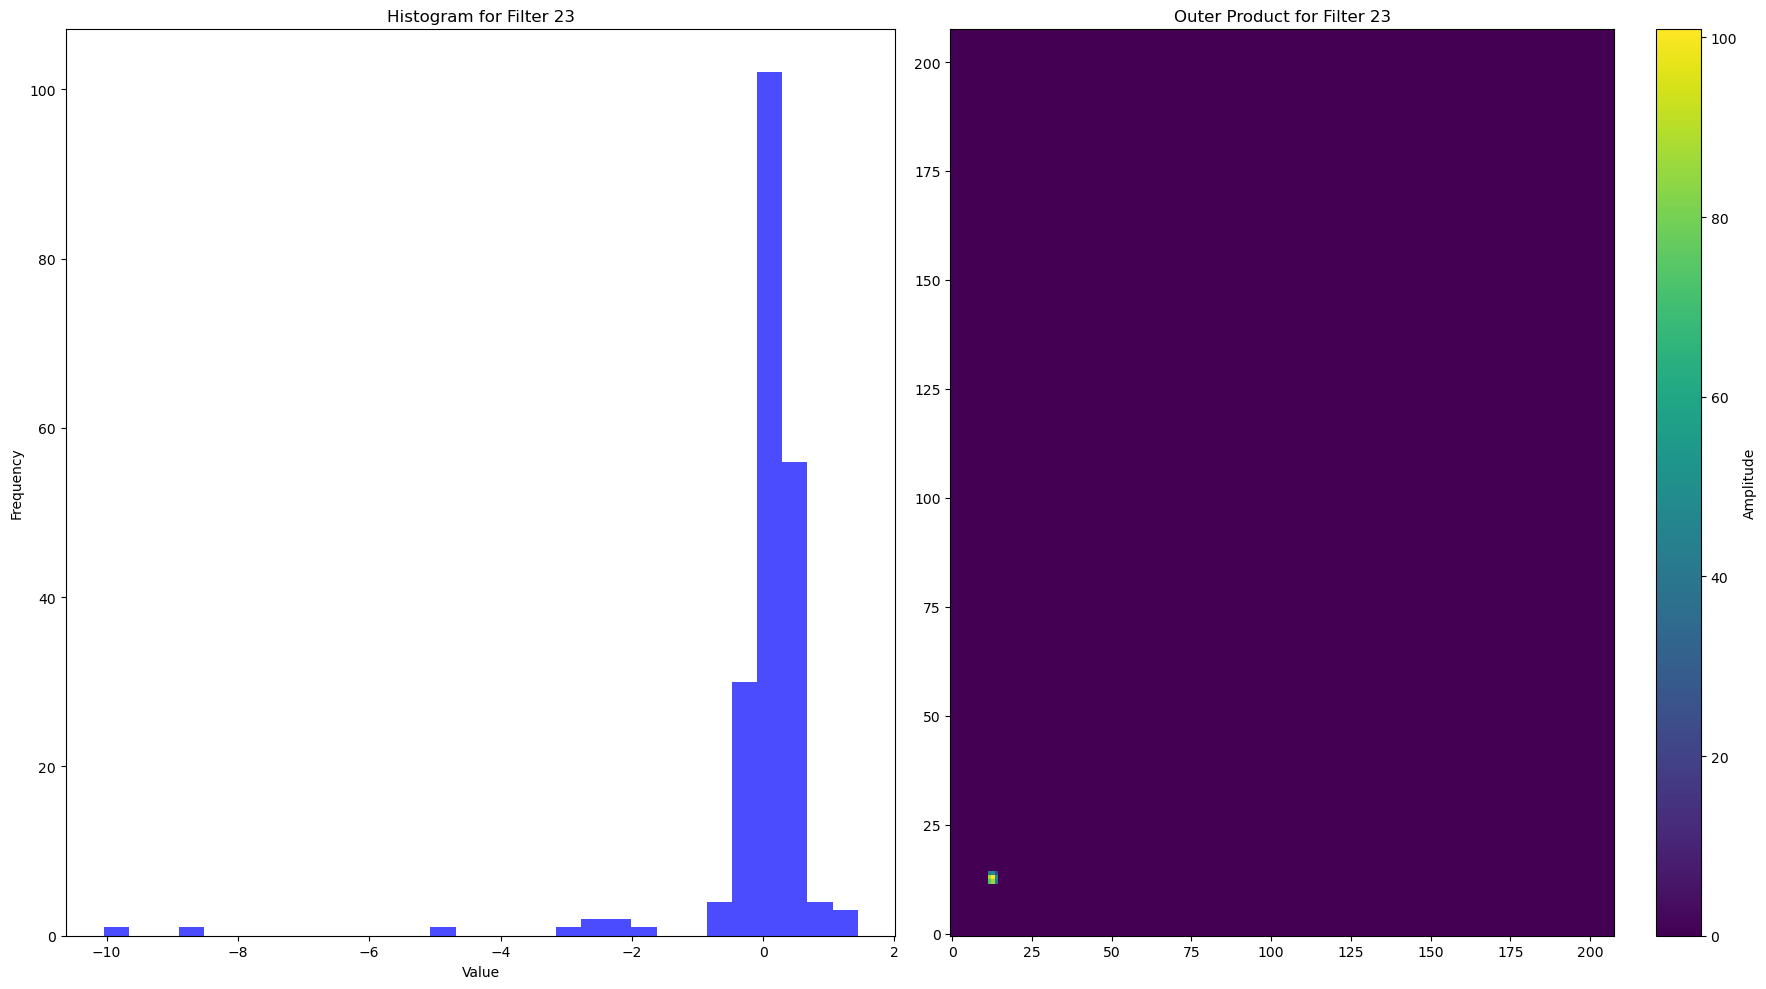

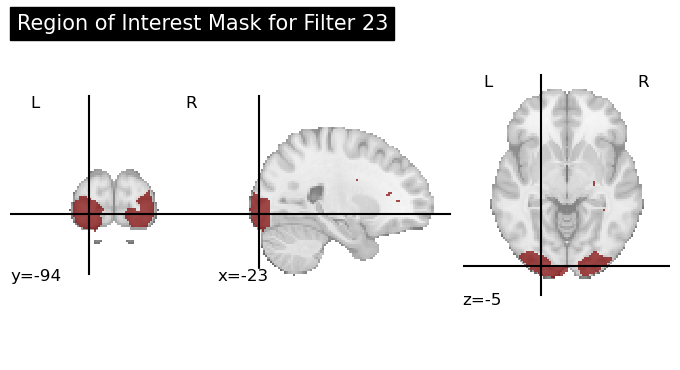

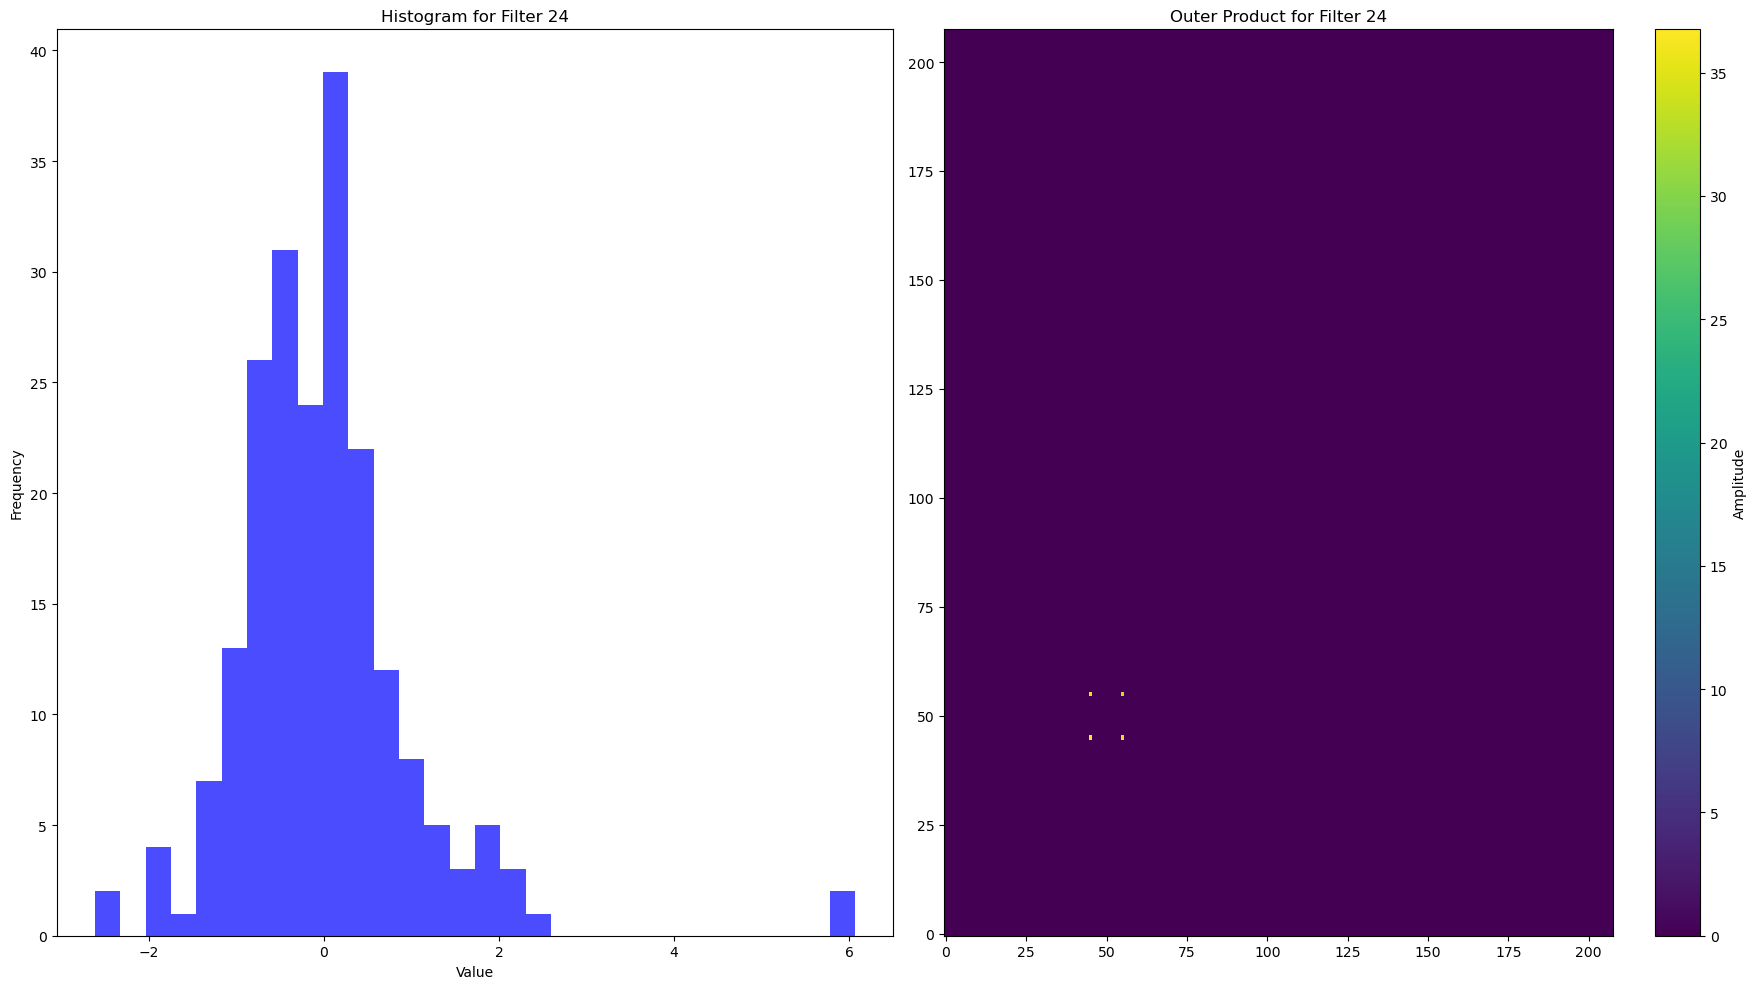

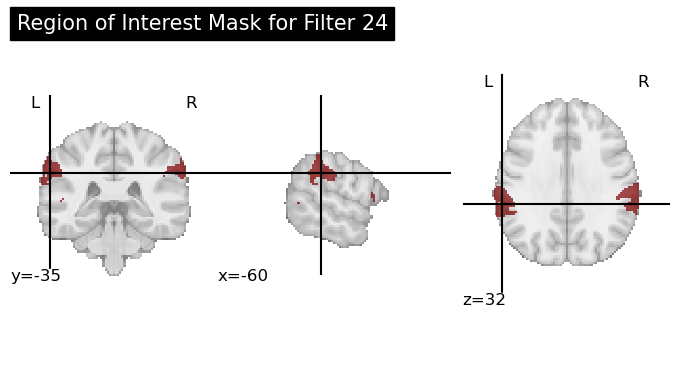

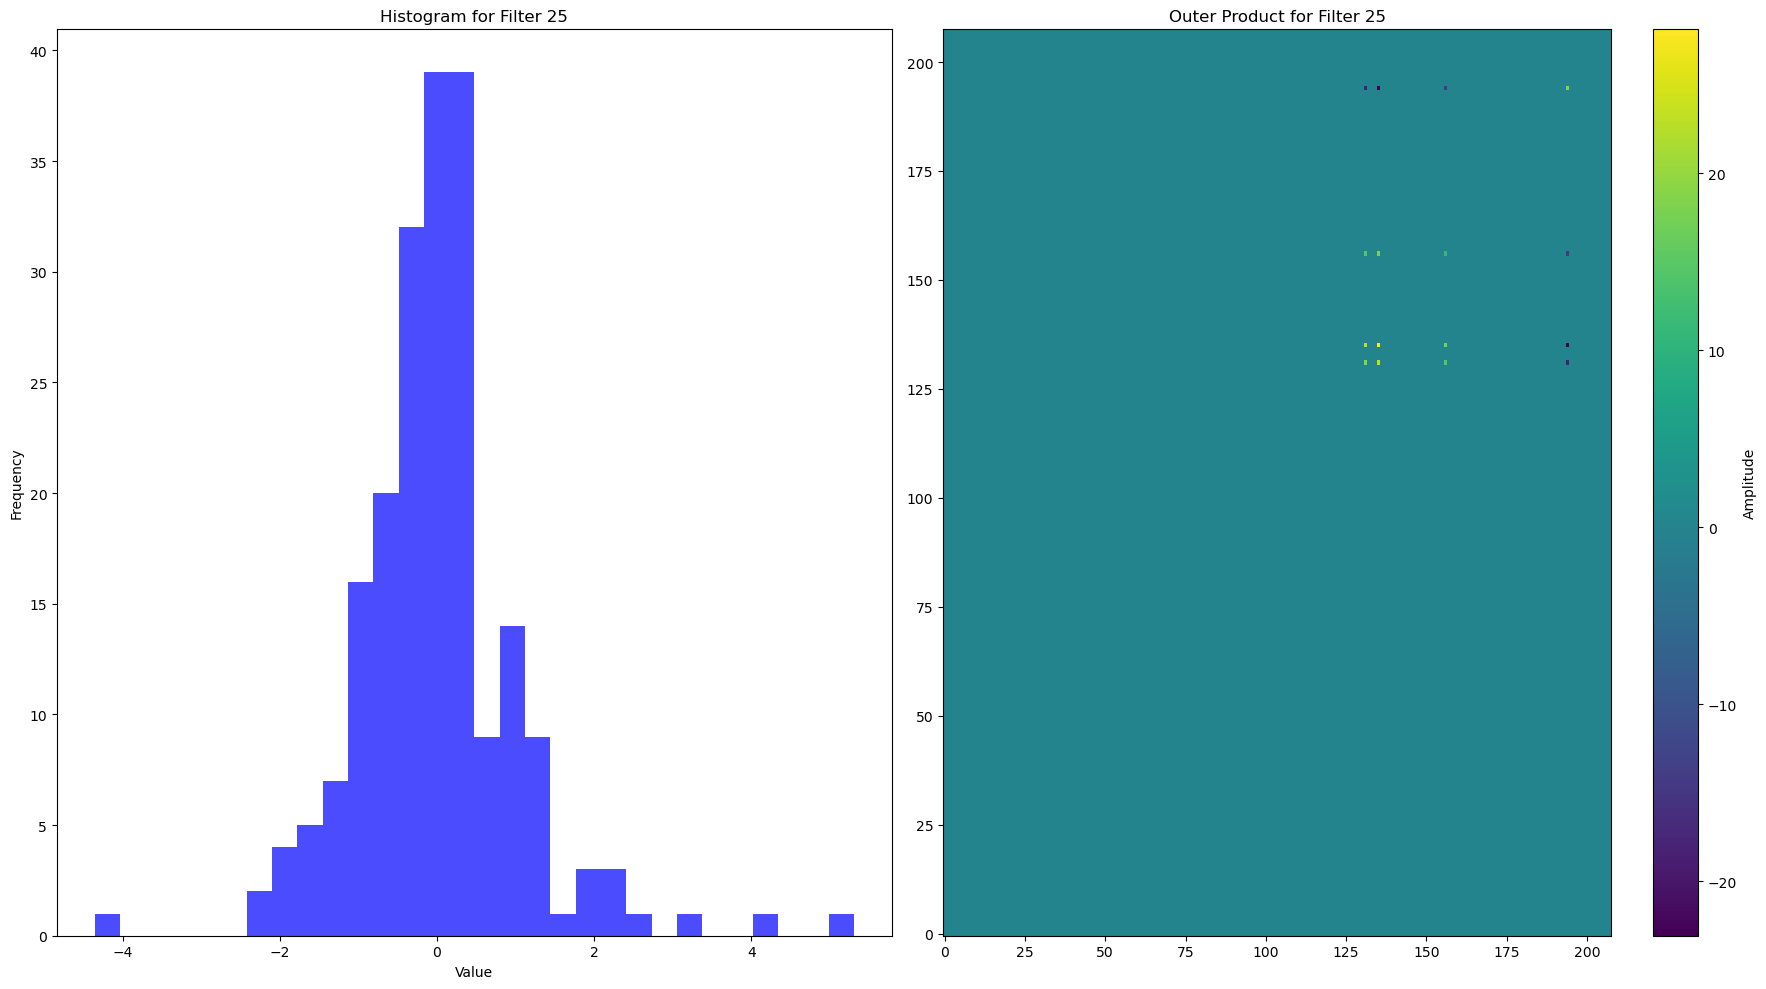

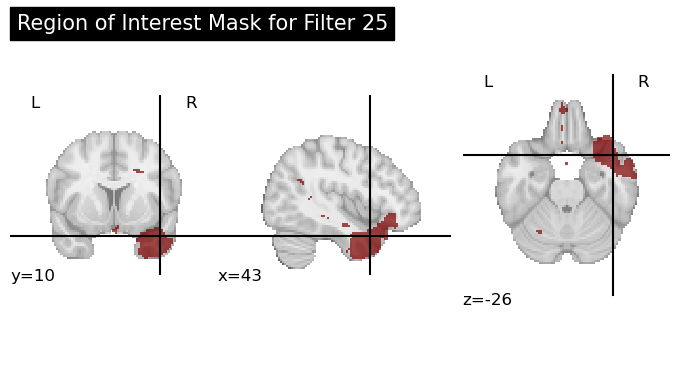

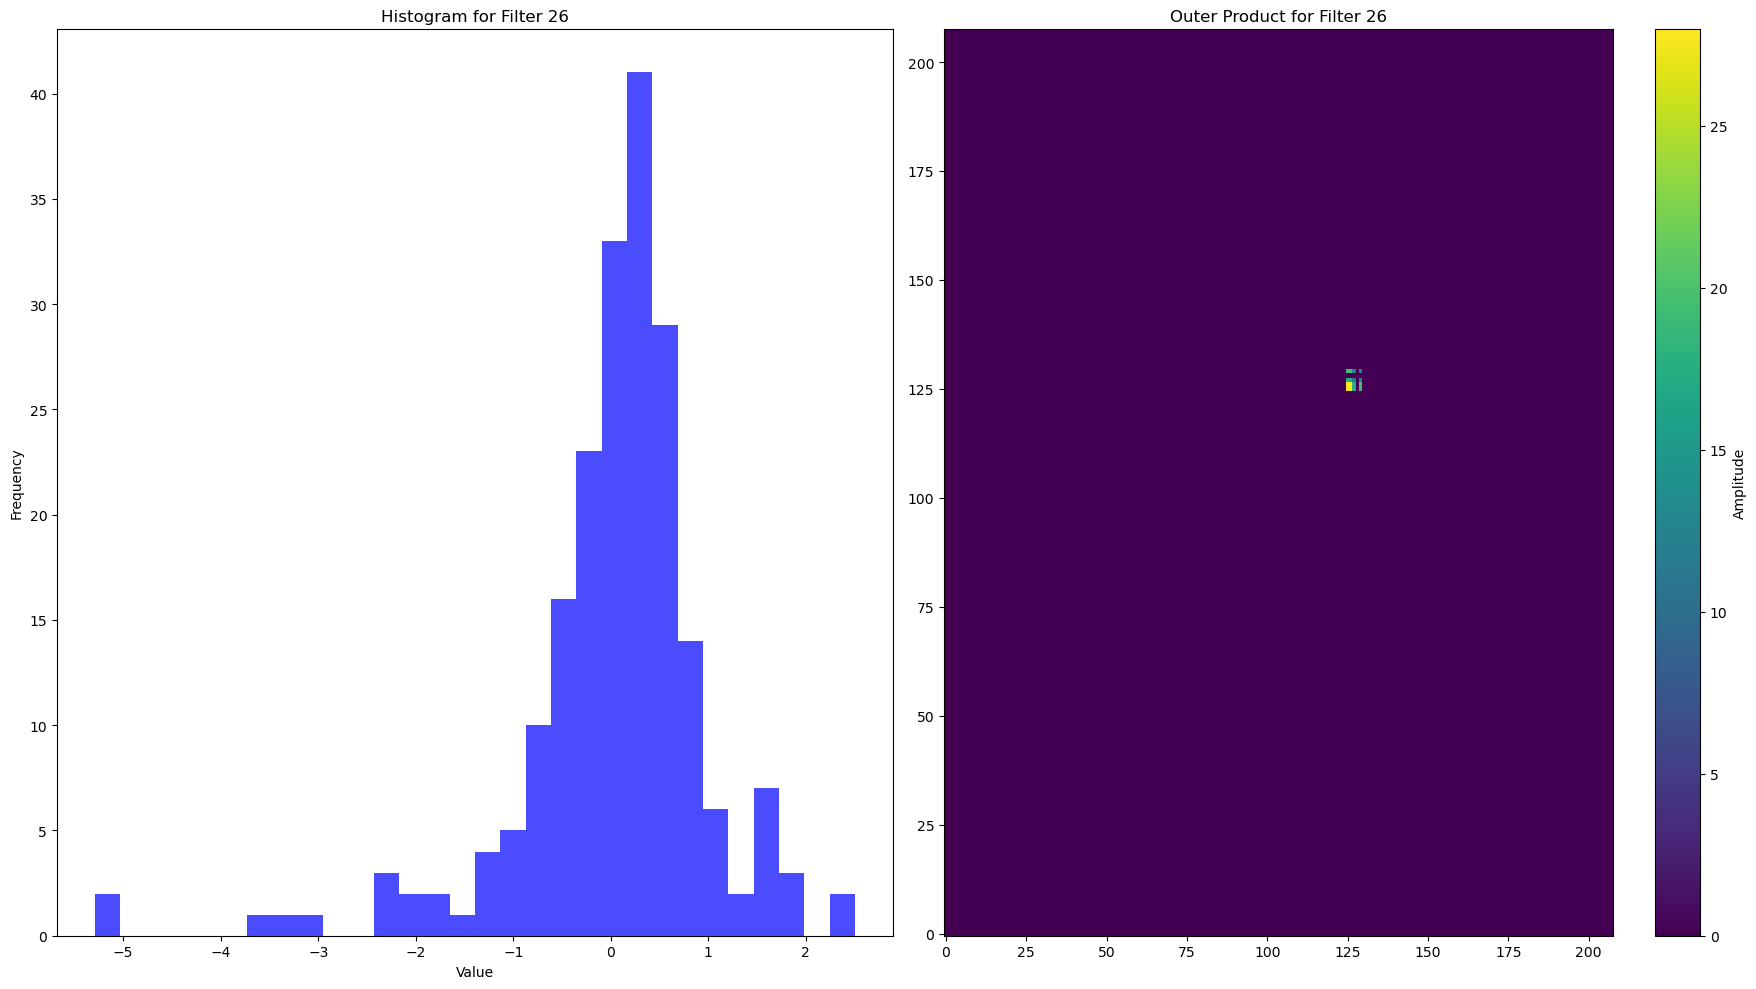

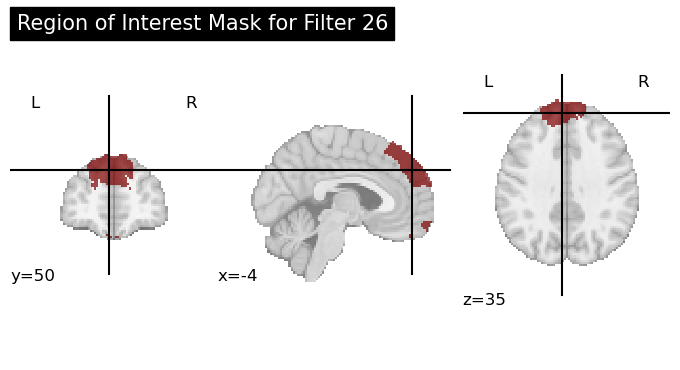

In [17]:
z_scores_thresh = threshold_and_visualize(subs_data_com, W_combined, raw_components_combined.T, atlas, save_images=False,folder_name="Lang_Motor")

In [ ]:
noise_normalizer_discrim = noise_projection(W_discrim,subs_data,raw_components_combined)
threshold_and_visualize(raw_components_discrim.T, atlas, noise_normalizer_discrim)

### Compare Different Runs of ICA

In [ ]:
def test_similarity(z_score1, z_score2, atlas):
    # Calculate the correlation matrix
    correlations = np.corrcoef(z_score1, z_score2, rowvar=False)
    threshold = 0.85  # Example threshold

    plt.figure()
    sns.heatmap(correlations, cmap='viridis')
    upper = np.abs(np.triu(correlations, k=1))
    lower = np.abs(np.tril(correlations, k=-1))

    upper_thresh = upper * (upper > threshold)
    lower_thresh = lower * (lower > threshold)

    plt.figure()
    sns.heatmap(upper_thresh, cmap='viridis')
    print(np.sum(upper_thresh))
    plt.figure()
    sns.heatmap(lower_thresh, cmap='viridis')
    print(np.sum(lower_thresh))

    # Find the rows where all values are below the threshold
    rows_below_threshold_upper = np.all(upper < threshold, axis=1)
    rows_below_threshold_lower = np.all(lower < threshold, axis=1)

    # Get the indices of those rows
    x_coordinates_upper = np.where(rows_below_threshold_upper[:z_score1.shape[1]])[0]
    x_coordinates_lower = np.where(rows_below_threshold_lower[z_score1.shape[1]:])[0]
    
    def plot_z_score_and_roi(z_score, filter_index, atlas):
        significant_voxels = np.where(np.abs(z_score) > 0)[0] + 1

        # Create a figure and axes for subplots (1 row of 2 plots per filter)
        fig, axes = plt.subplots(1, 2, figsize=(18, 10))

        ax_hist1 = axes[0]
        ax_img = axes[1]

        # Plot the histogram of the current filter
        ax_hist1.hist(z_score, bins=30, color='blue', alpha=0.7)
        ax_hist1.set_title(f"Histogram for Filter {filter_index}")
        ax_hist1.set_xlabel('Value')
        ax_hist1.set_ylabel('Frequency')

        # Generate the brain image mask using the significant indices
        outer_product = z_score @ z_score.T

        # Plot the outer product image on the corresponding subplot
        im = ax_img.imshow(outer_product, aspect='auto', cmap='viridis', origin='lower')
        ax_img.set_title(f"Outer Product for Filter {filter_index}")
        fig.colorbar(im, ax=ax_img, label='Amplitude')

        plt.tight_layout()
        plt.show()

        # Create ROI mask for significant voxels
        roi = ' | '.join([f'(a == {num})' for num in significant_voxels])
        final_string = f"(({roi}))"
        roi_mask = nimg.math_img(final_string, a=atlas)

        # Plot the ROI with nilearn and add a title
        display = nplot.plot_roi(roi_mask, cmap='jet')
        display.title(f"Region of Interest Mask for Filter {filter_index}")
        plt.show()

    for i in x_coordinates_upper:
        # Find the highest correlation in the upper matrix for this row
        plot_z_score_and_roi(z_score1[:,i:i+1], i, atlas)
        highest_corr_index = np.argmax(np.abs(upper[i, :])) - z_score1.shape[1]
        
        print("Closest to",i, "is",highest_corr_index ) 
        closest = z_score2[:, highest_corr_index:highest_corr_index+1]
        plot_z_score_and_roi(closest, highest_corr_index, atlas)
    
    for i in x_coordinates_lower:
        # Find the highest correlation in the lower matrix for this row
        plot_z_score_and_roi(z_score2[:,i:i+1], i, atlas)
        highest_corr_index = np.argmax(np.abs(lower[i, :]))
        
        print("Closest to",i, "is",highest_corr_index ) 
        closest = z_score1[:, highest_corr_index:highest_corr_index+1]
        plot_z_score_and_roi(closest, highest_corr_index, atlas)

raw_components_combined_con, A_combined_con, W_combined_con = ICA(combined_filters,subs_data,method="SVD")
raw_components_combined_alt, A_combined_alt, W_combined_alt = ICA(combined_filters,subs_data,method="QR")
z_scores_thresh_alt = threshold_and_visualize(subs_data, W_combined_alt, raw_components_combined_alt.T, atlas, save_images=False)
z_scores_thresh_con = threshold_and_visualize(subs_data, W_combined_con, raw_components_combined_con.T, atlas, save_images=False)
test_similarity(z_scores_thresh, z_scores_thresh_con,atlas)
test_similarity(z_scores_thresh, z_scores_thresh,atlas)
test_similarity(z_scores_thresh, z_scores_thresh_alt,atlas)

### Dual Regression

In [21]:
def dual_regress(preprocessed_group, z_scores_thresh):
    # Compute the standardized data
    std_group = np.std(preprocessed_group - (preprocessed_group @ np.linalg.pinv(z_scores_thresh.T)) @ z_scores_thresh.T,
                       axis=1, keepdims=True, ddof=np.linalg.matrix_rank(z_scores_thresh))
    standardized_group = preprocessed_group / std_group

    # Compute the dual regression
    dual_regressed = np.linalg.pinv(standardized_group @ np.linalg.pinv(z_scores_thresh.T)) @ standardized_group
    
    return dual_regressed
# Apply the function to both groups
dual_regressed_A = dual_regress(preprocessed_GroupA, z_scores_thresh)
dual_regressed_B = dual_regress(preprocessed_GroupB, z_scores_thresh)

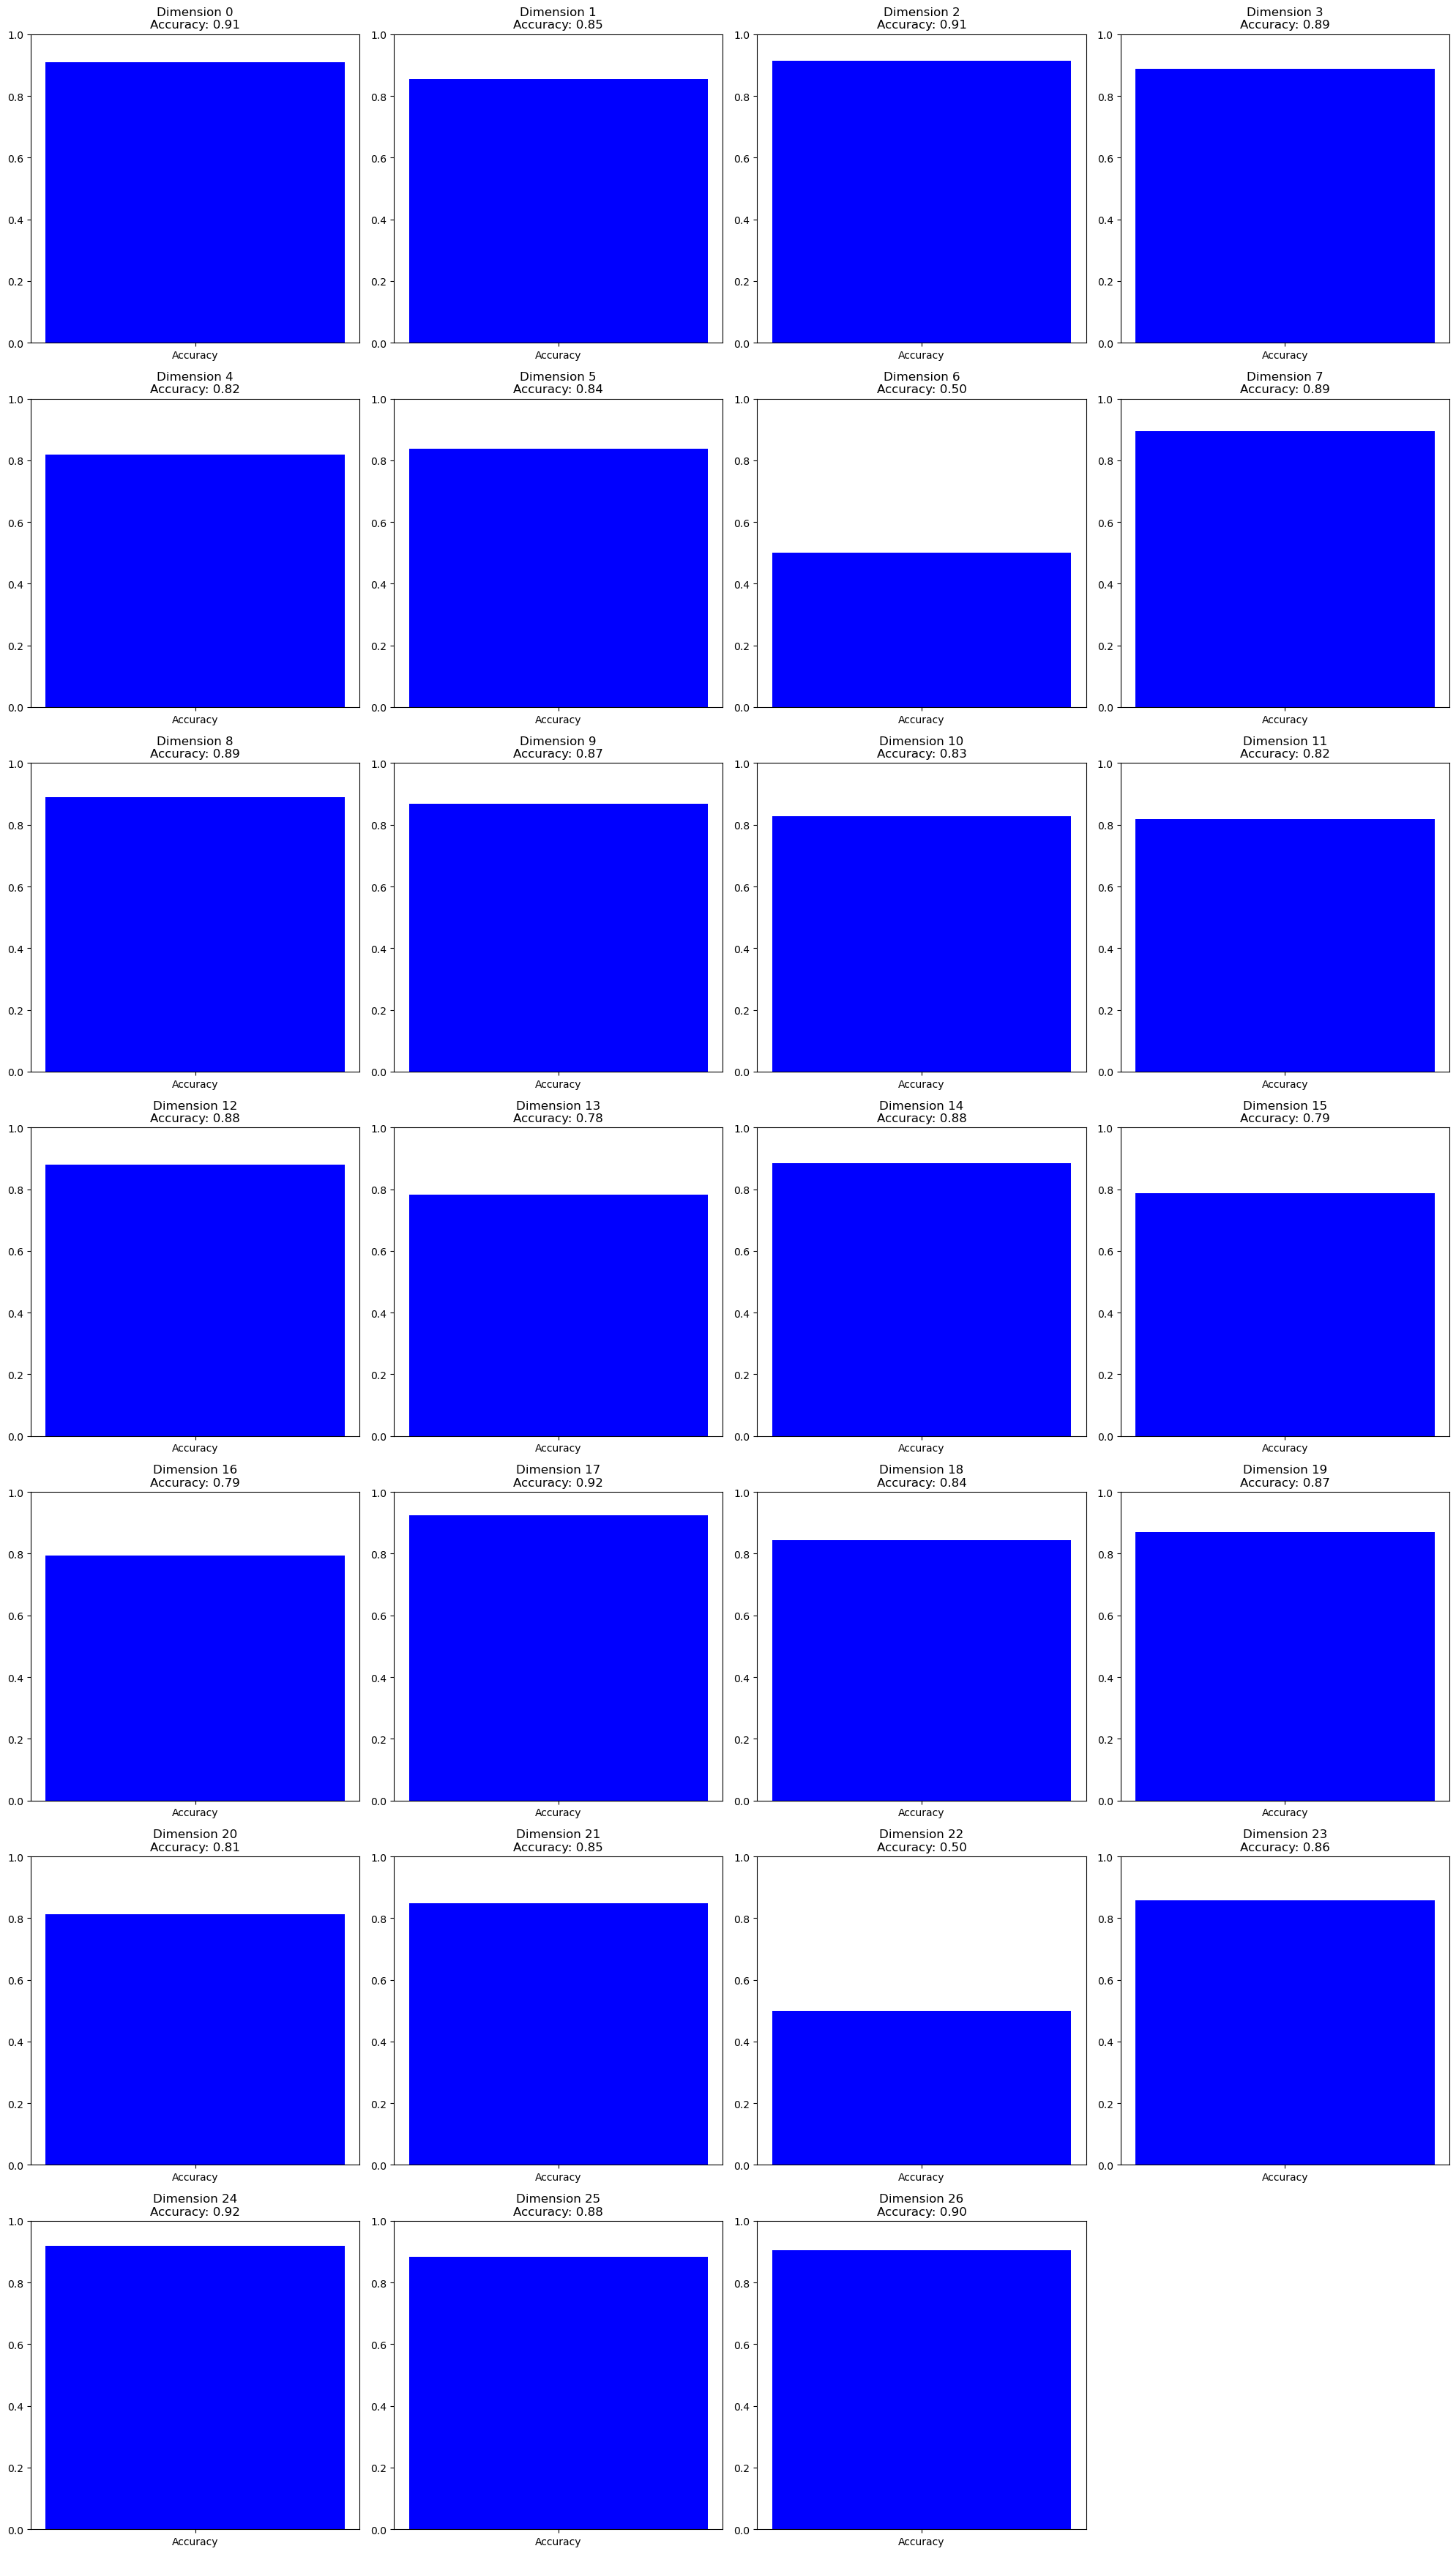

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import math

def evaluate_and_plot_logistic_regression(dual_regressed_A, dual_regressed_B):
    num_dimensions = dual_regressed_A.shape[1]
    logistic_accuracies = []

    # Determine the number of rows and columns for the subplots grid
    num_cols = 4  # Set a reasonable number of columns
    num_rows = math.ceil(num_dimensions / num_cols)  # Determine the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
    axes = axes.flatten()

    for i in range(num_dimensions):
        # Extract the ith dimension data from both groups
        data_A = dual_regressed_A[:, i, :].reshape(dual_regressed_A.shape[0], -1)
        data_B = dual_regressed_B[:, i, :].reshape(dual_regressed_B.shape[0], -1)

        # Combine the data for logistic regression
        combined_data = np.concatenate((data_A, data_B), axis=0)

        # Labels for the data (0 for Group A, 1 for Group B)
        true_labels = np.array([0] * data_A.shape[0] + [1] * data_B.shape[0])

        # Perform logistic regression
        logistic_reg = LogisticRegression(random_state=42)
        logistic_reg.fit(combined_data, true_labels)
        predicted_labels = logistic_reg.predict(combined_data)

        # Calculate the accuracy of logistic regression
        accuracy = accuracy_score(true_labels, predicted_labels)
        logistic_accuracies.append(accuracy)

        # Plotting the accuracy
        axes[i].bar(['Accuracy'], [accuracy], color='blue')
        axes[i].set_ylim(0, 1)
        axes[i].set_title(f"Dimension {i}\nAccuracy: {accuracy:.2f}")

    # Hide any unused subplots
    for j in range(num_dimensions, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    return logistic_accuracies

# Run the logistic regression evaluation and plotting function on your dual regression outputs
logistic_accuracies = evaluate_and_plot_logistic_regression(dual_regressed_A, dual_regressed_B)

### Score Group Specificity of the Filters